FAO_FoodSupply_LivestockFish

# Pre-Load

## Libraries and Settings

In [1]:
"""Modules"""

import urllib.request, urllib.parse, urllib.error
import requests
from bs4 import BeautifulSoup

import lxml
import re
import os
import time
import datetime
import chardet
import zipfile
from zipfile import ZipFile
import json
from io import BytesIO

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

import folium
from PIL import Image

import numpy as np
import pandas as pd

pd.set_option('precision', 4)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

def curl(url,path,mode='wb'):
    response = urllib.request.urlopen(url).read()
    with open(path, mode) as handle:
        handle.write(response)

In [2]:
""" DIRECTOR SETTINGS"""

FAO_DOWNLOADS_ROOT = 'http://fenixservices.fao.org/faostat/static/bulkdownloads/'
FAO_DOWNLOADS_XML = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.xml')
FAO_DOWNLOADS_JSON = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.json')
FAO_DOWNLOADS_BULK = os.path.join(FAO_DOWNLOADS_ROOT, 'FAOSTAT.zip')

print(f'FAOSTAT downloads root: {FAO_DOWNLOADS_ROOT}')
print(f'FAOSTAT description in .xml: {FAO_DOWNLOADS_XML}')
print(f'FAOSTAT description in .json: {FAO_DOWNLOADS_JSON}')
print(f'FAOSTAT downloads .zip: {FAO_DOWNLOADS_BULK}')

# what is the relevant path of root
root_where = '../../'

# print('+++++++++ Attention ++++++++++')
# print(f'The root is set as "{root_where}" relevant to this file.' )
# print(f'If it is not right, you change this parameter where the parameter name is "root_where".' )
# print('+++++++++++++++++++++++++++++')
# print('')

LOCAL_ROOT = os.path.abspath(root_where)
DATA_BASE = os.path.join(LOCAL_ROOT, 'data')
# print(f'Root director: {LOCAL_ROOT}')
# print(f'Data director: {DATA_BASE}')
# print('')

DATA_FAO = os.path.join(DATA_BASE, 'FAO')
FAO_meta = os.path.join(DATA_FAO, 'metadata')
FAO_description_path = FAO_meta + '/datasets_E.xml'
FAO_BULK_zip = DATA_FAO + '/FAOSTAT.zip'
SUFFIX = '_E_All_Data_(Normalized)'  # suffix of fao data file name
# print(f'FAO data director: {DATA_FAO}')
# print(f'FAO metadata director: {FAO_meta}')
# print(f'FAO local description file: {FAO_description_path}')
# print(f'FAO local data zip: {FAO_BULK_zip}')
print(f'Suffix of raw FAO data file name: {SUFFIX}')
# print('')

DATA_NBS = os.path.join(DATA_BASE, 'NBS')
NBS_meta = os.path.join(DATA_NBS, 'metadata')
# print(f'NBS data director: {DATA_NBS}')
# print(f'NBS metadata director: {NBS_meta}')
# print('')

DATA_hybrids = os.path.join(DATA_BASE, 'hybrids')
# print(f'Hybrids data director: {DATA_hybrids}')
# print('')

FAOSTAT downloads root: http://fenixservices.fao.org/faostat/static/bulkdownloads/
FAOSTAT description in .xml: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.xml
FAOSTAT description in .json: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.json
FAOSTAT downloads .zip: http://fenixservices.fao.org/faostat/static/bulkdownloads/FAOSTAT.zip
Suffix of raw FAO data file name: _E_All_Data_(Normalized)


In [3]:
# plt.style.use(['ggplot'])

# fig size
FIG_size = (5,3)
DPI = 144

# font size
TIT_size = 12    # titles
LAB_size = 10    # labels
LEG_size = 10    # legends
TCK_size = 10    # ticklabels

LIN_wei = 1.5    # line weights
BAR_wid = 3      # bar width

# GRD_wid = 0.5    # grid line width
# GRD_clr = 'white' 
# GRD_aph = 1     # grid alpha

# Color setting ===================================================================

# 猪，牛，羊，禽肉，鱼，蛋，奶
Pig_pink = '#ffab91'
Bovine_red = '#c62828'
Lamb_green = '#689f38'
Bird_orange = '#ff6f00'
Aqua_cyan = '#80deea'
Egg_yellow = '#ffc400'
Milk_blue = '#1e88e5'

# Good Food
GF_brand_gold = '#fdd835'
GF_brand_gray = '#9F888C'

GF_amber1 = '#ffe57f'
GF_amber2 = '#ffab00'

GF_red0 = '#ffebee'
GF_red1 = '#ff8a80'
GF_red2 = '#d50000'

GF_green1 = '#b9f6ca'
GF_green2 = '#00c853'

GF_blue1 = '#82b1ff'
GF_blue2 = '#2962ff'

# Gray
Gray1 = '#eeeeee'
Gray2 = '#bdbdbd'
Gray3 = '#666666'

CLs = [Pig_pink, Bovine_red, Lamb_green, Bird_orange, Aqua_cyan, Egg_yellow,  Milk_blue]

MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

In [4]:
domain = 'FAO_FoodSupply_LivestockFish'

# path_img = f'{LOCAL_ROOT}/results/{domain}/img/'
# path_map = f'{LOCAL_ROOT}/results/{domain}/map/'

# for i in os.listdir(path_img):
#     path_file = os.path.join(path_img,i)  
#     if os.path.isfile(path_file):
#           os.remove(path_file)
            
# for i in os.listdir(path_map):
#     path_file = os.path.join(path_map,i)
#     if os.path.isfile(path_file) and path_file.endswith(".html"):
#           os.remove(path_file)

## Variables

In [5]:
"""小写开头的字母用于临时变量"""

# data -- 用于创建表格的临时数据，创建完后必须赋值给永久变量
# df   -- 用于画图的临时数据，画图时将所需数据赋值给它
# dfs  -- 用于画图的临时数据字典，画图时将所需数据赋值给它
# domain
# 其他小写字母


"""初始化全局变量，请小心操作"""

# 用户自定义参数，会随着用户设置的变化而变化
D = ''    # Domain
A = ''    # Area     单一的国家/地区，
As = []
E = ''    # Element
Es = []
I = ''    # A paticular Item
Is = []   # Items

# 根据用户变量生成
DFs = {}        # 每个 Domain 的所有数据是一份 DF，keys=Domains，no index, columns=['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
CDTs = {}       # 从DFs筛选数据的条件，key0=Domain, key1=Area, key2=Element, value=Items
PVs_AreaYear = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Areas, columns=Years
PVs_YearArea = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Years, columns=Areas

Years = []      # 年份列表

PVs_AG = {}     # 某国家地区与其所在组合的某些 Items 的比较，key0=Domain, key1=Area, key2=Element, key3=[AG, A, G], index=Years, columns=[C,G]

# 必要的信息 
DOMs = {}        # Domain 的描述字典， key=domain_name(file name's pref)
LIST_countries=[]  # 国家级地区列表，Area Code < 5000, default refer to  worlds contries
LIST_groups=[]    # 地区组合列表，Area Code >= 5000, default grouped by continents

## Meta Data

In [6]:
def FAO_description_dic(soup):
    """
    input soup parsed by bs4
    parse it to dict with nessesary info
    """
    dic = {}
    for dataset in soup.find_all('Dataset'):
        file_loc = dataset.FileLocation.string
        domain = file_loc[file_loc.find('bulkdownloads/')+len('bulkdownloads/'):file_loc.find('_E_All')]
        dic[domain] = {'DatasetCode': dataset.DatasetCode.string,
                        'DatasetName': dataset.DatasetName.string,
                        'Topic': dataset.Topic.string,
                        'DatasetDescription': dataset.DatasetDescription.string,
                        'MedaData': [dataset.Contact.string, dataset.Email.string, dataset.DateUpdate.string, dataset.CompressionFormat.string, dataset.FileType.string, dataset.FileSize.string, dataset.FileRows.string],
                        'Url_Normalized':dataset.FileLocation.string}
    return dic

In [7]:
""" If you need to update, uncomment this cell. """
# # Download or update FAOSTAT datasets if necessary
# if os.path.exists(FAO_description_path) or os.path.exists(FAO_BULK_zip): pass
# else: 
#     print('Need to download or update FAOSTAT datasets.')
#     print('Processing ...')
#     curl(url=FAO_DOWNLOADS_XML, path=FAO_description_path)
#     curl(url=FAO_DOWNLOADS_BULK, path=FAO_BULK_zip)
    
# # Check local datasets update  
# print('Checking updates ...')

# # local datasets
# print('Checking Local description ...')
# with open(FAO_description_path, 'rb') as handle:
#     xml = handle.read()
#     soup = BeautifulSoup(xml, 'xml')
# xml_local = FAO_description_dic(soup)

# # online datasets
# print('Checking latest description ...')
# response = requests.get(FAO_DOWNLOADS_XML)
# xml = response.content
# soup = BeautifulSoup(xml, 'xml')
# xml_online = FAO_description_dic(soup)

# # compare
# print('Comparing ...')
# shared_items = {k: xml_local[k] for k in xml_local if k in xml_online and xml_local[k] == xml_online[k]}
# need_update = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}
# update_to = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}

# print('No. of local datasets: ', len(xml_local))
# print('No. of latest datasets: ', len(xml_online))
# print('No. of shared datasets: ', len(shared_items))

# if len(xml_local)==len(shared_items) and len(xml_local)==len(xml_online):
#     print ('Already up to date.')
# else:
#     print('Need update: ', need_update)
#     print('Update to: ', update_to)
#     print("NOTE: If you don't concern about datasets listed above, there's no need to update!")
    
# print('Done succesfully.')

' If you need to update, uncomment this cell. '

## Read Data Frame

In [8]:
def rdDF(domain):
    
    display(DOMs[domain])
    
    zf = ZipFile(f'{DATA_FAO}/{domain}{SUFFIX}.zip')
    encodings = ["ISO-8859-1", "UTF-8", "UTF-8-SIG", "GBK"]
    for encoding in encodings:
        try:
            data = pd.read_csv(zf.open(f'{domain}{SUFFIX}.csv'), encoding=encoding)
        except:
            pass
    
    display(data.head())
    display(data.tail())

    return data

In [10]:
# 给 Domain 赋值，查看数据基础信息
with open(FAO_description_path, 'rb') as handle:
    xml = handle.read()
    soup = BeautifulSoup(xml, 'xml')
DOMs = FAO_description_dic(soup)
# display(DOMs)

D = domain[4:]

In [11]:
# Show you raw data
try:
    DATA = rdDF(D)
except:
    with ZipFile(FAO_BULK_zip, 'r') as zf1:
        zf1.extract(f'{D}{SUFFIX}.zip', DATA_FAO)
        DATA = rdDF(D)
print('data shape: ', DATA.shape)

{'DatasetCode': 'CL',
 'DatasetName': 'Food Balance: Food Supply - Livestock and Fish Primary Equivalent',
 'Topic': 'Most crop and livestock products, including processed products, under agricultural activity.',
 'DatasetDescription': 'Food supply data is some of the most important data in FAOSTAT. In fact, this data is for the basis for estimation of global and national undernourishment assessment, when it is combined with parameters and other data sets. This data has been the foundation of food balance sheets ever since they were first constructed. The data is accessed by both business and governments for economic analysis and policy setting, as well as being used by the academic community.',
 'MedaData': ['Mr. Salar Tayyib',
  'faostat@fao.org',
  '2018-01-17',
  'zip',
  'csv',
  '13789KB',
  '2029430'],
 'Url_Normalized': 'http://fenixservices.fao.org/faostat/static/bulkdownloads/FoodSupply_LivestockFish_E_All_Data_(Normalized).zip'}

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,2731,Bovine Meat,641,Food supply quantity (tonnes),1961,1961,tonnes,43000.0,S
1,2,Afghanistan,2731,Bovine Meat,641,Food supply quantity (tonnes),1962,1962,tonnes,45800.0,S
2,2,Afghanistan,2731,Bovine Meat,641,Food supply quantity (tonnes),1963,1963,tonnes,47250.0,S
3,2,Afghanistan,2731,Bovine Meat,641,Food supply quantity (tonnes),1964,1964,tonnes,48000.0,S
4,2,Afghanistan,2731,Bovine Meat,641,Food supply quantity (tonnes),1965,1965,tonnes,48700.0,S


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
2029425,5817,Net Food Importing Developing Countries,2901,Grand Total,684,Fat supply quantity (g/capita/day),2009,2009,g/capita/day,51.99,Fc
2029426,5817,Net Food Importing Developing Countries,2901,Grand Total,684,Fat supply quantity (g/capita/day),2010,2010,g/capita/day,52.58,Fc
2029427,5817,Net Food Importing Developing Countries,2901,Grand Total,684,Fat supply quantity (g/capita/day),2011,2011,g/capita/day,53.71,Fc
2029428,5817,Net Food Importing Developing Countries,2901,Grand Total,684,Fat supply quantity (g/capita/day),2012,2012,g/capita/day,53.58,Fc
2029429,5817,Net Food Importing Developing Countries,2901,Grand Total,684,Fat supply quantity (g/capita/day),2013,2013,g/capita/day,53.53,Fc


data shape:  (2029430, 11)


## Show Countries and Groups

In [12]:
# Countries in FAO data of this domain
Countries_FAO = DATA[DATA['Area Code']<5000]['Area'].unique().tolist()
# print('Countries in FAO data of this domain: ')
# display(Countries_FAO)

# Countries in geojson
with open(f'{FAO_meta}/geojson/world_countries.json') as json_file:
    json_data = json.load(json_file)
Countries_json = []
for feature in json_data['features']:
    Countries_json.append(feature['properties']['name'])
# print('Countries in geojson: ')
# display(Countries_json)

# Countries in FAO but not in geojson
Countries_no_json = [c for c in Countries_FAO if c not in Countries_json]
print('Countries in FAO but not in geojson: ')
display(Countries_no_json)

# Countries in geojson but not in FAO
Countries_no_FAO = [c for c in Countries_json if c not in Countries_FAO]
print('Countries in geojson but not in FAO: ')
display(Countries_no_FAO)

# Countries in both FAO and geojson
Countries = [c for c in Countries_json if c in Countries_FAO]
# print('Countries in geojson but not in FAO: ')
# display(Countries)

Countries in FAO but not in geojson: 


['Antigua and Barbuda',
 'Barbados',
 'Belgium-Luxembourg',
 'Bermuda',
 'Cabo Verde',
 'China',
 "C魌e d'Ivoire",
 'Czechoslovakia',
 'Dominica',
 'Ethiopia PDR',
 'French Polynesia',
 'Grenada',
 'Kiribati',
 'Maldives',
 'Malta',
 'Mauritius',
 'Netherlands Antilles (former)',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Samoa',
 'Sao Tome and Principe',
 'Serbia and Montenegro',
 'Sudan (former)',
 'USSR',
 'Yugoslav SFR']

Countries in geojson but not in FAO: 


['Antarctica',
 'French Southern and Antarctic Lands',
 'Burundi',
 'Bhutan',
 "Côte d'Ivoire",
 'Democratic Republic of the Congo',
 'Northern Cyprus',
 'Eritrea',
 'Falkland Islands (Malvinas)',
 'Equatorial Guinea',
 'Greenland',
 'Kosovo',
 'Libya',
 'Papua New Guinea',
 'Puerto Rico',
 'Qatar',
 'Western Sahara',
 'South Sudan',
 'Somaliland',
 'Somalia',
 'Syrian Arab Republic',
 'West Bank']

In [13]:
"""adjust FAO countries name"""
# rename because of decoding error
DATA.loc[DATA['Area']=="C魌e d'Ivoire", 'Area'] = "Côte d'Ivoire"

# Countries too small to consider for now
Countries_too_small = [
    'Antigua and Barbuda',  # 安提瓜和巴布达
    'Barbados',             # 巴巴多斯
    'Bermuda',              # 百慕大
    'Cabo Verde',           # 弗德角
    'Dominica',             # 多米尼克, 非多米尼加共和国
    'French Polynesia',     # 法属玻璃尼亚  a part of 'French Southern and Antarctic Lands' of geojson
    'Grenada',              # 格林纳达
    'Kiribati',             # 基里巴斯
    'Maldives',             # 马尔代夫
    'Malta',                # 马耳他
    'Mauritius',            # 毛里求斯
    'Saint Kitts and Nevis',  # 圣基茨和尼维斯
    'Saint Lucia',            # 圣卢西亚
    'Saint Vincent and the Grenadines', # 圣文森特和格林纳丁斯
    'Samoa',                  # 萨摩亚
    'Sao Tome and Principe',  # 圣多美和普林西比
]
DATA = DATA[~DATA['Area'].isin(Countries_too_small)]

# Countries not exists now
Countries_not_now = [
    # 与前苏联解体相关
    'Czechoslovakia',        # dissolved 1992, 捷克斯洛伐克
    'Ethiopia PDR',          # 1987~1991, 埃塞俄比亚人民民主共和国
    'USSR',                  # dissolved 1991
    'Yugoslav SFR',          # 1945~1992, 南斯拉夫社会主义联邦共和国
    'Serbia and Montenegro',         # 1992~2006, 塞尔维亚和黑山国家联盟
    # 
    'Netherlands Antilles (former)', # dissolved 2010, islands, too small
    # 苏丹
    'Sudan (former)',                # dissolved 2011
]
# disslved see map for old

"""adjust geojson"""
# China SARs
China_SARs = [                           # added
    'China, Hong Kong SAR', # add new polygon
    'China, Macao SAR',     # add new polygon
]

# Two Countries can say one or can say independently  # Use 'Belgium' and 'Luxembourg'
Belgium_Luxembourg = [
    'Belgium',
    'Luxembourg',
]
DATA = DATA[~DATA['Area'].isin(['Belgium-Luxembourg'])]

# Sudan (former)                          ! not considered now
Sudan_former = [
    'Sudan',
    'South Sudan',
]

# Add a map before 1992, where:
# following countries in 'USSR'           # added
USSR = [
    "Russian Federation"
    "Kazakhstan",          # 哈萨克斯坦
    "Estonia",             # 爱沙尼亚
    "Ukraine",             # 乌克兰
    "Belarus",             # 白俄罗斯
    "Uzbekistan",          # 乌兹别克斯坦
    "Georgia",             # 格鲁吉亚
    "Azerbaijan",          # 阿塞拜疆
    "Lithuania",           # 立陶宛
    "Republic of Moldova", # 摩尔多瓦
    "Latvia",              # 拉脱维亚
    "Kyrgyzstan",          # 吉尔吉斯斯坦
    "Tajikistan",          # 塔吉克斯坦
    "Armenia",             # 阿美妮娅
    "Turkmenistan",        # 土库曼斯坦
]

# following countries in 'Czechoslovakia'
Czechoslovakia = [
    'Czechia',
    'Slovakia',
]

# following countries in 'Yugoslav SFR'  ! not considered now
Yugoslav_SFR = [
    'The former Yugoslav Republic of Macedonia', # 1992~, 继任前南斯拉夫的北马其顿，rename in geojson from 'North Macedonia'
    'Serbia',      # 2006~
    'Montenegro',  # 2006~
]

# Add a map 1992~2006, where:            ! not added for not considered now
Serbia_Montenegro = [
    'Serbia',     # 2006~
    'Montenegro', # 2006~
]


# Countries in FAO data of this domain
Countries_FAO = DATA[DATA['Area Code']<5000]['Area'].unique().tolist()
print('Countries in FAO data of this domain: ')
display(Countries_FAO)

# Groups in FAO
Groups_FAO = DATA[DATA['Area Code']>=5000]['Area'].unique().tolist()
print('Groups in FAO: ')
display(Groups_FAO)

Countries in FAO data of this domain: 


['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'China, mainland',
 'China, Taiwan Province of',
 'Colombia',
 'Congo',
 'Costa Rica',
 "Côte d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 "Democratic People's Republic of Korea",
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Ethiopia PDR',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'I

Groups in FAO: 


['World',
 'Africa',
 'Eastern Africa',
 'Middle Africa',
 'Northern Africa',
 'Southern Africa',
 'Western Africa',
 'Americas',
 'Northern America',
 'Central America',
 'Caribbean',
 'South America',
 'Asia',
 'Central Asia',
 'Eastern Asia',
 'Southern Asia',
 'South-Eastern Asia',
 'Western Asia',
 'Europe',
 'Eastern Europe',
 'Northern Europe',
 'Southern Europe',
 'Western Europe',
 'Oceania',
 'Australia & New Zealand',
 'Melanesia',
 'Micronesia',
 'Polynesia',
 'European Union',
 'Least Developed Countries',
 'Land Locked Developing Countries',
 'Small Island Developing States',
 'Low Income Food Deficit Countries',
 'Net Food Importing Developing Countries']

In [14]:
# 加载国家列表
LIST_countries = Countries_FAO
print(f'There are {len(LIST_countries)} countries')
# display(LIST_countries)

# 加载区域/组合列表
LIST_groups = Groups_FAO
print(f'There are {len(LIST_groups)} groups.')
# display(LIST_groups)

# 自定义常用区域/组合列表
# China
China = ['China, mainland']+China_SARs+['China, Taiwan Province of']

# OECD
LIST_countries_OECD = []
with open(FAO_meta+'/list_countries_OECD.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_OECD.append(line)
print(f'There are {len(LIST_countries_OECD)} OECD countries.')
# display(LIST_countries_OECD)

# BRICS
LIST_countries_BRICS = ['Brazil', 'India', 'Russian Federation', 'South Africa'] + China

# EU
LIST_countries_EU = []
with open(FAO_meta+'/list_countries_EU.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_EU.append(line)

# G20
LIST_countries_G20 = []
with open(FAO_meta+'/list_countries_G20.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_G20.append(line)
LIST_countries_G20 = list(set(LIST_countries_G20 + LIST_countries_EU + China))

# Asia
LIST_countries_asia = []
with open(FAO_meta+'/list_countries_asia.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_asia.append(line)
print(f'There are {len(LIST_countries_asia)} Asian countries.')
# display(LIST_countries_asia)

There are 166 countries
There are 34 groups.
There are 36 OECD countries.
There are 53 Asian countries.


## Show Years Range

In [15]:
# 查看数据 Years 范围
Years = DATA['Year'].unique()
print(f'Dataset years range: {Years[0]} ~ {Years[-1]}')

# 定义 Years 分析范围
# Years = range(1961,2019+1)
print(f'You choose years range: {Years[0]} ~ {Years[-1]}')

DATA = DATA[DATA['Year'].isin(Years)]

Dataset years range: 1961 ~ 2013
You choose years range: 1961 ~ 2013


## Show Element and Items

In [16]:
# 选择列
COLUMNS = ['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']

DATA = DATA[COLUMNS]
print('data shape: ', DATA.shape)

# 去空值和重复值（不是必须的，检查 data shape）
DATA = DATA.dropna().drop_duplicates()
print('data shape after drop Non. and Dup.: ', DATA.shape)

# 查看数据构成
print('Groupe data by Elements and Items: ')
display(DATA.groupby(['Element','Item']).count())

data shape:  (1860733, 7)
data shape after drop Non. and Dup.:  (1749066, 7)
Groupe data by Elements and Items: 


Area Code  \
Element                                Item                                 
Fat supply quantity (g/capita/day)     Animal Products               9506   
                                       Animal fats                   9506   
                                       Aquatic Animals, Others       7785   
                                       Aquatic Plants                8924   
                                       Aquatic Products, Other       9144   
                                       Bovine Meat                   9506   
                                       Butter, Ghee                  9506   
                                       Cephalopods                   9334   
                                       Cheese                        9272   
                                       Cream                         8689   
                                       Crustaceans                   9451   
                                       Demersal Fish                 9453   
                                       Eggs                          9506   
                                       Fats, Animals, Raw            9484   
                                       Fish, Body Oil                9004   
                                       Fish, Liver Oil               8261   
                                       Fish, Seafood                 9506   
                                       Freshwater Fish               9506   
                                       Grand Total                   9506   
                                       Marine Fish, Other            9400   
                                       Meat                          9506   
                                       Meat, Aquatic Mammals          424   
                                       Meat, Other                   9400   
                                       Milk - Excluding Butter       9506   
                                       Milk, Whole                   9325   
                                       Molluscs, Other               9419   
                                       Mutton & Goat Meat            9506   
                                       Offals                        9506   
                                       Offals, Edible                9506   
                                       Pelagic Fish                  9453   
                                       Pigmeat                       9241   
                                       Poultry Meat                  9506   
                                       Whey                          2800   
Food supply (kcal/capita/day)          Animal Products               9506   
                                       Animal fats                   9506   
                                       Aquatic Animals, Others       7785   
                                       Aquatic Plants                8924   
                                       Aquatic Products, Other       9144   
                                       Bovine Meat                   9506   
                                       Butter, Ghee                  9506   
                                       Cephalopods                   9334   
                                       Cheese                        9272   
                                       Cream                         8691   
                                       Crustaceans                   9451   
                                       Demersal Fish                 9453   
                                       Eggs                          9506   
                                       Fats, Animals, Raw            9484   
                                       Fish, Body Oil                9004   
                                       Fish, Liver Oil               8261   
                                       Fish, Seafood                 9506   
                                       Freshwater Fish      

# Data Visualization

## Parameter Settings

### Area Selection

In [17]:
# 给 Area 赋值
A = 'China, mainland'

data = DATA.copy()

df_area = data[data['Area']==A]

# display(data.groupby(['Element','Item']).count())
display('Elements:', data.Element.unique())
display('Items:', data.Item.unique())

'Elements:'

array(['Food supply quantity (tonnes)',
       'Food supply quantity (g/capita/day)',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)'], dtype=object)

'Items:'

array(['Bovine Meat', 'Butter, Ghee', 'Cheese', 'Cream', 'Eggs',
       'Fats, Animals, Raw', 'Freshwater Fish', 'Honey', 'Meat, Other',
       'Milk - Excluding Butter', 'Milk, Whole', 'Mutton & Goat Meat',
       'Offals, Edible', 'Poultry Meat', 'Animal fats', 'Animal Products',
       'Fish, Seafood', 'Meat', 'Offals', 'Grand Total',
       'Aquatic Animals, Others', 'Aquatic Plants', 'Cephalopods',
       'Crustaceans', 'Demersal Fish', 'Fish, Body Oil',
       'Fish, Liver Oil', 'Marine Fish, Other', 'Molluscs, Other',
       'Pelagic Fish', 'Pigmeat', 'Aquatic Products, Other', 'Whey',
       'Meat, Aquatic Mammals', 'Meat Meal', 'Hides and skins'],
      dtype=object)

### Element and Items Selection

In [18]:
def mkPV_forArea_ItemYear(area, element):   
    df = DATA.copy()
    df = df[(df['Area']==area) & (df['Element']==element)]
    df = pd.pivot_table(df,index=['Item'],columns=['Year'],values=['Value'])
    df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
    df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
    pivot = df
#     display(pivot.head())
    return pivot  

def mkPV_forArea_ElementYear(area, item):   
    df = DATA.copy()
    df = df[(df['Area']==area) & (df['Item']==item)]
    df = pd.pivot_table(df,index=['Element'],columns=['Year'],values=['Value'])
    df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
    df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
    pivot = df
#     display(pivot.head())
    return pivot

In [19]:
# 用于单项测试，可展示某item 相对其他 item 在同一个 area 内的 排名变化，筛选主要的品类，空值可跳过
E = ''

I = ''

pivot=pd.DataFrame()
if E != '': pivot = mkPV_forArea_ItemYear(A, E)
if I != '': pivot = mkPV_forArea_ElementYear(A, I)
if pivot.shape==(0,0):pass
else:
    pivot.sort_values(Years[-1], axis=0, ascending = False, inplace = True)

    rankings={}
    for i in pivot.index.values:
        ranks=np.array([])
        for y in pivot.columns:
            pivot.sort_values(y, axis=0, ascending = False, inplace = True)
            rank = pivot.index.tolist().index(i)
            ranks = np.append(ranks,rank)
        rankings[i]=ranks

    fig = plt.figure(figsize = (16,8))
    plt.title('Rankings of All Items')
    n=0
    lines = LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs
    colors = CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs
    
    for i in pivot.index.values:
        plt.plot(pivot.columns, rankings[i],color=colors[n], linestyle=lines[n])
        n+=1
    plt.legend(labels=pivot.index.values,loc='lower center',bbox_to_anchor=(1.1,0),borderaxespad = 0.)
    ax = plt.gca().invert_yaxis()

### Explorded Classification of Items

#### FoodSupply_LivestockFish

    'Grand Total':['Animal Products', 'Aquatic Plants'],
    'Animal Products':['Meat','Fish, Seafood','Milk - Excluding Butter','Eggs','Offals','Animal fats'],
    'Meat': ['Poultry Meat', 'Pigmeat','Bovine Meat','Mutton & Goat Meat','Meat, Other'],
    'Fish, Seafood':['Freshwater Fish','Molluscs, Other', 'Crustaceans','Cephalopods','Demersal Fish','Pelagic Fish','Marine Fish, Other'],
    'Milk - Excluding Butter':[],
    'Eggs':[],
    'Offals':[],
    'Animal fats':[],


In [20]:
# 给 Elements 赋值
E = 'Food supply quantity (tonnes)'
# 给 Items 赋值
Is = {
    'Grand Total':['Grand Total','Animal Products'],
#   动物产品（未包含蜂蜜）
    'Animal Products':['Meat','Fish, Seafood','Eggs','Milk - Excluding Butter','Offals','Animal fats'],
#   畜禽肉
    'Meat': ['Pigmeat','Bovine Meat','Mutton & Goat Meat','Poultry Meat', 'Meat, Other'],
    'Pigmeat':[],
    'Bovine Meat':[],
    'Mutton & Goat Meat':[],
    'Poultry Meat':[], 
#   水产（未包含子类）
    'Fish, Seafood':[],
#   蛋类
    'Eggs':[],
#   奶类
    'Milk - Excluding Butter':[],
}

data = df_area.copy()

data = data[(data['Element']==E) & (data['Item'].isin(Is))]

display(data.groupby(['Element','Item']).count())

# display(data.head(2))
# display(data.tail(2))

# display(data.groupby(['Item']).count())
display(data.groupby(['Unit']).count())                   # 查看单位

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

Area Code  Area  Year  \
Element                       Item                                             
Food supply quantity (tonnes) Bovine Meat                     53    53    53   
                              Eggs                            53    53    53   
                              Fish, Seafood                   53    53    53   
                              Meat                            53    53    53   
                              Milk - Excluding Butter         53    53    53   
                              Mutton & Goat Meat              53    53    53   
                              Pigmeat                         53    53    53   
                              Poultry Meat                    53    53    53   

                                                       Unit  Value  
Element                       Item                                  
Food supply quantity (tonnes) Bovine Meat                53     53  
                              Eggs                       53     53  
                              Fish, Seafood              53     53  
                              Meat                       53     53  
                              Milk - Excluding Butter    53     53  
                              Mutton & Goat Meat         53     53  
                              Pigmeat                    53     53  
                              Poultry Meat               53     53

,Area Code,Area,Element,Item,Year,Value
Unit,,,,,,
tonnes,424,424,424,424,424,424


['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


In [21]:
def getAllItems(
    element,
    items = [],
    items_groups=[],
):
    if items != []: items = items
    else:
        #     如果不设置items_groups，那么 items 仅包含 Is 的末梢，即值为空的键
        if items_groups==[]: items = ITEMs.copy()     
        #     否则，items会包含 Is 中键为 items_groups 中的 item，以及所有的末梢，最后取其的 set 去掉重复元素
        else:
            items = ITEMs.copy()
            for g in items_groups:
                for i in CDTs[element][g]:
                    items.append(i)
            items = list(set(items))
    return items

In [22]:
def getAllItemsInArea(
    area,
    element,
    items=[],
    items_groups=[],
):
    items = getAllItems(element=element, items=items, items_groups=items_groups)
    
    pivot = mkPV_forArea_ItemYear(area=area,element=element).copy()
    
    rankings = {}
    for i in items:
        if i in pivot.index:
            ranks=np.array([])
            for y in Years:
                pivot.sort_values(y, axis=0, ascending=False, inplace=True)
                rank = pivot.index.tolist().index(i)
                ranks = np.append(ranks,rank+1)
            rankings[i]=ranks
    
    df_rank = pd.DataFrame(rankings)
    df_rank.index=Years

#     # uncommets to show line plot
#     fig = plt.figure(figsize = (16,8))
#     plt.title('Rankings of Main Items in {}'.format(area))
    
#     n=0
#     lines = LSs+LSs
#     colors = CLs+CLs
#     for i in df_rank.columns.values:
#         plt.plot(Years, rankings[i], color=colors[n], linestyle=lines[n])
#         n+=1
#     plt.legend(labels=df_rank.columns,loc='lower center',bbox_to_anchor=(1.1,0),borderaxespad = 0.)
#     ax = plt.gca().invert_yaxis()
    
    return list(df_rank.columns)

In [23]:
# 设置 items group, 自动生成 ITEMs_all, ITEMs
IsGroup = ['Grand Total', 'Animal Products', 'Meat']

ITEMs_all = getAllItemsInArea(A, E, items_groups=IsGroup)
print(ITEMs_all)

['Animal fats', 'Meat, Other', 'Poultry Meat', 'Offals', 'Mutton & Goat Meat', 'Eggs', 'Milk - Excluding Butter', 'Fish, Seafood', 'Meat', 'Bovine Meat', 'Pigmeat']


### Create Pivots for Items

In [24]:
def mkPVs_forItem_AreaYear(
    element,
    df = DATA.copy(), 
    items = [],
    items_groups=[],
):

    items = getAllItems(element=element, items=items, items_groups=items_groups)
    
    dfs = {}
    for i in items:
        dfs[i] = df[(df['Element']==element) & (df['Item']==i)][['Area','Year','Value']]

    pivots = {}
    for i in items:
        df = pd.pivot_table(dfs[i],index=['Area'],columns=['Year'],values=['Value'])
        df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
        df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
        if df.shape != (0, 0):
            pivots[i] = df
    return pivots

In [25]:
PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, items_groups=IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

'Food supply quantity (tonnes)'

'Animal fats'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.9527e+04,1.9622e+04,2.1467e+04,2.2258e+04,2.3733e+04,2.5188e+04,2.7179e+04,2.9192e+04,2.8790e+04,2.6960e+04,2.5781e+04,2.4610e+04,2.6539e+04,2.8038e+04,2.8559e+04,3.1347e+04,3.0698e+04,3.1009e+04,3.1415e+04,3.1106e+04,3.2398e+04,3.2065e+04,3.2080e+04,3.0301e+04,2.6164e+04,2.0139e+04,2.2055e+04,2.3033e+04,2.4059e+04,2.9353e+04,3.0279e+04,3.0339e+04,3.2635e+04,3.6732e+04,4.9685e+04,4.9636e+04,5.1810e+04,5.1963e+04,5.8521e+04,4.8462e+04,3.5933e+04,4.6952e+04,4.4497e+04,4.6579e+04,4.6000e+04,4.2595e+04,4.4399e+04,4.5653e+04,4.7638e+04,5.0916e+04,5.2326e+04,5.4220e+04,6.9331e+04
Africa,2.4693e+05,2.6166e+05,2.5649e+05,2.7630e+05,2.8869e+05,2.9930e+05,3.1118e+05,3.3608e+05,3.5025e+05,3.5312e+05,3.5580e+05,3.4578e+05,3.5513e+05,3.7203e+05,3.8180e+05,3.9637e+05,4.2236e+05,4.4274e+05,4.9556e+05,5.2945e+05,5.9807e+05,5.7308e+05,5.6166e+05,5.5904e+05,6.0996e+05,6.3321e+05,6.0784e+05,6.4458e+05,6.1419e+05,6.0212e+05,5.9006e+05,5.9666e+05,6.0641e+05,5.8672e+05,5.9312e+05,5.6155e+05,5.4206e+05,5.6503e+05,5.6490e+05,6.3427e+05,5.7363e+05,6.2089e+05,6.4821e+05,6.4514e+05,6.8353e+05,7.1311e+05,7.7224e+05,8.0371e+05,7.7074e+05,8.0818e+05,8.8248e+05,8.3646e+05,8.2194e+05
Albania,8.3400e+03,8.3660e+03,7.1370e+03,7.0980e+03,8.5180e+03,9.8710e+03,9.0370e+03,1.0252e+04,1.0380e+04,1.1884e+04,8.4540e+03,6.0160e+03,7.3340e+03,7.9990e+03,8.3800e+03,9.0800e+03,8.7150e+03,8.2640e+03,8.4210e+03,7.9300e+03,1.0189e+04,8.0330e+03,9.4080e+03,8.5135e+03,1.0193e+04,1.2291e+04,1.3601e+04,1.4058e+04,1.4251e+04,1.0835e+04,1.0521e+04,1.3178e+04,1.4298e+04,8.9510e+03,1.0146e+04,8.1030e+03,6.4718e+03,5.3310e+03,5.5230e+03,6.1635e+03,8.3888e+03,8.2110e+03,7.6022e+03,9.0835e+03,1.0348e+04,1.0317e+04,1.2406e+04,1.1223e+04,1.3391e+04,1.1145e+04,1.0133e+04,9.6280e+03,8.0588e+03
Algeria,1.3544e+04,1.1297e+04,1.3115e+04,1.4676e+04,1.7539e+04,1.5165e+04,1.5832e+04,1.6675e+04,1.5740e+04,1.4578e+04,1.6405e+04,2.0220e+04,2.2804e+04,2.8091e+04,2.8778e+04,2.7810e+04,2.8658e+04,3.2491e+04,4.2692e+04,5.2766e+04,5.8605e+04,6.3452e+04,7.6682e+04,5.0880e+04,7.7453e+04,7.1437e+04,6.1098e+04,6.1974e+04,5.9979e+04,6.2166e+04,5.2442e+04,4.4699e+04,5.1140e+04,3.4050e+04,3.3562e+04,2.6519e+04,1.9639e+04,1.8242e+04,2.1812e+04,1.8172e+04,1.8472e+04,2.0709e+04,2.3466e+04,2.3214e+04,2.2440e+04,2.5782e+04,2.5214e+04,3.2769e+04,2.0936e+04,2.8545e+04,3.5116e+04,2.7710e+04,2.9277e+04
Americas,3.0627e+06,3.2039e+06,3.1474e+06,3.1163e+06,3.0972e+06,2.9334e+06,3.0421e+06,3.1166e+06,2.9124e+06,2.8815e+06,2.9939e+06,2.8828e+06,2.6646e+06,2.7974e+06,2.6982e+06,2.6843e+06,2.7862e+06,2.8682e+06,2.8580e+06,3.0983e+06,3.0125e+06,2.9661e+06,3.1229e+06,3.1640e+06,3.4418e+06,3.3735e+06,3.2371e+06,3.1841e+06,3.1030e+06,3.0240e+06,3.0562e+06,3.1741e+06,3.1383e+06,3.3853e+06,2.9989e+06,3.0215e+06,3.0728e+06,3.2610e+06,3.3739e+06,3.5516e+06,3.4794e+06,3.6419e+06,3.7404e+06,3.8609e+06,3.9396e+06,3.9308e+06,3.8925e+06,3.8044e+06,3.9066e+06,3.9204e+06,3.9086e+06,4.0295e+06,4.0656e+06


'Food supply quantity (tonnes)'

'Meat, Other'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,7600.00,8031.00,10031.00,9680.00,10320.00,10320.00,11320.00,11320.00,11320.00,11320.00,12356.00,12356.00,12556.00,12756.00,13028.00,13228.00,14928.00,15000.00,13678.00,13870.00,13458.24,13164.12,12695.29,11812.94,10312.94,7725.88,7887.06,9067.06,10060.00,11240.00,1.1604e+04,1.3786e+04,1.4877e+04,1.3713e+04,1.2913e+04,9.2380e+03,9.8780e+03,1.0218e+04,1.0311e+04,1.0376e+04,1.0100e+04,1.0466e+04,1.0446e+04,1.1049e+04,1.4486e+04,1.1344e+04,1.1805e+04,1.2514e+04,1.1960e+04,1.1960e+04,1.1564e+04,1.1600e+04,1.1510e+04
Africa,499846.10,506396.80,517250.46,539387.28,551713.71,570511.29,597916.46,618364.28,623936.04,630819.47,641992.86,654374.25,640108.30,651012.48,670043.08,677698.50,701516.46,715718.44,729618.11,767966.00,792832.68,839712.93,868993.88,888924.54,911525.65,928376.48,941704.38,961053.56,990863.04,995590.18,1.0123e+06,1.0392e+06,1.0126e+06,1.1000e+06,1.0996e+06,1.1010e+06,1.1513e+06,1.1314e+06,1.1793e+06,1.1880e+06,1.2170e+06,1.2526e+06,1.2926e+06,1.3237e+06,1.3351e+06,1.3484e+06,1.4299e+06,1.4963e+06,1.5293e+06,1.6377e+06,1.6621e+06,1.6753e+06,1.6845e+06
Albania,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,95.00,0.0000e+00,9.5000e+01,0.0000e+00,9.6000e+01,2.5000e+01,8.4418e+02,9.8331e+02,1.1100e+03,3.6011e+02,2.8844e+02,1.3378e+02,2.3107e+02,8.4780e+01,1.6633e+02,2.2686e+02,2.2042e+02,1.7316e+02,2.1876e+02,1.1424e+02,2.7429e+02,1.3355e+02,1.1693e+02,1.1888e+02
Algeria,5610.00,5610.00,5470.00,5680.00,6730.00,6680.00,6610.00,6474.82,6597.53,6674.59,6800.12,7096.76,7418.65,7405.29,8426.12,8245.88,9529.12,9259.88,10411.18,10262.53,9814.35,10481.04,9622.35,8788.00,9014.41,8728.00,9367.00,9480.00,9586.67,9737.00,9.7550e+03,9.7661e+03,9.7000e+03,9.6500e+03,9.8482e+03,9.7062e+03,9.6724e+03,9.6597e+03,1.0555e+04,1.1331e+04,1.1032e+04,1.1065e+04,1.1048e+04,1.1312e+04,1.1298e+04,1.1602e+04,1.1701e+04,1.1909e+04,1.1891e+04,1.2666e+04,1.3554e+04,1.3892e+04,1.4143e+04
Americas,442690.92,433762.74,447867.92,445933.29,406309.16,425345.72,428946.62,421596.23,424923.52,431675.30,434395.13,412172.84,422857.43,452228.31,434772.41,438199.16,425162.72,432626.29,447501.71,434788.90,455099.35,468363.58,454920.74,452994.51,451471.90,439196.04,442649.98,453546.48,460547.01,466898.11,4.5009e+05,4.5845e+05,4.5900e+05,4.7657e+05,4.6620e+05,4.5614e+05,4.3437e+05,4.8712e+05,4.9336e+05,5.2273e+05,5.4561e+05,5.5075e+05,5.0021e+05,4.8601e+05,5.2253e+05,5.0921e+05,5.1267e+05,5.7419e+05,6.3512e+05,6.1496e+05,5.7823e+05,5.8152e+05,5.8653e+05


'Food supply quantity (tonnes)'

'Poultry Meat'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,5.6000e+03,6.0000e+03,6.1600e+03,6.4000e+03,6.8000e+03,7.2000e+03,7.6000e+03,8000.0,9.6000e+03,9.6000e+03,9.6000e+03,9.6000e+03,1.0000e+04,1.0000e+04,1.0400e+04,1.0400e+04,1.0800e+04,1.1200e+04,1.2000e+04,1.2000e+04,1.2400e+04,1.2400e+04,1.2560e+04,1.3513e+04,1.3640e+04,1.4716e+04,1.5045e+04,1.3016e+04,1.2850e+04,1.2400e+04,1.2295e+04,1.2650e+04,1.1840e+04,1.1700e+04,1.2470e+04,1.3040e+04,1.4000e+04,1.5040e+04,1.4030e+04,1.3225e+04,1.3165e+04,2.5068e+04,2.8716e+04,3.5733e+04,5.5512e+04,3.5535e+04,2.8942e+04,5.3116e+04,4.3056e+04,6.6591e+04,7.6604e+04,4.6550e+04,7.4789e+04
Africa,3.5483e+05,3.6763e+05,3.8010e+05,4.0353e+05,4.2390e+05,4.4851e+05,4.7631e+05,501964.0,5.4386e+05,5.7645e+05,6.0245e+05,6.4929e+05,6.8524e+05,6.9617e+05,7.6436e+05,8.1916e+05,8.8842e+05,9.4579e+05,9.8265e+05,1.0711e+06,1.1634e+06,1.2135e+06,1.3284e+06,1.4337e+06,1.5008e+06,1.5820e+06,1.7026e+06,1.7059e+06,1.7386e+06,1.9375e+06,1.9554e+06,2.0291e+06,2.0116e+06,2.1353e+06,2.2923e+06,2.4165e+06,2.6838e+06,2.6899e+06,2.8805e+06,3.0784e+06,3.2346e+06,3.4531e+06,3.6780e+06,3.7653e+06,3.8879e+06,4.0856e+06,4.5068e+06,4.8234e+06,5.0824e+06,5.6642e+06,6.0402e+06,6.3233e+06,6.7002e+06
Albania,1.5300e+03,1.5800e+03,1.7000e+03,1.9000e+03,2.3850e+03,2.9000e+03,3.0000e+03,3200.0,3.4000e+03,3.4000e+03,3.8000e+03,3.9000e+03,4.3000e+03,4.7500e+03,5.3000e+03,5.9000e+03,6.3000e+03,6.8000e+03,7.3000e+03,7.8000e+03,8.2500e+03,8.8000e+03,7.9000e+03,7.5000e+03,9.6000e+03,7.9000e+03,7.4000e+03,9.1000e+03,9.5500e+03,9.6000e+03,1.0214e+04,2.7600e+03,1.3093e+04,1.5129e+04,1.6914e+04,2.2359e+04,1.0778e+04,8.2774e+03,2.9137e+04,1.7657e+04,2.4738e+04,3.7684e+04,3.1664e+04,2.9751e+04,3.0411e+04,2.3489e+04,3.0932e+04,4.0244e+04,4.3283e+04,4.5042e+04,4.2294e+04,4.0335e+04,4.1986e+04
Algeria,2.0894e+04,1.9602e+04,1.8341e+04,1.8991e+04,2.1227e+04,2.2095e+04,2.3214e+04,24670.0,2.5990e+04,2.7210e+04,2.8650e+04,3.0150e+04,3.2150e+04,3.4150e+04,3.6150e+04,3.8150e+04,4.0150e+04,4.2150e+04,4.4150e+04,6.0150e+04,7.2159e+04,8.8154e+04,1.0017e+05,1.5022e+05,1.6022e+05,1.7023e+05,1.7223e+05,1.8224e+05,1.8625e+05,1.9426e+05,1.9727e+05,1.9928e+05,2.0429e+05,2.1036e+05,2.0846e+05,2.1545e+05,2.2032e+05,2.4734e+05,2.3508e+05,2.4415e+05,2.4187e+05,2.4612e+05,2.5924e+05,2.6934e+05,2.7259e+05,2.6221e+05,2.6656e+05,2.6822e+05,2.7104e+05,2.7528e+05,2.7992e+05,2.9148e+05,2.9094e+05
Americas,3.8951e+06,3.9652e+06,4.1609e+06,4.3743e+06,4.7719e+06,5.1204e+06,5.3992e+06,5464266.0,5.8053e+06,6.1860e+06,6.3221e+06,6.6935e+06,6.6996e+06,6.9402e+06,6.9341e+06,7.4527e+06,7.7499e+06,8.2822e+06,9.1254e+06,9.6410e+06,1.0137e+07,1.0519e+07,1.0762e+07,1.0944e+07,1.1563e+07,1.2401e+07,1.3516e+07,1.4176e+07,1.4641e+07,1.5726e+07,1.6970e+07,1.7999e+07,1.9010e+07,2.0046e+07,2.1175e+07,2.1570e+07,2.2875e+07,2.3772e+07,2.5613e+07,2.6360e+07,2.6945e+07,2.8113e+07,2.8707e+07,3.0471e+07,3.0302e+07,3.1692e+07,3.2680e+07,3.4053e+07,3.3274e+07,3.5221e+07,3.6545e+07,3.6195e+07,3.7826e+07


'Food supply quantity (tonnes)'

'Offals'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,25890.0,26513.0,27660.0,28637.0,29676.0,35561.0,36874.0,40613.0,40603.0,41338.0,41549.0,37449.0,37324.0,37437.0,38559.0,43519.0,44244.0,45670.0,45797.0,46430.0,47730.0,48080.0,45836.0,4.3536e+04,40294.0,3.7678e+04,3.9555e+04,4.1282e+04,4.2709e+04,41736.0,4.2136e+04,4.1536e+04,4.2686e+04,4.5886e+04,4.9146e+04,5.3333e+04,5.8520e+04,6.3317e+04,5.7084e+04,4.9844e+04,4.2390e+04,4.8530e+04,4.4620e+04,4.6964e+04,5.0437e+04,4.3631e+04,4.3302e+04,4.8113e+04,5.0280e+04,5.3648e+04,5.5390e+04,5.4408e+04,5.2561e+04
Africa,474771.0,482086.0,485091.0,501715.0,515851.0,537694.0,545379.0,564336.0,577819.0,584856.0,591507.0,600784.0,618067.0,621471.0,611959.0,636042.0,662626.0,704481.0,725937.0,749362.0,756926.0,775554.0,806940.0,8.2848e+05,844447.0,8.4731e+05,8.4407e+05,8.8419e+05,9.0129e+05,950346.0,9.6143e+05,9.7582e+05,9.6933e+05,9.8500e+05,1.0072e+06,1.0362e+06,1.0904e+06,1.1453e+06,1.2247e+06,1.2834e+06,1.2574e+06,1.3406e+06,1.3896e+06,1.3966e+06,1.4645e+06,1.5813e+06,1.6341e+06,1.6733e+06,1.6520e+06,1.7686e+06,1.8022e+06,1.8345e+06,1.9557e+06
Albania,5009.0,5006.0,4884.0,4664.0,4863.0,4894.0,6106.0,5427.0,5136.0,5172.0,5096.0,5113.0,5082.0,5317.0,5229.0,5667.0,5524.0,5889.0,5835.0,6023.0,6177.0,6266.0,6347.0,6.3650e+03,6681.0,6.4530e+03,6.4010e+03,6.5870e+03,7.0370e+03,6696.0,6.7670e+03,7.9710e+03,8.5220e+03,1.0746e+04,1.1818e+04,1.0419e+04,1.3735e+04,1.3941e+04,1.0971e+04,1.2690e+04,1.2256e+04,1.2928e+04,1.3466e+04,1.3334e+04,1.3028e+04,1.2036e+04,1.1801e+04,1.2516e+04,1.0435e+04,1.2963e+04,1.1638e+04,1.2960e+04,1.1119e+04
Algeria,12161.0,11497.0,9712.0,10106.0,10905.0,11145.0,11629.0,13138.0,13617.0,13246.0,14313.0,15472.0,16394.0,17409.0,16644.0,17726.0,18305.0,17016.0,18752.0,18874.0,19828.0,21612.0,24555.0,2.1514e+04,24471.0,2.4027e+04,2.8738e+04,3.1023e+04,3.4283e+04,35720.0,3.6564e+04,3.8477e+04,3.9272e+04,3.8326e+04,3.6182e+04,3.7169e+04,3.5611e+04,3.4124e+04,3.8711e+04,3.9123e+04,3.6708e+04,3.7484e+04,3.8104e+04,3.9625e+04,3.9798e+04,4.0900e+04,4.1312e+04,4.0584e+04,4.3748e+04,4.5247e+04,5.1886e+04,5.3205e+04,5.6725e+04
Americas,1038627.0,1079654.0,1097088.0,1085899.0,1103943.0,1141009.0,1186158.0,1235523.0,1259632.0,1285523.0,1317195.0,1288843.0,1250928.0,1317436.0,1356127.0,1435007.0,1462584.0,1465320.0,1484751.0,1509620.0,1571013.0,1526730.0,1575759.0,1.5887e+06,1593164.0,1.5956e+06,1.6287e+06,1.6710e+06,1.7444e+06,1811344.0,1.7922e+06,1.8045e+06,1.8211e+06,1.9183e+06,1.8436e+06,1.8556e+06,1.9167e+06,2.0037e+06,2.0758e+06,2.0206e+06,2.0646e+06,2.2170e+06,2.1995e+06,2.3175e+06,2.2966e+06,2.3164e+06,2.3436e+06,2.1948e+06,2.1779e+06,2.1330e+06,2.0692e+06,2.1345e+06,2.1735e+06


'Food supply quantity (tonnes)'

'Mutton & Goat Meat'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,73220.0,72375.0,75530.0,79750.0,84375.0,89690.0,100312.0,111312.0,106312.0,106200.0,107312.0,88000.0,99550.0,106550.0,113500.0,136500.0,137260.0,141260.0,138040.0,145940.0,152500.0,154280.0,144461.0,133681.0,118000.0,106700.0,113780.0,120860.0,127940.0,135012.0,137300.0,132980.0,131600.0,134200.0,133600.0,144800.0,159600.0,174100.0,192100.0,169700.0,146100.0,118800.0,121700.0,131000.0,133500.0,119400.0,100860.0,128480.0,137380.0,157200.0,160501.0,155201.0,150201.0
Africa,727416.0,726512.0,722358.0,744931.0,784658.0,821533.0,836509.0,878546.0,920506.0,908617.0,928680.0,943172.0,885678.0,855043.0,905424.0,942178.0,991492.0,1042017.0,1074908.0,1107752.0,1135701.0,1124582.0,1146318.0,1154151.0,1186076.0,1186233.0,1256107.0,1351926.0,1412522.0,1432908.0,1469541.0,1530107.0,1480561.0,1548922.0,1620064.0,1652078.0,1766594.0,1848749.0,1972708.0,2063740.0,2104308.0,2124366.0,2158036.0,2223852.0,2356388.0,2433566.0,2500637.0,2600744.0,2643930.0,2683565.0,2761024.0,2692310.0,2766828.0
Albania,13000.0,13100.0,12500.0,12600.0,12600.0,12800.0,16200.0,14050.0,12100.0,11600.0,11725.0,11160.0,11150.0,11400.0,11600.0,11900.0,11340.0,12400.0,12600.0,12600.0,12600.0,11900.0,11400.0,9900.0,9800.0,9000.0,9600.0,10900.0,12000.0,12000.0,12500.0,14800.0,15200.0,18500.0,18300.0,16818.0,15817.0,16751.0,18394.0,19788.0,19484.0,19833.0,19840.0,21709.0,21653.0,21834.0,26620.0,30399.0,34115.0,38150.0,40693.0,48221.0,48618.0
Algeria,41924.0,38535.0,34660.0,38021.0,40242.0,38359.0,37301.0,44894.0,46619.0,49982.0,51260.0,52654.0,55424.0,53504.0,54940.0,58637.0,61728.0,64479.0,71881.0,75471.0,78682.0,94901.0,95626.0,102538.0,99141.0,101672.0,116154.0,119082.0,137225.0,148528.0,153675.0,164687.0,177604.0,178110.0,180515.0,191489.0,179035.0,182144.0,178910.0,182440.0,178013.0,179792.0,180389.0,196022.0,206616.0,206940.0,209310.0,197584.0,212227.0,221445.0,270204.0,281753.0,301320.0
Americas,820704.0,827376.0,790034.0,753582.0,738809.0,777323.0,773324.0,811524.0,771861.0,770332.0,775352.0,750134.0,670120.0,641420.0,603028.0,579405.0,558258.0,538265.0,542066.0,522557.0,538588.0,546367.0,554752.0,561048.0,570699.0,617399.0,600337.0,610577.0,608326.0,620392.0,641932.0,635853.0,643804.0,653191.0,638910.0,579180.0,566601.0,584133.0,618884.0,644048.0,659667.0,663649.0,655136.0,690022.0,666269.0,680385.0,722683.0,700202.0,665599.0,653105.0,619282.0,606674.0,625754.0


'Food supply quantity (tonnes)'

'Eggs'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,8.4000e+03,9.2600e+03,9.6800e+03,1.0120e+04,1.0790e+04,1.1115e+04,1.2685e+04,1.1670e+04,1.2525e+04,1.1405e+04,1.0640e+04,1.0635e+04,1.0875e+04,10865.0,1.1033e+04,1.1033e+04,1.1210e+04,1.1253e+04,1.1360e+04,1.1340e+04,1.1590e+04,1.1590e+04,1.1540e+04,1.1540e+04,1.1544e+04,1.1564e+04,1.1533e+04,1.1520e+04,1.1835e+04,1.1570e+04,1.1615e+04,1.1660e+04,1.1738e+04,1.1885e+04,1.1930e+04,1.5105e+04,1.5018e+04,1.4953e+04,1.5018e+04,1.2148e+04,1.0420e+04,1.5749e+04,1.7079e+04,1.5240e+04,1.7734e+04,1.7406e+04,2.4290e+04,2.8444e+04,2.7531e+04,2.3522e+04,3.1834e+04,2.5803e+04,3.9672e+04
Africa,3.2388e+05,3.3479e+05,3.4128e+05,3.6010e+05,3.8896e+05,4.1211e+05,4.3216e+05,4.5744e+05,4.7460e+05,4.7879e+05,4.9630e+05,5.1496e+05,5.3147e+05,573709.2,6.2011e+05,6.3626e+05,6.8704e+05,7.4265e+05,7.6381e+05,8.1170e+05,8.4054e+05,9.3276e+05,9.5729e+05,9.3913e+05,9.8791e+05,1.0383e+06,1.1150e+06,1.1639e+06,1.1158e+06,1.2606e+06,1.2837e+06,1.2932e+06,1.2860e+06,1.3431e+06,1.3759e+06,1.3065e+06,1.3142e+06,1.4872e+06,1.5563e+06,1.5367e+06,1.6128e+06,1.7462e+06,1.7630e+06,1.8081e+06,1.8174e+06,1.9042e+06,2.0244e+06,2.1114e+06,2.0400e+06,2.2329e+06,2.3575e+06,2.6241e+06,2.6422e+06
Albania,2.5000e+03,2.6000e+03,2.5000e+03,2.5500e+03,2.6000e+03,2.6000e+03,2.9000e+03,3.1000e+03,3.4000e+03,3.4600e+03,3.3000e+03,3.4500e+03,4.1000e+03,4700.0,6.2000e+03,6.2000e+03,6.0000e+03,7.0000e+03,7.0000e+03,7.0000e+03,7.0000e+03,8.0000e+03,9.0000e+03,9.5000e+03,1.0500e+04,1.1300e+04,1.2600e+04,1.2700e+04,1.4500e+04,1.5200e+04,1.2000e+04,1.2239e+04,1.6800e+04,1.6500e+04,1.7000e+04,1.9000e+04,1.6000e+04,1.7000e+04,1.8113e+04,2.0739e+04,1.9280e+04,2.0994e+04,2.2597e+04,2.2500e+04,2.2452e+04,2.2561e+04,2.1043e+04,2.2145e+04,2.3905e+04,2.3222e+04,2.4347e+04,4.0133e+04,3.9502e+04
Algeria,1.3631e+04,1.1836e+04,8.6390e+03,8.4710e+03,8.6480e+03,8.5300e+03,9.1950e+03,1.0086e+04,1.0925e+04,1.0844e+04,1.1061e+04,1.1582e+04,1.2057e+04,13137.0,1.7323e+04,2.3192e+04,3.1696e+04,5.7286e+04,4.6779e+04,6.6113e+04,7.0984e+04,1.0155e+05,1.1180e+05,8.6292e+04,9.4716e+04,6.4142e+04,7.6548e+04,8.4355e+04,9.0030e+04,1.2760e+05,1.1578e+05,8.8118e+04,8.7809e+04,9.7277e+04,1.1376e+05,6.8393e+04,7.8402e+04,9.2624e+04,7.7544e+04,8.4427e+04,9.0747e+04,1.4083e+05,1.4632e+05,1.5879e+05,1.5294e+05,1.5637e+05,1.7177e+05,1.6036e+05,1.6953e+05,2.3261e+05,2.5035e+05,2.7957e+05,3.1594e+05
Americas,4.4067e+06,4.4730e+06,4.5007e+06,4.6422e+06,4.7071e+06,4.7960e+06,5.0089e+06,5.0154e+06,5.0518e+06,5.1840e+06,5.2944e+06,5.3463e+06,5.2265e+06,5230534.3,5.3219e+06,5.3581e+06,5.4223e+06,5.7143e+06,6.0118e+06,6.1385e+06,6.1296e+06,6.2661e+06,6.2205e+06,6.3600e+06,6.5394e+06,6.8158e+06,6.9366e+06,6.9349e+06,6.8777e+06,6.8738e+06,7.1354e+06,7.1385e+06,7.2411e+06,7.4219e+06,7.4592e+06,7.5384e+06,7.8903e+06,8.0351e+06,8.4747e+06,8.7944e+06,9.1032e+06,9.1556e+06,9.2775e+06,9.5017e+06,9.7060e+06,1.0210e+07,1.0099e+07,1.0265e+07,1.0633e+07,1.0879e+07,1.1215e+07,1.1307e+07,1.1768e+07


'Food supply quantity (tonnes)'

'Milk - Excluding Butter'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,5.3101e+05,5.3545e+05,5.9656e+05,6.1148e+05,6.7008e+05,6.9486e+05,7.5177e+05,7.8663e+05,7.9495e+05,6.9024e+05,6.2593e+05,6.4576e+05,7.1895e+05,7.5887e+05,7.7702e+05,7.9961e+05,7.3453e+05,7.4568e+05,7.5400e+05,7.8206e+05,8.0591e+05,8.0097e+05,8.4893e+05,8.2452e+05,6.6592e+05,4.5627e+05,5.1490e+05,5.3264e+05,5.5070e+05,7.7274e+05,8.2153e+05,8.4475e+05,9.5523e+05,1.1319e+06,1.2459e+06,1.4221e+06,1.5622e+06,1.6380e+06,1.8652e+06,1.5082e+06,1.0173e+06,1.7001e+06,1.6312e+06,1.6496e+06,1.5898e+06,1.5171e+06,1.6222e+06,1.5913e+06,1.6290e+06,1.6859e+06,1.6763e+06,1.8951e+06,1.9013e+06
Africa,8.1035e+06,8.2689e+06,8.3542e+06,8.5735e+06,9.3367e+06,9.6748e+06,9.9711e+06,1.0489e+07,1.0708e+07,1.1091e+07,1.1745e+07,1.1582e+07,1.1578e+07,1.2231e+07,1.2953e+07,1.3310e+07,1.4588e+07,1.5398e+07,1.5902e+07,1.6580e+07,1.7763e+07,1.8236e+07,1.8676e+07,1.7909e+07,1.9226e+07,1.8943e+07,1.9679e+07,2.0088e+07,2.0685e+07,2.1258e+07,2.0973e+07,2.1707e+07,2.2055e+07,2.1891e+07,2.3662e+07,2.2326e+07,2.3838e+07,2.4980e+07,2.5859e+07,2.7246e+07,2.9020e+07,3.2227e+07,3.4120e+07,3.5136e+07,3.6480e+07,3.7476e+07,3.9338e+07,4.0019e+07,4.0717e+07,4.3498e+07,4.4366e+07,4.4129e+07,4.3616e+07
Albania,1.6270e+05,1.6624e+05,1.7069e+05,1.7660e+05,1.8227e+05,1.8781e+05,1.9550e+05,1.9508e+05,2.0103e+05,2.1271e+05,2.3645e+05,2.3699e+05,2.6288e+05,2.6614e+05,2.7086e+05,2.7746e+05,3.0193e+05,3.2530e+05,3.3953e+05,3.5515e+05,3.7506e+05,3.9080e+05,4.0344e+05,3.9648e+05,3.6989e+05,3.7315e+05,3.9902e+05,4.2776e+05,4.4561e+05,5.2060e+05,5.8415e+05,6.3141e+05,6.5219e+05,7.8964e+05,9.1289e+05,9.8747e+05,8.2822e+05,7.7819e+05,7.8967e+05,8.1372e+05,8.4118e+05,8.6129e+05,9.2531e+05,9.1876e+05,9.3312e+05,9.4999e+05,8.7863e+05,9.0141e+05,9.0044e+05,9.2003e+05,9.5021e+05,9.4811e+05,9.6371e+05
Algeria,5.2348e+05,4.9570e+05,4.4324e+05,4.8454e+05,5.0672e+05,5.5771e+05,5.8303e+05,6.8288e+05,7.1104e+05,6.9103e+05,7.5590e+05,8.1105e+05,7.8912e+05,9.8703e+05,1.0455e+06,1.1884e+06,1.3006e+06,1.3465e+06,1.3291e+06,1.5367e+06,1.8051e+06,1.8716e+06,2.0975e+06,2.1358e+06,2.3783e+06,2.1751e+06,2.4245e+06,2.3010e+06,2.6198e+06,2.6447e+06,2.5940e+06,2.7567e+06,3.3988e+06,3.0895e+06,2.9052e+06,2.3847e+06,2.7380e+06,3.0737e+06,2.9998e+06,3.2671e+06,3.6433e+06,3.6883e+06,3.4593e+06,3.9638e+06,4.0104e+06,4.1935e+06,4.2684e+06,4.3087e+06,4.8287e+06,4.9217e+06,5.7024e+06,5.6016e+06,5.5490e+06
Americas,7.1139e+07,7.0770e+07,7.2728e+07,7.4517e+07,7.5018e+07,7.7286e+07,7.6282e+07,7.8277e+07,7.9363e+07,7.9922e+07,8.1041e+07,8.3030e+07,8.4749e+07,8.5854e+07,8.5129e+07,8.9349e+07,9.0705e+07,9.0199e+07,9.2883e+07,9.6669e+07,9.5971e+07,9.8223e+07,9.9057e+07,1.0068e+08,1.0483e+08,1.0748e+08,1.1048e+08,1.0821e+08,1.1064e+08,1.1240e+08,1.1419e+08,1.1840e+08,1.1930e+08,1.2209e+08,1.2668e+08,1.2818e+08,1.2897e+08,1.3147e+08,1.3423e+08,1.3703e+08,1.3878e+08,1.4044e+08,1.4021e+08,1.3990e+08,1.4380e+08,1.4522e+08,1.4864e+08,1.5260e+08,1.5455e+08,1.5643e+08,1.5986e+08,1.6379e+08,1.6319e+08


'Food supply quantity (tonnes)'

'Fish, Seafood'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,3.0000e+02,3.0000e+02,3.0000e+02,3.0000e+02,3.0000e+02,3.0000e+02,4.0000e+02,4.0000e+02,4.6000e+02,4.6000e+02,5.6000e+02,5.6000e+02,5.6000e+02,5.6000e+02,6.6000e+02,7.7000e+02,7.7000e+02,7.7000e+02,7.7000e+02,8.7000e+02,8.7000e+02,8.7000e+02,9.7000e+02,9.7000e+02,9.7000e+02,9.7000e+02,1.1700e+03,1.1700e+03,1.1700e+03,1.4000e+03,1.4000e+03,1.5000e+03,1.5000e+03,1.6000e+03,1.6000e+03,1.6000e+03,1.5500e+03,1.5000e+03,1.5000e+03,1.3000e+03,1.2500e+03,1.3500e+03,1.3500e+03,1.4500e+03,1.4500e+03,1.4500e+03,2.0500e+03,2.0500e+03,2.0500e+03,2.0590e+03,2.0500e+03,2.0500e+03,2.0500e+03
Africa,1.2349e+06,1.2830e+06,1.4075e+06,1.5626e+06,1.5938e+06,1.7165e+06,1.7918e+06,1.7256e+06,1.8154e+06,2.0706e+06,2.3038e+06,2.4545e+06,2.5259e+06,2.6401e+06,2.8645e+06,3.0981e+06,3.2528e+06,3.4549e+06,3.5327e+06,3.5708e+06,4.0200e+06,4.2075e+06,3.9304e+06,3.8693e+06,3.8004e+06,4.0456e+06,4.4915e+06,4.6192e+06,4.7955e+06,5.1305e+06,4.6177e+06,4.6926e+06,4.6269e+06,4.4018e+06,4.7784e+06,5.0161e+06,5.3052e+06,5.4556e+06,5.7795e+06,5.7883e+06,6.2779e+06,6.1286e+06,6.5551e+06,7.2395e+06,7.5447e+06,8.3304e+06,8.9979e+06,9.0044e+06,9.0405e+06,9.7453e+06,1.0522e+07,1.0638e+07,1.0718e+07
Albania,3.2000e+03,2.8000e+03,3.0000e+03,3.0000e+03,4.0000e+03,4.0000e+03,5.0000e+03,6.0000e+03,7.0000e+03,8.0000e+03,8.0000e+03,8.0000e+03,8.0000e+03,8.5000e+03,8.5000e+03,8.5000e+03,8.5000e+03,9.0000e+03,9.0000e+03,9.0000e+03,9.3760e+03,9.1910e+03,9.6750e+03,7.7860e+03,1.1399e+04,9.1090e+03,1.0551e+04,1.1181e+04,8.7090e+03,7.5410e+03,2.0540e+03,2.4593e+03,2.7357e+03,2.9775e+03,4.6686e+03,3.3945e+03,3.8293e+03,5.6941e+03,8.8110e+03,1.0842e+04,1.0777e+04,1.4841e+04,1.4087e+04,1.4916e+04,1.5336e+04,1.5173e+04,1.6584e+04,1.7298e+04,1.8606e+04,1.8037e+04,1.8472e+04,1.5705e+04,1.5458e+04
Algeria,3.8243e+04,2.2829e+04,1.6551e+04,1.8936e+04,1.7414e+04,1.9989e+04,1.8853e+04,1.5703e+04,2.0599e+04,2.1494e+04,2.0815e+04,2.6318e+04,2.7168e+04,3.3682e+04,3.6162e+04,3.3216e+04,4.0394e+04,3.4006e+04,3.9601e+04,4.8044e+04,5.8366e+04,6.7488e+04,7.0381e+04,7.0607e+04,7.8300e+04,8.3966e+04,1.0325e+05,1.0974e+05,1.0418e+05,9.2187e+04,7.9402e+04,9.4824e+04,1.0164e+05,1.3601e+05,1.1434e+05,8.6711e+04,9.6332e+04,1.0115e+05,1.1194e+05,1.2186e+05,1.4323e+05,1.4666e+05,1.6615e+05,1.4154e+05,1.5104e+05,1.7678e+05,1.7999e+05,1.6784e+05,1.7266e+05,1.4103e+05,1.4883e+05,1.5359e+05,1.5359e+05
Americas,3.8553e+06,4.1232e+06,4.1847e+06,4.2218e+06,4.2246e+06,4.5013e+06,4.4992e+06,4.9441e+06,4.7780e+06,5.2200e+06,5.2806e+06,5.8327e+06,6.1779e+06,5.8902e+06,5.7861e+06,6.0572e+06,6.2365e+06,6.8708e+06,7.2497e+06,7.2595e+06,7.8393e+06,7.4944e+06,7.5471e+06,8.2503e+06,8.3746e+06,8.7831e+06,9.5371e+06,9.2125e+06,1.0056e+07,1.0125e+07,9.5639e+06,9.8713e+06,1.0498e+07,1.0605e+07,1.0837e+07,1.0982e+07,1.1113e+07,1.1117e+07,1.1059e+07,1.1312e+07,1.1571e+07,1.1842e+07,1.2407e+07,1.2862e+07,1.2490e+07,1.3182e+07,1.3011e+07,1.2914e+07,1.3007e+07,1.3169e+07,1.3408e+07,1.3563e+07,1.3724e+07


'Food supply quantity (tonnes)'

'Meat'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.2942e+05,1.3221e+05,1.3897e+05,1.4383e+05,1.5020e+05,1.7521e+05,1.8423e+05,2.0163e+05,2.0223e+05,1.8912e+05,1.9127e+05,1.7096e+05,1.8511e+05,1.9131e+05,1.9793e+05,2.2243e+05,2.2899e+05,2.3446e+05,2.3472e+05,2.3881e+05,2.4636e+05,2.4884e+05,2.3772e+05,2.2701e+05,2.0995e+05,1.9714e+05,2.0732e+05,2.1456e+05,2.2264e+05,2.4520e+05,2.4775e+05,2.4584e+05,2.5557e+05,2.7301e+05,2.8898e+05,3.1008e+05,3.3948e+05,3.7036e+05,3.6544e+05,3.1935e+05,2.7736e+05,3.0442e+05,2.9824e+05,3.2876e+05,3.4824e+05,2.8745e+05,2.8212e+05,3.2841e+05,3.2868e+05,3.6915e+05,3.8933e+05,3.6679e+05,3.7659e+05
Africa,3.6354e+06,3.6370e+06,3.6854e+06,3.8041e+06,3.9333e+06,4.0891e+06,4.2133e+06,4.3998e+06,4.5607e+06,4.6236e+06,4.6563e+06,4.7897e+06,4.8553e+06,4.8913e+06,5.0475e+06,5.3164e+06,5.5948e+06,5.9079e+06,6.0214e+06,6.3866e+06,6.5757e+06,6.8695e+06,7.0990e+06,7.3021e+06,7.5055e+06,7.5786e+06,7.7776e+06,7.9307e+06,8.1533e+06,8.5458e+06,8.7967e+06,9.0798e+06,8.9514e+06,9.2246e+06,9.5129e+06,9.7057e+06,1.0301e+07,1.0450e+07,1.1015e+07,1.1516e+07,1.1494e+07,1.2141e+07,1.2618e+07,1.3115e+07,1.3789e+07,1.4418e+07,1.5306e+07,1.5860e+07,1.6328e+07,1.7108e+07,1.7809e+07,1.8142e+07,1.8919e+07
Albania,2.5410e+04,2.5720e+04,2.5000e+04,2.3700e+04,2.5225e+04,2.6900e+04,3.2540e+04,3.0220e+04,3.0500e+04,3.1180e+04,3.2665e+04,3.2220e+04,3.2110e+04,3.3450e+04,3.3200e+04,3.6670e+04,3.5640e+04,3.9500e+04,4.1000e+04,4.1800e+04,4.4150e+04,4.4000e+04,4.4400e+04,4.3600e+04,4.6800e+04,4.3520e+04,4.4720e+04,5.2100e+04,5.4650e+04,5.8595e+04,7.1322e+04,6.9176e+04,7.5575e+04,8.4388e+04,8.6844e+04,9.0530e+04,7.2661e+04,7.8389e+04,1.0477e+05,8.8953e+04,1.0340e+05,1.2333e+05,1.2267e+05,1.2750e+05,1.2960e+05,1.4148e+05,1.5449e+05,1.6896e+05,1.7555e+05,1.8583e+05,1.8490e+05,1.9441e+05,1.9661e+05
Algeria,1.3163e+05,1.0993e+05,8.8901e+04,9.0958e+04,9.8582e+04,9.8935e+04,9.7364e+04,1.0978e+05,1.1351e+05,1.1399e+05,1.2487e+05,1.3199e+05,1.3893e+05,1.4329e+05,1.4668e+05,1.5746e+05,1.7818e+05,1.7332e+05,1.8301e+05,2.0748e+05,2.2708e+05,2.6374e+05,2.9588e+05,3.3042e+05,3.5675e+05,3.7749e+05,3.8801e+05,4.0556e+05,4.2128e+05,4.5267e+05,4.7238e+05,4.9052e+05,5.1520e+05,5.2336e+05,5.3224e+05,5.4340e+05,5.2226e+05,5.6502e+05,5.6376e+05,5.8256e+05,5.4116e+05,5.7239e+05,6.1952e+05,6.9381e+05,7.1017e+05,6.7593e+05,6.8228e+05,6.6829e+05,7.0377e+05,6.8026e+05,7.4971e+05,8.0911e+05,8.2613e+05
Americas,2.5707e+07,2.6397e+07,2.7484e+07,2.8302e+07,2.8401e+07,2.9705e+07,3.1128e+07,3.2281e+07,3.2988e+07,3.4008e+07,3.4507e+07,3.4814e+07,3.3894e+07,3.6034e+07,3.6211e+07,3.8770e+07,3.9404e+07,3.9968e+07,4.0608e+07,4.2125e+07,4.2879e+07,4.2129e+07,4.3321e+07,4.3716e+07,4.5037e+07,4.6263e+07,4.7148e+07,4.8522e+07,4.8818e+07,4.9589e+07,5.1709e+07,5.3650e+07,5.4879e+07,5.7596e+07,5.9421e+07,6.0156e+07,6.1555e+07,6.4109e+07,6.7342e+07,6.8396e+07,6.8749e+07,7.0750e+07,7.1046e+07,7.3392e+07,7.3259e+07,7.5634e+07,7.7710e+07,7.9375e+07,7.8576e+07,8.0456e+07,8.1339e+07,8.1719e+07,8.4037e+07


'Food supply quantity (tonnes)'

'Bovine Meat'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,4.3000e+04,4.5800e+04,4.7250e+04,4.8000e+04,4.8700e+04,6.8000e+04,6.5000e+04,7.1000e+04,7.5000e+04,6.2000e+04,6.2000e+04,6.1000e+04,6.3000e+04,6.2000e+04,6.1000e+04,6.2300e+04,6.6000e+04,6.7000e+04,7.1000e+04,6.7000e+04,6.8000e+04,6.9000e+04,6.8000e+04,6.8000e+04,6.8000e+04,6.8000e+04,7.0610e+04,7.1620e+04,7.1790e+04,8.6548e+04,8.6550e+04,8.6420e+04,9.7250e+04,1.1340e+05,1.3000e+05,1.4300e+05,1.5600e+05,1.7100e+05,1.4900e+05,1.2605e+05,1.0800e+05,1.5008e+05,1.3738e+05,1.5097e+05,1.4474e+05,1.2117e+05,1.4052e+05,1.3430e+05,1.3628e+05,1.3340e+05,1.4066e+05,1.5344e+05,1.4009e+05
Africa,1.8688e+06,1.8592e+06,1.8904e+06,1.9278e+06,1.9814e+06,2.0545e+06,2.0963e+06,2.1860e+06,2.2426e+06,2.2757e+06,2.2411e+06,2.2835e+06,2.3752e+06,2.4253e+06,2.4427e+06,2.6016e+06,2.7252e+06,2.9088e+06,2.9346e+06,3.1246e+06,3.1494e+06,3.3466e+06,3.4012e+06,3.4483e+06,3.5137e+06,3.4609e+06,3.4119e+06,3.4287e+06,3.4703e+06,3.6204e+06,3.8113e+06,3.9000e+06,3.8653e+06,3.8417e+06,3.7606e+06,3.7740e+06,3.9210e+06,3.9995e+06,4.1987e+06,4.4102e+06,4.1376e+06,4.4784e+06,4.6352e+06,4.8674e+06,5.2279e+06,5.5368e+06,5.7118e+06,5.6694e+06,5.7531e+06,5.8924e+06,6.0184e+06,6.0582e+06,6.2993e+06
Albania,7.3000e+03,7.4000e+03,7.6000e+03,6.0000e+03,6.6000e+03,6.9000e+03,8.4600e+03,7.4000e+03,8.9000e+03,9.9000e+03,1.0700e+04,1.0600e+04,1.0500e+04,1.0900e+04,9.9000e+03,1.2270e+04,1.1200e+04,1.3500e+04,1.4100e+04,1.4400e+04,1.4500e+04,1.4500e+04,1.5900e+04,1.6600e+04,1.7000e+04,1.5420e+04,1.6520e+04,2.0100e+04,2.1100e+04,2.3600e+04,3.9497e+04,3.9572e+04,3.0499e+04,3.2829e+04,3.4515e+04,3.9836e+04,3.5961e+04,3.5598e+04,3.6781e+04,3.7505e+04,3.7417e+04,4.2331e+04,4.4974e+04,4.7665e+04,4.7980e+04,5.7843e+04,5.8137e+04,6.3832e+04,6.2094e+04,6.7333e+04,6.7006e+04,7.0824e+04,7.1383e+04
Algeria,4.6888e+04,3.9136e+04,2.8665e+04,2.6709e+04,2.8579e+04,3.0140e+04,2.9869e+04,3.3334e+04,3.3938e+04,2.9813e+04,3.7939e+04,4.2000e+04,4.3877e+04,4.8208e+04,4.7102e+04,5.2355e+04,6.6669e+04,5.7351e+04,5.6485e+04,6.1502e+04,6.6308e+04,7.0089e+04,9.0376e+04,6.8473e+04,8.8282e+04,9.6762e+04,9.0162e+04,9.4654e+04,8.8111e+04,1.0003e+05,1.1154e+05,1.1666e+05,1.2347e+05,1.2510e+05,1.3327e+05,1.2657e+05,1.1309e+05,1.2570e+05,1.3907e+05,1.4449e+05,1.1005e+05,1.3522e+05,1.6863e+05,2.1684e+05,2.1945e+05,1.9498e+05,1.9447e+05,1.9033e+05,2.0841e+05,1.7067e+05,1.8589e+05,2.2183e+05,2.1958e+05
Americas,1.3291e+07,1.3667e+07,1.4338e+07,1.4902e+07,1.5151e+07,1.5847e+07,1.6329e+07,1.7104e+07,1.7531e+07,1.7785e+07,1.7295e+07,1.7736e+07,1.7349e+07,1.8596e+07,1.9920e+07,2.1456e+07,2.1253e+07,2.1122e+07,1.9673e+07,1.9904e+07,2.0360e+07,2.0036e+07,2.0393e+07,2.0762e+07,2.1430e+07,2.2335e+07,2.1851e+07,2.1894e+07,2.1887e+07,2.1851e+07,2.2306e+07,2.2471e+07,2.2339e+07,2.3407e+07,2.4068e+07,2.4936e+07,2.4875e+07,2.5086e+07,2.5956e+07,2.6254e+07,2.6037e+07,2.6648e+07,2.6064e+07,2.6453e+07,2.7147e+07,2.7733e+07,2.8116e+07,2.8116e+07,2.7906e+07,2.7879e+07,2.7637e+07,2.7997e+07,2.8181e+07


'Food supply quantity (tonnes)'

'Pigmeat'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Africa,1.8340e+05,1.7692e+05,1.7550e+05,1.8698e+05,1.9044e+05,1.9283e+05,2.0613e+05,2.1558e+05,2.2989e+05,2.3110e+05,2.4168e+05,2.5966e+05,2.6877e+05,2.6272e+05,2.6553e+05,2.7475e+05,2.8797e+05,2.9530e+05,2.9890e+05,3.1504e+05,3.3426e+05,3.4459e+05,3.5309e+05,3.7673e+05,3.9279e+05,4.2151e+05,4.6454e+05,4.8455e+05,5.4115e+05,5.5908e+05,5.4891e+05,5.8266e+05,5.8096e+05,5.9800e+05,7.4078e+05,7.6209e+05,7.7919e+05,7.8123e+05,7.8275e+05,7.7536e+05,7.9976e+05,8.3248e+05,8.5387e+05,9.3607e+05,9.8232e+05,1.0151e+06,1.1572e+06,1.2690e+06,1.3182e+06,1.2303e+06,1.3268e+06,1.3933e+06,1.4678e+06
Albania,3.5800e+03,3.6400e+03,3.2000e+03,3.2000e+03,3.6400e+03,4.3000e+03,4.8800e+03,5.5700e+03,6.1000e+03,6.2800e+03,6.4400e+03,6.5600e+03,6.1600e+03,6.4000e+03,6.4000e+03,6.6000e+03,6.8000e+03,6.8000e+03,7.0000e+03,7.0000e+03,8.8000e+03,8.8000e+03,9.2000e+03,9.6000e+03,1.0400e+04,1.1200e+04,1.1200e+04,1.2000e+04,1.2000e+04,1.3300e+04,9.1111e+03,1.1949e+04,1.6784e+04,1.7834e+04,1.7090e+04,1.0673e+04,9.1220e+03,1.6653e+04,2.0101e+04,1.3714e+04,2.1630e+04,2.3252e+04,2.6102e+04,2.8212e+04,2.9325e+04,3.8098e+04,3.8630e+04,3.4261e+04,3.5944e+04,3.5031e+04,3.4775e+04,3.4911e+04,3.4507e+04
Algeria,1.6309e+04,7.0504e+03,1.7653e+03,1.5565e+03,1.8039e+03,1.6611e+03,3.7037e+02,4.1222e+02,3.6879e+02,3.1302e+02,2.1726e+02,8.7500e+01,6.3840e+01,2.5730e+01,6.4350e+01,7.4000e+01,9.9330e+01,8.3590e+01,8.6760e+01,9.2850e+01,1.2098e+02,1.1075e+02,8.9000e+01,3.9659e+02,9.6000e+01,1.0159e+02,1.0000e+02,1.0400e+02,1.0800e+02,1.1200e+02,1.3700e+02,1.2300e+02,1.2984e+02,1.3800e+02,1.5718e+02,1.9194e+02,1.4566e+02,1.6825e+02,1.4233e+02,1.5578e+02,1.9741e+02,2.0002e+02,2.2260e+02,2.9955e+02,2.2014e+02,1.9778e+02,2.3871e+02,2.4684e+02,2.0410e+02,2.0135e+02,1.4000e+02,1.5563e+02,1.4178e+02
Americas,7.2571e+06,7.5039e+06,7.7471e+06,7.8265e+06,7.3329e+06,7.5345e+06,8.1975e+06,8.4801e+06,8.4547e+06,8.8352e+06,9.6800e+06,9.2226e+06,8.7529e+06,9.4038e+06,8.3192e+06,8.8439e+06,9.4177e+06,9.5924e+06,1.0820e+07,1.1623e+07,1.1387e+07,1.0558e+07,1.1156e+07,1.0996e+07,1.1021e+07,1.0470e+07,1.0738e+07,1.1387e+07,1.1221e+07,1.0926e+07,1.1342e+07,1.2085e+07,1.2427e+07,1.3013e+07,1.3072e+07,1.2615e+07,1.2803e+07,1.4179e+07,1.4661e+07,1.4614e+07,1.4561e+07,1.4775e+07,1.5120e+07,1.5293e+07,1.4621e+07,1.5020e+07,1.5678e+07,1.5933e+07,1.6095e+07,1.6088e+07,1.5960e+07,1.6339e+07,1.6817e+07
Angola,8.0038e+03,7.9825e+03,8.0575e+03,8.0775e+03,9.0775e+03,8.9725e+03,8.9325e+03,9.0842e+03,9.1665e+03,9.1060e+03,9.6658e+03,9.8080e+03,1.0411e+04,1.1108e+04,1.1750e+04,1.2625e+04,1.5000e+04,1.5625e+04,1.7788e+04,2.1762e+04,2.0762e+04,2.1112e+04,2.2450e+04,2.8688e+04,2.9950e+04,2.7256e+04,2.7875e+04,2.8675e+04,3.1284e+04,3.1093e+04,3.0228e+04,3.1362e+04,3.0369e+04,3.1188e+04,3.3288e+04,3.8088e+04,3.8475e+04,4.1907e+04,3.8044e+04,4.0762e+04,4.7050e+04,5.3680e+04,5.7233e+04,6.1788e+04,6.9578e+04,8.3314e+04,1.0146e+05,1.1798e+05,1.2839e+05,1.3177e+05,1.5981e+05,1.7515e+05,1.9079e+05


'Food supply quantity (tonnes)'

'Animal fats'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,54220.0,836461.00,9628.00,27710.0,4.0295e+06,14491.75,106158.85,16127.0,9.8206e+06,173613.91,231962.18,205924.12,34893.0,2246.50,50674.0,65086.50,303197.44,2233.5,1963.0,29938.25,7718.56,3318.0,692465.93,814.0,48793.89,9704.0,13073.0,8183.0,640908.86,50641.26,5160.0,462951.24,139706.25,4804.0,78086.50,2.9848e+06,38937.57,2135.79,72450.64,2.8713e+06,76892.09,919.0,24744.5,41782.11,10205.48,1867.5,138500.30,NaN,3883.14,9305.0,129615.88,608.0,16237.70,220527.82,3.3552e+06,2.5853e+06,67120.75,206542.34,18119.46,8968.75,41800.0,NaN,8.0977e+06,6.4442e+06,5501.25,68590.61,852616.59,878.0,1131.0,16794.0,1.6004e+06,5477.00,44455.75,19506.73,3267.0,1045.0,386.0,3862.0,17746.99,200976.98,4588.25,3.6634e+06,116709.0,242883.0,10844.0,59916.17,12524.93,732387.58,8595.0,184047.93,7141.0,55342.50,49490.25,9025.0,6236.0,559734.23,6120.0,53528.10,540652.45,10516.0,834.0,805.25,44706.16,5.2482e+06,3730.25,9877.0,13075.0,37823.48,7143.0,6120.0,9586.50,353205.18,91.0,34500.75,9779.0,1734.25,81071.00,9820.25,76757.0,5311.0,46979.45,1.9967e+06,96141.15,NaN,2980.25,58348.27,6750.0,21461.0,76982.75,377672.64,2.3538e+06,1.0665e+06,79900.23,245029.43,9560.50,905889.00,20644.88,30432.5,20079.40,287553.25,619921.50,3389.75,143698.27,167241.0,19197.0,89187.18,1.0913e+06,2972.0,150905.0,9070.5,22191.98,NaN,1593.0,85574.60,30974.50,73082.76,566.0,40153.65,1.1621e+06,786958.98,50795.40,4.9676e+06,1.2705e+06,218137.08,2750.5,36159.25,NaN,351.0,1178.75,206659.45,113386.49,326.0,30145.25,13867.71,680.0,1563.0,6045.00,26190.05,254274.91,14442.0,NaN,15484.25,226816.42,19380.5,410057.14,44007.00,1.7127e+06,10636.0,63359.75,539.0,49506.

'Food supply quantity (tonnes)'

'Meat, Other'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,11600.0,1.6753e+06,116.93,13891.93,581518.29,8970.0,42250.0,0.0,2.5494e+06,51705.0,63152.72,12670.70,237.24,186.62,16012.5,1811.0,24132.29,91.76,8563.83,17610.44,12.94,25137.81,22173.41,151.24,8129.33,10457.65,1.18,66921.57,1984.18,77458.45,32800.0,86766.88,276302.89,6449.0,4466.59,1.6648e+06,26315.46,335.35,1495.78,1.6367e+06,16468.78,41019.63,0.0,3237.0,66980.12,3168.79,41278.00,NaN,171016.50,149500.0,4691.5,678.35,280.33,356826.72,1.8734e+06,549404.01,10138.0,116747.0,6.67,273.56,113050.0,NaN,1.8536e+06,1.3734e+06,117.12,10559.67,217664.79,30418.85,1300.00,531.37,189167.79,119483.69,30288.64,3713.33,6028.24,20.0,95.29,9480.0,16.64,13131.5,2794.0,170957.00,3240.00,18264.82,1649.0,2604.22,88.0,358478.5,50.44,14872.65,394.00,98151.48,94502.5,2220.07,8952.41,757019.38,0.0,338.0,734274.97,41.00,10205.88,9491.44,671.0,1.8368e+06,1285.39,8029.53,26.40,626.00,44696.06,24800.00,680.15,73809.37,4.71,186580.23,34896.0,0.00,62366.06,526.58,1061.84,8761.25,0.00,1.4206e+06,176884.19,NaN,21.11,11447.72,2659.10,51045.06,165023.53,396655.99,257766.10,154788.02,6089.25,64788.81,9032.89,22921.53,6470.01,4153.33,38251.11,17285.33,4482.25,951.23,16700.32,9296.55,720.18,8462.0,429869.75,16356.00,44588.00,16574.77,317.56,NaN,11343.33,15596.0,768.35,101261.60,33.33,45187.25,159526.86,70565.24,89632.67,240615.73,512205.65,99660.83,3.53,194021.0,NaN,196.47,340.48,15764.73,15369.56,161999.0,1617.65,351.76,19800.0,5701.00,18.41,9630.0,1832.43,1400.0,NaN,31002.67,25924.00,21457.60,111002.09,22039.24,255781.92,2494.11,5800.0,508.59,1229.33,26782.0,645616.19,88595.47,637174.71,6.7246e+06,3355.08,NaN,38240.53,31340.00
2013,11

'Food supply quantity (tonnes)'

'Poultry Meat'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,46550.0,6.3233e+06,40334.71,291484.86,3.6195e+07,349323.0,1.6201e+06,41320.86,4.0811e+07,1.0505e+06,1.2138e+06,162983.89,99463.14,17628.14,217239.14,270279.71,140379.83,8761.14,201269.86,361362.29,62372.00,9212.14,8.1129e+06,26169.71,171531.57,39197.00,28661.29,70760.95,1.2791e+06,835097.06,6932.00,4.4654e+06,433660.38,5399.0,627064.0,1.9203e+07,424704.0,20441.29,759025.44,1.7999e+07,1.1690e+06,42409.71,110808.14,38821.25,212387.00,29195.14,216917.78,NaN,43155.14,43800.0,123420.25,4603.0,256663.0,575442.72,2.2550e+07,7.3247e+06,333494.86,1.0331e+06,119957.43,25940.06,60506.86,NaN,1.7302e+07,1.1591e+07,27462.33,103577.33,1.5354e+06,53012.90,6873.0,55754.25,1.4577e+06,204382.43,165195.01,241944.29,18954.71,3126.0,28812.43,81444.29,165810.29,260371.11,8567.43,2.3038e+06,1.7680e+06,1887751.0,440626.0,115884.53,519652.0,1.1580e+06,146189.86,2.4949e+06,233436.16,312623.57,25433.86,189949.29,28777.81,1.6363e+06,26972.0,42371.75,3.2293e+06,108886.14,11100.0,36100.0,75395.58,5.7161e+06,10765.48,73050.67,22623.71,1.1530e+06,42869.29,16551.00,42308.19,3.6070e+06,1473.14,529510.27,5394.14,9500.71,670800.14,33326.00,1160503.0,33139.86,40910.57,9.0513e+06,412792.08,NaN,10444.86,163289.77,93747.29,17655.05,291133.29,2.2329e+06,1.7003e+07,2.7340e+06,93552.67,1.2836e+06,105242.00,838298.86,117363.50,41901.43,348808.67,1.1243e+06,9.8407e+05,25993.29,313156.00,802622.0,56720.44,370255.22,3.8176e+06,14425.14,1.2323e+06,57069.71,101019.71,NaN,34762.43,66461.11,51248.0,1.0352e+06,1451.29,1.8594e+06,1.3891e+07,7.2443e+06,1.9193e+06,5.4421e+06,3.3925e+06,1.4030e+06,103418.0,47054.29,NaN,19547.86,6416.71,147752.0,130383.4

'Food supply quantity (tonnes)'

'Offals'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,54408.0,1.8345e+06,12959.67,53205.0,2.1345e+06,23200.0,220854.0,14456.67,8.5652e+06,162197.67,185497.67,7884.44,18818.0,638.33,91367.0,72158.44,47475.0,229.67,9405.0,38539.33,8653.33,6586.00,450359.36,424.0,34093.11,39140.0,20612.0,25107.67,34820.33,71610.67,15349.0,698462.34,214394.77,26762.0,6887.13,4.9367e+06,146373.67,2741.0,75027.57,4712595.0,142353.67,9595.33,9916.00,9522.00,20094.67,3000.00,32937.25,NaN,61573.33,15917.0,34657.51,2476.0,20572.0,452180.83,5.5079e+06,1.2535e+06,54510.0,204971.67,6132.33,5317.67,122755.33,NaN,2.6397e+06,1.5208e+06,2821.0,7476.43,395346.0,10132.67,1093.0,7529.33,86737.00,43682.33,35626.00,15341.0,16909.0,2565.0,517.0,15104.0,13626.67,12193.0,1171.75,494551.96,424082.0,113015.0,13926.0,18560.33,52168.0,157589.33,10351.00,333457.00,8152.0,89889.33,76218.0,12987.0,18510.44,917059.38,11441.0,14250.88,1.1867e+06,6393.00,3404.0,3008.0,11133.0,2.4146e+06,2247.00,43513.0,21385.00,112337.0,44003.0,14898.0,5600.67,622699.00,60.0,110181.67,29204.67,1578.67,63415.0,16314.0,81072.0,2705.67,54784.0,2.3443e+06,9588.67,NaN,1630.67,23300.0,13544.0,47067.0,164176.0,519167.67,172698.00,235828.90,9800.00,192943.67,11121.00,344460.0,16973.67,28462.00,165440.0,197725.0,112752.89,1785.33,52376.33,192601.33,10982.44,77231.33,751262.00,10607.67,90766.0,23191.00,73119.5,NaN,4382.0,7961.75,8089.33,86360.34,335.0,256973.99,1.1917e+06,1299792.0,272170.99,1.1675e+06,571548.50,202535.0,14929.0,182054.0,NaN,425.67,2501.33,6606.0,29483.0,12853.0,71737.0,8758.67,990.0,5120.0,2672.0,15522.0,77442.0,2500.0,NaN,54893.0,141940.00,17117.00,126855.33,63754.0,137838.67,9084.67,90642.0,814.00,74297.33,3

'Food supply quantity (tonnes)'

'Mutton & Goat Meat'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,155201.0,2692310.0,48221.0,281753.0,606674.0,22230.0,65617.0,8500.0,7932382.0,227034.0,320232.0,9536.0,70406.0,2514.0,204140.0,1000.0,13545.0,37.0,8535.0,18706.0,2471.0,7574.0,120769.0,1052.0,15928.0,54842.0,13.0,27022.0,31220.0,35040.0,23592.0,111462.0,490627.0,42242.0,9928.0,4160239.0,9769.0,392.0,21183.0,4128895.0,10546.0,1686.0,80.0,6950.0,14721.0,6391.0,3330.0,NaN,13717.0,15705.0,4224.0,4667.0,2180.0,449871.0,4322324.0,318703.0,6712.0,131219.0,130.0,564.0,143843.0,NaN,1413505.0,1073133.0,5161.0,3105.0,210769.0,2094.0,1395.0,2290.0,62085.0,44763.0,143058.0,3432.0,17566.0,2416.0,842.0,6453.0,290.0,1423.0,7161.0,743067.0,112856.0,278154.0,59757.0,13742.0,15506.0,66897.0,3433.0,17006.0,49254.0,154425.0,79913.0,46830.0,48000.0,1527206.0,1708.0,729.0,1765516.0,12141.0,6380.0,2077.0,648.0,3727251.0,1006.0,13008.0,30904.0,22524.0,122135.0,45418.0,5752.0,107318.0,4.0,118874.0,122582.0,1099.0,171917.0,22651.0,47521.0,5598.0,56719.0,2914085.0,17617.0,NaN,511.0,93198.0,73.0,71413.0,469106.0,1007251.0,161844.0,335601.0,25737.0,327918.0,46118.0,433782.0,102.0,3755.0,28978.0,54936.0,1698.0,1930.0,25146.0,6792.0,618.0,74216.0,199978.0,22330.0,176454.0,44128.0,25999.0,NaN,3952.0,794.0,1770.0,52698.0,22.0,182985.0,298328.0,255779.0,204859.0,1873147.0,432893.0,107734.0,1834.0,365010.0,NaN,29.0,2322.0,12993.0,11750.0,39650.0,2921.0,3011.0,578.0,9070.0,3574.0,57352.0,321286.0,133550.0,NaN,44503.0,19718.0,76496.0,266698.0,60085.0,130408.0,23430.0,115002.0,58.0,9016.0,11670.0,911455.0,990505.0,326308.0,1.2973e+07,99076.0,NaN,9623.0,13670.0
2013,150201.0,2766828.0,48618.0,301320.0,625754.0,23101.0,64588.0,9000.0,825

'Food supply quantity (tonnes)'

'Eggs'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,25803.0,2.6241e+06,40132.83,279566.05,1.1307e+07,47181.35,505435.33,35892.91,3.9146e+07,163762.33,208662.58,118218.03,70367.13,2781.33,280600.0,163444.09,131233.35,1098.00,8132.0,54103.0,18043.44,4405.87,1.7791e+06,6729.95,58842.72,43754.0,20676.41,8463.0,441423.53,210026.89,2180.04,2.4073e+06,352601.70,3140.0,174618.85,2.6265e+07,106930.70,8496.0,303852.97,2.5846e+07,505151.79,2555.37,45399.39,34866.97,104991.55,9551.29,124083.01,NaN,35017.04,116550.0,85122.39,578.0,80818.0,337300.01,2.9350e+07,4.1993e+06,126542.53,385467.59,51806.40,15333.47,33055.35,NaN,9.4732e+06,5.9129e+06,2420.0,50172.12,788171.32,1980.0,1025.66,24457.70,9.8991e+05,29776.00,99585.6,219850.25,21636.0,1181.0,971.41,5226.0,42487.58,124555.79,2287.0,3.0618e+06,1.1458e+06,543009.17,293470.7,40210.41,79572.71,742153.25,6630.07,2.4216e+06,27154.38,129356.70,80045.23,41879.3,24754.0,1.0020e+06,13456.0,28474.75,1.2436e+06,12639.71,1606.00,9372.0,38852.82,5.4435e+06,7604.81,16593.07,17528.0,391766.48,12341.78,6541.10,6515.20,2.0021e+06,257.0,66035.76,5764.0,5065.41,214327.48,42967.0,339708.0,4340.30,35519.0,3.3818e+06,257213.73,NaN,2433.20,44900.25,27073.2,4816.11,591251.35,1.0009e+06,4.9645e+06,1.1287e+06,58984.64,218413.85,28646.48,517259.23,17535.03,126140.09,231088.0,389381.12,282962.59,2979.07,94085.49,540490.49,34517.05,273904.43,2.2516e+06,2442.0,145853.70,25002.41,87474.59,NaN,11001.0,73219.41,21746.84,243767.19,778.0,399516.65,3.7256e+06,3.4795e+06,411007.08,4.5257e+06,1.7706e+06,609172.24,57937.15,36243.58,NaN,2508.64,1138.26,125610.3,82250.86,14000.0,830112.58,13885.52,3293.0,5478.0,4131.44,85304.92,563836.74,41328.0,NaN,34

'Food supply quantity (tonnes)'

'Milk - Excluding Butter'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,1.8951e+06,4.4129e+07,948113.96,5.6016e+06,1.6379e+08,259709.99,8.0157e+06,610599.95,2.5452e+08,5.2154e+06,5.7958e+06,2.1338e+06,1354770.1,37719.06,3.3356e+06,1.6149e+06,2.5262e+06,29166.84,84368.18,499141.94,663708.99,225057.27,2.9984e+07,26167.82,1.0815e+06,364969.83,40968.86,332205.78,6.7124e+06,2.4790e+06,81299.20,1.7632e+07,1.0678e+07,264332.74,1.9447e+06,4.6461e+07,799000.91,20770.26,934662.30,4.4706e+07,5.4381e+06,35488.17,838626.74,990634.55,1.0941e+06,142781.55,2.0784e+06,NaN,192669.48,94257.89,1.3656e+06,37616.12,663049.95,1.3236e+07,5.7647e+07,5.1559e+07,1.9661e+06,5.3761e+06,738813.94,338038.59,3.9568e+06,NaN,1.6047e+08,1.1976e+08,38888.91,2.2498e+06,1.5151e+07,56186.20,89859.69,628016.71,2.1169e+07,201680.57,2.9417e+06,718925.79,237278.94,29164.70,111597.33,195776.48,765144.51,1.6350e+06,79803.95,1.0547e+08,3.5539e+06,3.9461e+06,656883.14,1.1936e+06,1.4605e+06,1.5552e+07,251145.92,9.2925e+06,582715.35,4.6084e+06,4.2364e+06,417802.54,1.1428e+06,2.7865e+07,20056.83,387608.06,2.8787e+07,490445.61,43551.33,12055.53,885047.04,1.7735e+08,140976.52,564914.31,64667.95,895725.54,1.4137e+06,594266.55,80131.47,1.3779e+07,2463.52,1.0337e+06,382686.85,197416.35,1.9586e+06,164371.84,1.6000e+06,161863.64,1.3994e+06,8.6916e+07,5.4912e+06,NaN,29260.84,580409.95,502731.87,1.0501e+06,1.3702e+06,2.0017e+07,8.8005e+07,2.5953e+07,1.3323e+06,5.9144e+06,497144.06,3.2447e+07,258821.03,516632.29,2.0259e+06,1.4684e+06,7.6728e+06,35940.93,2.2382e+06,1.4171e+06,522301.21,5.1426e+06,2.4194e+07,211843.60,2.8788e+06,329547.74,1.4386e+06,NaN,46974.62,601989.92,496842.35,3.0663e+06,6047.84,3.2234e+06,5.5677e+07,1.1179

'Food supply quantity (tonnes)'

'Fish, Seafood'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,2050.0,1.0638e+07,15705.00,153589.5,1.3563e+07,329326.29,241392.35,10155.8,9.1915e+07,598646.11,707088.72,115920.94,20071.7,11081.93,3.0077e+06,143831.34,277640.45,4556.96,128535.05,22916.26,17657.48,9851.38,2.1776e+06,18939.22,42225.74,113830.61,603624.61,341708.12,756461.08,334361.49,38485.67,1.5218e+06,146057.08,60737.92,221751.78,4.9114e+07,503104.45,31034.4,826006.81,4.7754e+07,300897.67,109481.13,63297.81,79759.43,61779.54,24652.11,90737.27,NaN,314575.44,232357.23,127809.75,3167.07,84148.59,1.5956e+06,5.8696e+07,4.9895e+06,128435.2,1.8114e+06,42923.2,18911.1,23079.26,NaN,1.6084e+07,1.1322e+07,31794.11,197239.95,2.1254e+06,55208.74,36859.49,46112.38,1.1281e+06,629659.18,201378.42,20029.78,107831.36,3240.54,25374.28,49888.9,32253.95,49526.20,29983.13,6.3104e+06,7.0393e+06,740079.60,119016.28,101738.59,159410.68,1.5366e+06,66802.51,6.5725e+06,38439.23,87586.41,189728.15,44922.94,12806.95,1.6294e+06,134238.73,43100.00,9.8564e+06,51157.06,1733.11,17876.91,131649.87,1.7066e+07,18714.96,104550.42,131351.56,1.7764e+06,89988.73,35378.07,65692.76,1.2796e+06,7390.44,939854.70,1933.35,6884.72,563817.69,208230.08,2896682.6,26288.71,60345.71,1.5361e+07,386315.12,NaN,6944.02,108442.61,28869.24,49039.01,2809886.2,2.7179e+06,7.5319e+06,2.4826e+06,264375.87,801609.58,81473.96,350387.36,50272.04,25066.47,672142.95,3.1077e+06,394921.86,21437.66,557693.64,2.7753e+06,45073.24,134947.56,3.4005e+06,45688.21,377243.26,331613.34,69523.43,NaN,199484.24,41084.36,20680.60,584451.34,18850.64,391342.24,4.1749e+06,2.0243e+07,430840.67,1.1080e+07,4.4247e+06,1.8943e+06,545660.94,35980.0,NaN,8878.41,1625.22,292750.39,135246.1

'Food supply quantity (tonnes)'

'Meat'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,366789.0,1.8142e+07,194407.61,809111.69,8.1719e+07,725546.78,4.3664e+06,132933.90,1.3559e+08,2.7044e+06,3.1545e+06,740697.04,287970.80,42182.91,636823.21,834688.32,799836.14,16678.59,259861.19,702224.83,135804.49,59961.81,1.8580e+07,34841.39,411934.30,264962.76,200584.7,284570.92,3.2212e+06,1.5793e+06,169783.28,8.8800e+06,2.8373e+06,152760.77,1.4284e+06,8.5079e+07,1.1262e+06,67360.54,1.7913e+06,8.2094e+07,2.3046e+06,104284.55,234620.19,295845.05,560795.92,91196.36,799044.65,NaN,289172.77,345834.00,426858.69,17316.06,448870.75,3.5321e+06,9.5099e+07,2.0096e+07,829337.18,2.3497e+06,183841.77,78799.42,656612.76,NaN,5.7622e+07,4.1960e+07,45978.73,423317.66,5720307.2,109168.50,13992.26,117869.90,7.1550e+06,426555.43,833219.39,406924.13,114278.55,27577.57,33883.86,188665.57,261963.75,719056.94,29161.87,5.0867e+06,3.2026e+06,2.5245e+06,591875.01,380619.32,751268.25,5.2674e+06,173875.26,6.3336e+06,323361.43,1.1199e+06,621232.65,266674.27,192272.18,8.7230e+06,137351.0,131615.91,1.0952e+07,196702.94,43035.88,68119.30,223683.51,2.0861e+07,51038.68,324833.95,151485.36,1.5806e+06,312467.83,111633.78,82788.79,7.4032e+06,3120.25,1.5490e+06,222536.19,51664.58,1.1159e+06,207026.58,2.0751e+06,62795.19,331299.09,2.3988e+07,1.5132e+06,NaN,20239.94,450090.36,117610.45,283426.91,1.5659e+06,5.5906e+06,3.9713e+07,8.0083e+06,340056.86,3.2881e+06,206770.75,2.8521e+06,255178.37,352378.22,656846.78,3.3627e+06,2.8790e+06,47704.46,936060.88,3.1175e+06,136879.79,1.1623e+06,1.0418e+07,90158.49,1.6397e+06,211248.94,496866.90,NaN,67181.45,275101.66,161703.00,1.9628e+06,7069.04,3.1635e+06,3.1547e+07,1.7511e+07,3.3571e+06,1.1942e+07,

'Food supply quantity (tonnes)'

'Bovine Meat'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,153438.0,6.0582e+06,70824.38,221826.27,2.7997e+07,169870.03,2.2718e+06,56581.5,1.8535e+07,818412.57,900695.16,147533.81,115293.91,9303.91,199431.57,181246.14,175004.93,1602.75,31317.57,211470.18,34085.12,16633.14,7.8111e+06,4609.22,28136.59,128452.54,73296.00,88710.73,1.0629e+06,254483.16,90000.0,2.1872e+06,1.3946e+06,98002.65,359011.88,6.9260e+06,205401.71,5829.31,108619.58,6.6062e+06,827676.83,14028.73,74209.57,54251.72,70530.07,7642.82,86673.11,NaN,33878.66,21975.0,153333.65,7255.75,98036.82,1.6787e+06,8.8535e+06,3.4103e+06,265951.44,1.0674e+06,46255.87,13845.01,337251.25,NaN,1.1295e+07,7.8223e+06,9303.74,104286.86,1.6060e+06,11723.99,3929.40,25097.10,1.1045e+06,28068.47,189395.29,84512.50,69858.27,6722.91,1955.29,47410.18,53368.83,55237.44,4326.56,1.5106e+06,588617.18,340344.74,89838.26,102589.90,197361.25,1.2620e+06,13072.47,1.1527e+06,40101.55,382000.82,410515.10,27674.91,79081.5,3.7795e+06,48971.0,10028.37,3.6586e+06,66635.81,11700.0,3315.85,11081.49,8.0496e+06,15896.84,172174.00,35796.34,174963.91,100146.38,24860.02,18730.07,1.8430e+06,713.61,472588.06,59071.61,7389.36,209921.98,26725.17,264531.57,6357.30,215569.53,8.2645e+06,257343.03,NaN,4201.70,82282.59,1533.60,141785.35,391062.51,1.9515e+06,1.2802e+07,1.9034e+06,98215.52,930859.75,46322.86,1.5570e+06,82659.31,132265.98,133202.87,409808.50,91904.44,10720.91,170191.83,693792.79,7361.67,113634.97,2.4441e+06,29015.09,186335.74,81004.25,76797.25,NaN,12070.35,27442.36,38839.41,316872.79,3003.16,835191.21,1.2754e+07,2.4314e+06,8.8695e+05,4.0082e+06,2508900.3,581351.92,29443.29,392578.1,NaN,5616.87,17068.84,226569.92,166210.42,31613.44,185350.

'Food supply quantity (tonnes)'

'Pigmeat'

Area,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,China,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,1.3933e+06,34910.59,155.63,1.6339e+07,175153.75,366678.25,26531.54,6.5766e+07,556681.68,656553.96,407972.64,2570.51,12550.24,0.0,380351.47,446774.09,6185.94,10174.93,93075.92,36863.43,1404.72,2.5128e+06,2859.22,188208.81,32013.57,98613.23,31155.67,845938.11,377201.13,16459.28,2.0293e+06,242080.31,668.12,427957.50,5.3125e+07,460020.59,40362.59,901004.27,5.1724e+07,280935.25,5140.48,49522.48,192585.08,196177.73,44798.61,450845.76,NaN,27405.47,114854.00,141189.29,111.96,91710.60,471299.68,5.7500e+07,8.4926e+06,213040.88,1266.31,17491.80,38176.79,1961.65,NaN,2.5758e+07,2.0101e+07,3934.54,201788.8,2.1505e+06,11918.76,494.86,34197.18,4.3415e+06,29857.84,305282.45,73322.01,1871.33,15292.66,2178.85,43878.1,42477.99,388893.89,6312.88,358237.58,729852.65,0.0,4.75,145798.67,18661.0,2.4220e+06,11129.49,2.6542e+06,175.72,172683.85,10868.19,27460.46,1.0230e+06,59700.0,78148.79,1.5639e+06,8998.99,3650.0,17135.01,135887.44,1.5316e+06,22084.97,58571.75,62134.91,229428.38,2621.1,4.76,15318.38,1.7721e+06,924.79,241397.56,592.44,33675.51,932.33,123797.83,601526.92,8938.78,18099.99,2.3376e+06,648589.07,NaN,5061.27,99872.28,19597.46,1528.45,249582.31,2375.17,9.4884e+06,2.8804e+06,116462.42,680906.16,55.0,0.00,48583.55,170302.48,107606.13,1.7564e+06,1.7969e+06,8109.03,410866.73,1.6050e+06,71459.50,595746.78,3.5261e+06,8032.26,12472.21,292733.38,NaN,5053.34,164808.19,69077.24,456752.33,2559.26,240708.78,4.4439e+06,7.5092e+06,256364.96,378020.27,6.1153e+06,2.2818e+06,1284.16,5038.69,1662.68,345599.76,252371.79,7945.00,867408.67,21802.67,12628.94,10329.47,11122.00,20.90,336.45,6072.69,NaN,120623.76,929265.5,1.6710e+06,16276.99,8.6408e+06,50779.70,27918.31,3763.31,213516.38,3.1508e+06,421888.75,1

## Results

### 1. An Area's Main Items and Trends

In [26]:
def getItems(
    element,
    items_group='',
    items=[],
):
    if items_group=='' : 
        if items==[]: items = ITEMs.copy()
        else: items=items.copy()
    else:
        items_raw = CDTs[element][items_group].copy()
        items = []
        for i in items_raw:
            if i in ITEMs_all:items.append(i)
    return items

In [27]:
def trendsOfArea (
    area,
    element,
    items_group='',
    items=[],
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df_res = pd.DataFrame()
    for i in items:
        df = PVs_YearArea[element][i].copy()
        df = df[[area]]
        df_res = pd.concat([df_res, df],axis=1)
        
    df_res.columns = items
    return df_res

In [36]:
def plotTrendsLine(
    area, 
    element, 
    items_group='',
    items=[],
    toUnit='',   
    changeUnit = 1,             # 单位转换，值变为原来的多少倍
    fig_size = FIG_size,
    kind = 'line',
    colors=CLs,
    stacked = False,
    alpha = 1,
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df = trendsOfArea (area, element, items=items)
    df = df * changeUnit
            
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

    title_y=1.1
    
    # === line or area
    
    title = "Trends of {} {} in {}".format(items_group, element, area)
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size, y=title_y)
    
    display(df.tail())
    df.plot(kind=kind, color=colors, stacked=stacked, alpha=alpha, ax=plt.gca())

    ax = plt.gca()
    ax.legend(
        fontsize=LEG_size,frameon=False, loc='center left',
        bbox_to_anchor=(1.0,0.5),borderaxespad = 0.,
    )
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

        
    path = f'{LOCAL_ROOT}/results/{domain}/img/Fig_2_b_' + title + '.png'
#         bbox = matplotlib.transforms.Bbox([[-1, -1], list(map(lambda x:x+2, list(fig_size)))])
#         fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
    print('Img saved as: ' + path)


In [37]:
def plotTrendsBar(
    area, 
    element, 
    items_group='',
    items=[],
    toUnit='',   
    changeUnit = 1,             # 单位转换，值变为原来的多少倍
    fig_size = FIG_size,
    colors=CLs,
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df = trendsOfArea (area, element, items=items)
    
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

    df = df.loc[X_ticks]
    df = df * changeUnit
    df['Sum'] = df.apply(lambda x: x.sum(), axis=1)
    display(df.head())

    title_y=1.1
    
    # === stacked bar
    
    title = "Trends of {} {} in {}".format(items_group, element, area)
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size, y=title_y)

    # Y Total for notation
    df[['Sum']].plot.bar(color="b", width=0.5, alpha=0, ax=plt.gca())
    # Notation
    ax = plt.gca()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:^.0f}'.format(height), (x, y+height), fontsize=LEG_size)
    # Stacked Y values
    df[items].plot.bar(stacked=True, color=colors, width=0.5, ax=plt.gca())
    ax = plt.gca()
    ax.legend(
        labels=[""]+items,
        loc='center left', frameon=False, fontsize=LEG_size,
        bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
    )
    ax.set_xticklabels(X_ticks, rotation=0, ha='center', fontsize=TCK_size)
    ax.xaxis.label.set_visible(False)
    ax.set_ylim(0,)
    plt.yticks([])
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # === percent bar
    
    title = "Trends of {} {} in {}".format(items_group, element, area)
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size-1, y=title_y)

    # Stacked Y values
    bot=np.zeros(len(X_ticks))
    for i,c in zip(items, colors):
        y = np.array(df[i]/df['Sum'])*100
        plt.bar(X_ticks, y, bottom=bot, color=c, width=5)
        bot = bot+y

    ax = plt.gca()
    ax.legend(
        labels=items, 
        loc='center left', frameon=False, fontsize=LEG_size,
        bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
    )
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
#         path = './results/FAO_LivestockFish_CommodityBalance/img/Fig_2_b_' + title + '.png'
#         bbox = matplotlib.transforms.Bbox([[-1, -1], list(map(lambda x:x+2, list(fig_size)))])
#         fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
#         print('Img saved as: ' + path)


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
2009,46.8630,6.2889,3.8954,16.3114,42.1287,24.7765,39.4427
2010,48.5628,6.5161,4.0325,16.6103,43.7251,24.9819,41.5832
2011,48.7501,6.4428,4.0060,16.9555,44.9631,25.4361,42.5228
2012,51.7236,6.6062,4.1289,17.9991,47.7536,25.8461,44.7061
2013,53.2470,7.0895,4.3365,18.2836,47.7536,25.9991,45.2522


Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Fig_2_b_Trends of Grand Total Food supply quantity (tonnes) in China, mainland.png


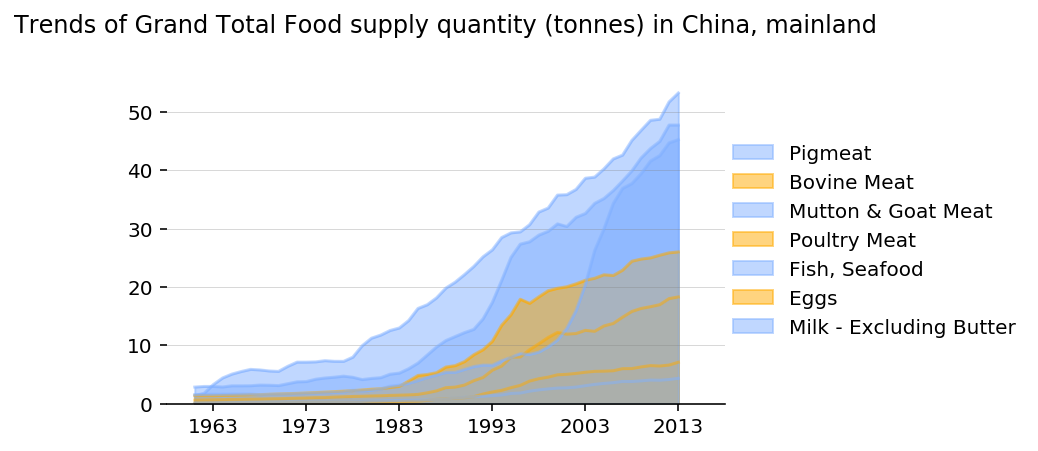

In [39]:
# 所有主要末梢类别, 加上末梢不重要但总类重要的总类
plotTrendsLine(A, E, items_group='Grand Total', 
               kind='area', colors=[GF_blue1, GF_amber2], alpha=0.5,
               toUnit='Million Tonnes', changeUnit = 1/1000000)
# plotTrendsLine(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000)
# plotTrendsBar(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000)

# # 设置颜色
# cmeat,cfish,cegg,cmilk,coffal,cfat=\
# 'peru','deepskyblue','yellowgreen','darkgray','firebrick','orange'
# cpig,ccattle,cgoat,cbirds,cother=\
# 'hotpink','maroon','orangered','gold','lightslategray'

# # 重要总类的分类
# plotTrends(D, A, E, items_group='Animal Products', 
#            toUnit='10,000 t', changeUnit = 1/10000,
#            colors=[cmeat,cfish,cegg,cmilk,coffal,cfat],
#           )
# plotTrends(D, A, E, items_group='Meat', 
#            toUnit='10,000 t', changeUnit = 1/10000,
#            colors=[cpig,ccattle,cgoat,cbirds,cother],
#           )

### 2. An Area's World Ranking of Some Items

In [31]:
def ranking_AreaItemInWorld(
    area,
    element,
    items_group='',
    items=[],
    area_list=LIST_countries,
    fig_size=FIG_size,
    colors=CLs,
):  
    
    items = getItems(element=element, items_group=items_group, items=items)
    
    # make a pivot for a particular area where 
    # year, items as columns, items' rankings in areas list as values
    rankings = {}
    for i in items:
        if i in PVs_AreaYear[element].keys():
            df = PVs_AreaYear[element][i].copy()
            ranks = np.array([])
            try: 
                df_areas = df[df.index.isin(area_list)]
                for year in df_areas.columns:
                    rank = df_areas.sort_values(year, ascending=False).index.tolist().index(area)+1
                    ranks = np.append(ranks,rank)
                rankings[i]=ranks
            except:continue           
    df_rank = pd.DataFrame(rankings)
    df_rank.index = Years
    
    # plot settings
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)
    
    title_y=1.15
    
    # === ploting ===
    title = "World Ranking of {} in {}".format(element.title(), area)
    fig = plt.figure(figsize = fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size, y=title_y)

    df_ = df_rank.loc[X_ticks]      
    display(df_)
    df_.plot.line(color=colors, linestyle=':', marker='o', linewidth=2, alpha=1, ax=plt.gca())

    ax = plt.gca()
    ax.legend(labels=rankings.keys(),fontsize=LEG_size,frameon=False,
             loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.gca().invert_yaxis()
    
    # save
#     path = './results/FAO_LivestockFish_CommodityBalance/img/Fig_1_' + title + '.png'
#     bbox = matplotlib.transforms.Bbox([[-1, -1], list(map(lambda x:x+2, list(fig_size)))])
#     fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
#     print('Img saved as: ' + path)

,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
1963,4.0,41.0,12.0,4.0,4.0,4.0,26.0
1973,2.0,28.0,7.0,4.0,4.0,4.0,27.0
1983,2.0,26.0,3.0,4.0,4.0,4.0,23.0
1993,2.0,7.0,2.0,3.0,2.0,2.0,16.0
2003,2.0,4.0,2.0,3.0,2.0,2.0,8.0
2013,2.0,4.0,2.0,2.0,2.0,2.0,4.0


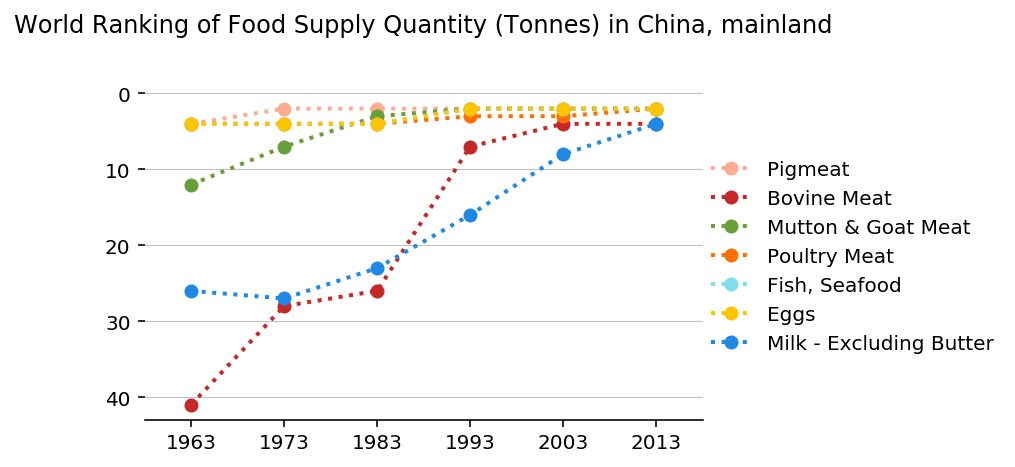

In [32]:
ranking_AreaItemInWorld(A,E)

### 3. Compare

#### World Map

In [33]:
# Map

countries = list(set(LIST_countries_OECD+LIST_countries_EU+LIST_countries_G20+LIST_countries_BRICS+USSR))+["USSR"]
print(f'OECD, EU, G20 and BRICS are considered. {len(countries)} in total.')
print(countries)

# countries = list(set(LIST_countries_OECD)) + China
# print(f'OECD and China are considered. {len(countries)} in total.')
# display(countries)

toUnit = 'Million Tonnes'
changeUnit = 1/1000000
years = [Years[-1]-50, Years[-1]-30, Years[-1]-10, Years[-1]]
fill_color_='OrRd'
items_group=''
items=[]
items = items = getItems(element=E, items_group=items_group, items=items)

df_all = {}
for i in items:
    df = PVs_AreaYear[E][i].copy()
    df = df[df.index.isin(countries)]
    df_all[i] = pd.DataFrame()
    for y in years:
        df_y = df[[y]].dropna()
        df_y = df_y * changeUnit
        df_all[i] = pd.concat([df_all[i], df_y], sort=True, axis=1)       

        title = f"{i} Production in {y} ({toUnit})"
        cn_map = folium.Map( width=1000, height=600, location=[0, 0], zoom_start=2, tiles='Mapbox Bright')
        threshold_scale = np.around(np.linspace(
            0, 
            df_y[y].values.max()+df_y[y].values.max()/20, 
            num=6, endpoint=True
        ),3)
    
        if y < 1992: geo_data_=f'{FAO_meta}/geojson/world_countries_before1992.json'
        elif y >= 1992: geo_data_=f'{FAO_meta}/geojson/world_countries.json'
        folium.Choropleth(
            geo_data=geo_data_,
            data=df_y,
            name = y,
            columns=[df_y.index, y],
            key_on='feature.properties.name',
            threshold_scale=threshold_scale,
            nan_fill_color='gray',
            fill_color=fill_color_,
            fill_opacity=1, 
            line_opacity=0.2,
            legend_name=title,
            show=False,
            highlight=False,
            reset=False
        ).add_to(cn_map)
        
        
#         display(cn_map) 

#         path = f'{LOCAL_ROOT}/results/{domain}/map/02-{title}.html'
#         cn_map.save(path)
#         print('Atala saved as: ' + path)

for i in items:
    display(df_all[i].head())

OECD, EU, G20 and BRICS are considered. 64 in total.
['Chile', 'Indonesia', 'Italy', 'Georgia', 'Hungary', 'Belarus', 'Mexico', 'South Africa', 'France', 'Romania', 'United Kingdom', 'Malta', 'China, mainland', 'Turkmenistan', 'Armenia', 'Austria', 'Switzerland', 'Russian Federation', 'Denmark', 'Russian FederationKazakhstan', 'Azerbaijan', 'Estonia', 'Greece', 'Spain', 'Finland', 'Cyprus', 'Iceland', 'Turkey', 'Saudi Arabia', 'Canada', 'Norway', 'Croatia', 'Luxembourg', 'Portugal', 'China, Hong Kong SAR', 'Czechia', 'United States of America', 'Republic of Korea', 'Netherlands', 'Tajikistan', 'Slovakia', 'China, Taiwan Province of', 'New Zealand', 'Sweden', 'Argentina', 'Poland', 'Israel', 'Japan', 'Australia', 'Brazil', 'Bulgaria', 'Lithuania', 'Slovenia', 'Ukraine', 'Uzbekistan', 'Republic of Moldova', 'China, Macao SAR', 'Kyrgyzstan', 'Latvia', 'India', 'Ireland', 'Germany', 'Belgium', 'USSR']


,1963,1983,2003,2013
Argentina,0.1481,0.2070,0.1946,0.4354
Armenia,NaN,NaN,0.0095,0.0288
Australia,0.1178,0.2358,0.4144,0.5635
Austria,0.2993,0.4570,0.4445,0.4465
Azerbaijan,NaN,NaN,0.0051,0.0024


,1963,1983,2003,2013
Argentina,1.8737,1.9746,2.1022,2.2996
Armenia,NaN,NaN,0.0423,0.0585
Australia,0.5654,0.7421,0.9081,0.7904
Austria,0.1421,0.1797,0.1516,0.1456
Azerbaijan,NaN,NaN,0.0714,0.1193


,1963,1983,2003,2013
Argentina,0.1226,0.1021,0.0609,0.0646
Armenia,NaN,NaN,0.0062,0.0090
Australia,0.4630,0.3156,0.2679,0.2305
Austria,0.0030,0.0043,0.0091,0.0099
Azerbaijan,NaN,NaN,0.0393,0.0710


,1963,1983,2003,2013
Argentina,0.0620,0.3586,0.7463,1.6023
Armenia,NaN,NaN,0.0183,0.0397
Australia,0.0509,0.3112,0.6906,1.0767
Austria,0.0456,0.0847,0.1365,0.1581
Azerbaijan,NaN,NaN,0.0296,0.0990


,1963,1983,2003,2013
Argentina,0.1109,0.1735,0.2787,0.2922
Armenia,NaN,NaN,0.0024,0.0130
Australia,0.0963,0.2302,0.4942,0.6091
Austria,0.0516,0.0514,0.0894,0.1179
Azerbaijan,NaN,NaN,0.0114,0.0201


,1963,1983,2003,2013
Argentina,0.1241,0.2473,0.2615,0.4721
Armenia,NaN,NaN,0.0250,0.0348
Australia,0.1242,0.1797,0.0997,0.1986
Austria,0.1002,0.1064,0.1043,0.1247
Azerbaijan,NaN,NaN,0.0357,0.0773


,1963,1983,2003,2013
Argentina,3.1130,4.8806,6.2531,8.0852
Armenia,NaN,NaN,0.3865,0.6223
Australia,2.6235,3.5667,4.1919,5.4738
Austria,1.5559,1.9252,1.9926,2.1925
Azerbaijan,NaN,NaN,0.7877,1.4314


#### Compare with OECD

In [40]:
items = ITEMs.copy()
X_step=10
X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

In [41]:
def sumOfGroup (
    element,
    areas_list,
    items_group='',
    items=[],
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df_res = pd.DataFrame()
    for i in items:
        df = PVs_YearArea[element][i].copy()
        
        areas = []
        for c in df.columns:
            if c in areas_list: areas.append(c)
        df = df[areas]
        df = df.fillna(np.nan)

        df['Sum'] = df.apply(lambda x: x.sum(), axis=1)
            
        df = df['Sum']
        df_res = pd.concat([df_res, df],axis=1)
        
    df_res.columns = items
    df_res.index.names = ['Year']
    return df_res

In [44]:
DATA_OECD = sumOfGroup(E, areas_list=LIST_countries_OECD, items=items)
DATA_area = trendsOfArea(A, E, items=items)
DATA_world = trendsOfArea('World', E, items=items)

toUnit='Million Tonnes'
changeUnit=1/1000000
area = A

df_world = DATA_world.copy() * changeUnit
df_OECD = DATA_OECD.copy() * changeUnit
df_area = DATA_area.copy() * changeUnit

print('World: ')
display(df_world.head())
print('OECD: ')
display(df_OECD.head())
print(f'{A}: ')
display(df_area.head())

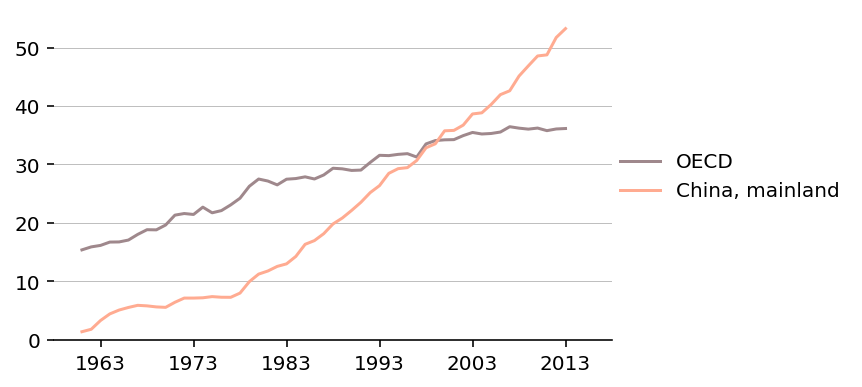

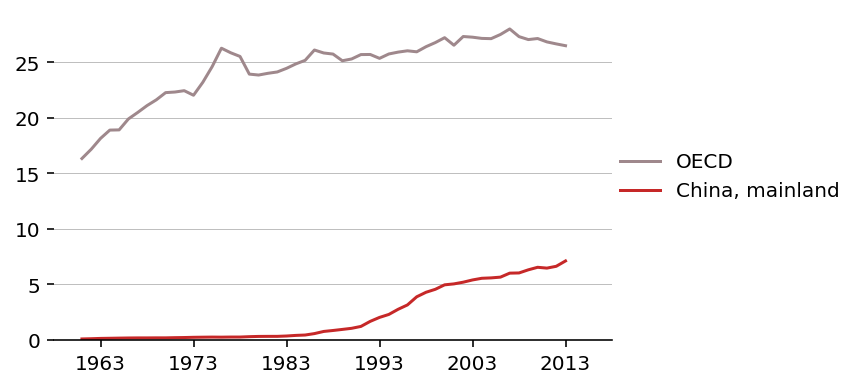

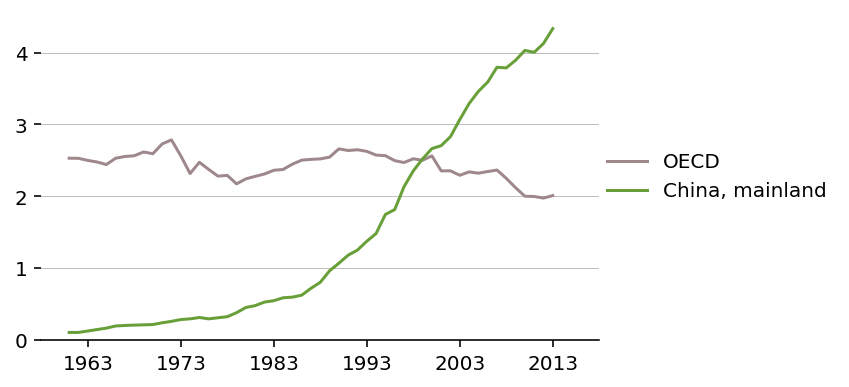

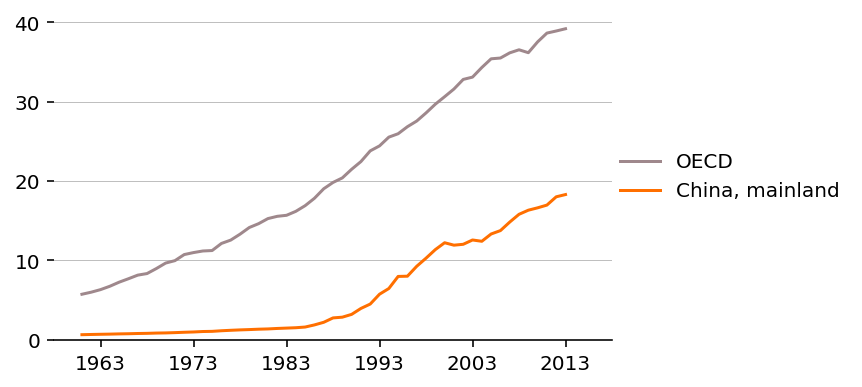

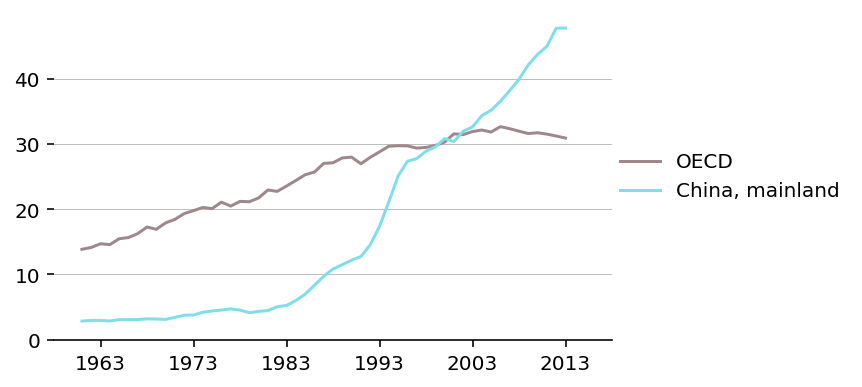

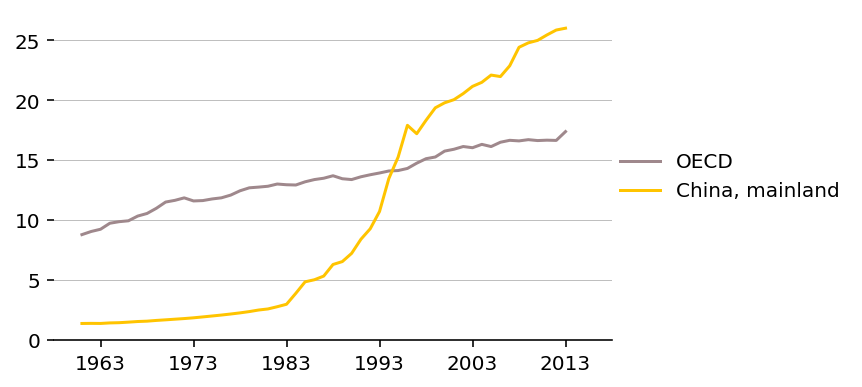

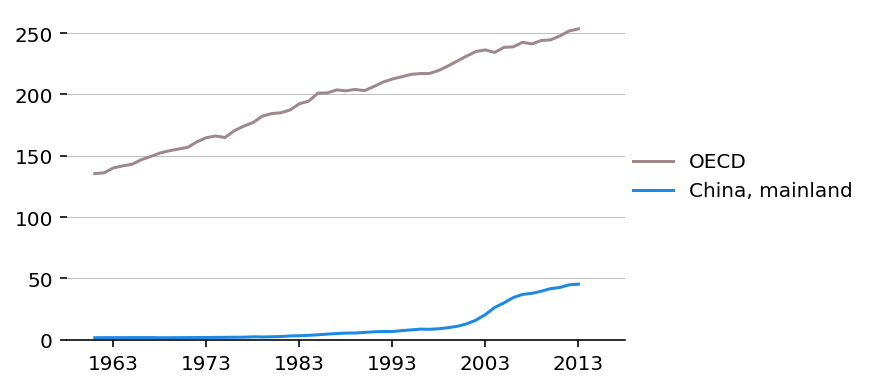

In [45]:
# ==== Line
colors = CLs
for i, c in zip(items, colors):
    
    title = ""
    fig = plt.figure(figsize = FIG_size,dpi=DPI)
    plt.title(title, fontsize=TIT_size)
    
    df_OECD[i].plot(color=GF_brand_gray, ax=plt.gca())
    df_area[i].plot(color=c, ax=plt.gca())
    
    ax = plt.gca()
    ax.legend(labels=['OECD', area],fontsize=LEG_size,frameon=False,
             loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [46]:
df_world=df_world.loc[X_ticks]
df_OECD=df_OECD.loc[X_ticks]
df_area=df_area.loc[X_ticks]

print('World: ')
display(df_world.head())
print('OECD: ')
display(df_OECD.head())
print(f'{A}: ')
display(df_area.head())

World: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
1963,27.7641,31.5583,5.9711,9.5998,30.0850,14.3650,240.7931
1973,40.3817,39.8593,6.4276,17.2473,44.6521,19.9400,287.1111
1983,54.7101,47.9856,7.4320,28.4599,54.9256,26.2317,355.8169
1993,72.9159,53.0358,9.4981,46.7701,73.5300,36.1935,406.1924
2003,91.1283,58.6942,11.2000,73.4201,102.3951,51.6302,504.1957


OECD: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
Year,,,,,,,
1963,16.1263,18.1308,2.4987,6.2992,14.6919,9.2136,140.0903
1973,21.4244,22.0217,2.5631,10.9695,19.7743,11.5769,164.7612
1983,27.4615,24.4466,2.3609,15.6677,23.5384,12.9290,192.4467
1993,31.5524,25.3466,2.6249,24.4166,28.7805,13.9110,212.6204
2003,35.4658,27.2542,2.2915,33.0865,31.8925,16.0202,236.3655


China, mainland: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
1963,3.2688,0.1070,0.1200,0.6695,2.9424,1.3486,1.6081
1973,7.1100,0.2065,0.2795,0.9613,3.7799,1.8193,1.7449
1983,12.9687,0.3241,0.5424,1.4504,5.2362,2.9510,3.1632
1993,26.3643,2.0006,1.3712,5.7215,17.3666,10.6957,6.5804
2003,38.6324,5.3763,3.0679,12.5562,32.5987,21.1417,20.4400


In [48]:
def areaInWorld(
    df_area_,
    df_total_,
    colors=CLs,
):

    fig_size = (8,4)

    fig = plt.figure(figsize = fig_size, dpi=DPI)
    fig.tight_layout()                          
    plt.subplots_adjust(hspace =0.1)
    
    title = ""

    ax2 = fig.add_subplot(211)
    plt.title(title, fontsize=TIT_size)

    df_total_.plot.bar(color='gray', width=0.8, edgecolor='black', linewidth=0.5, alpha=0.2, ax=ax2)
    df_area_.plot.bar(color=colors, width=0.8, ax=ax2)

    ax2.legend_.remove()
    ax2.xaxis.label.set_visible(False)
    ax2.set_xticklabels(X_ticks, rotation=0, ha='center')
    ax2.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    plt.xticks([])
    ax2.set_ylim(175, 800)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax1 = fig.add_subplot(212)

    df_total_.plot.bar(color='gray', width=0.8, edgecolor='black', linewidth=0.5, alpha=0.2, ax=ax1)
    df_area_.plot.bar(color=colors, width=0.8, ax=ax1)

    ax1.legend_.remove()
    ax1.xaxis.label.set_visible(False)
    ax1.set_xticklabels(X_ticks, rotation=0, ha='center')
    ax1.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax1.set_ylim(0, 175)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)

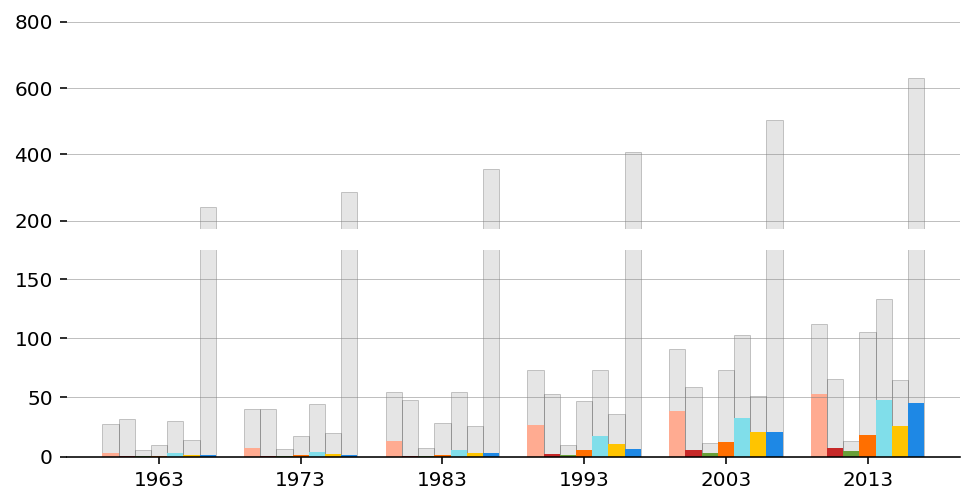

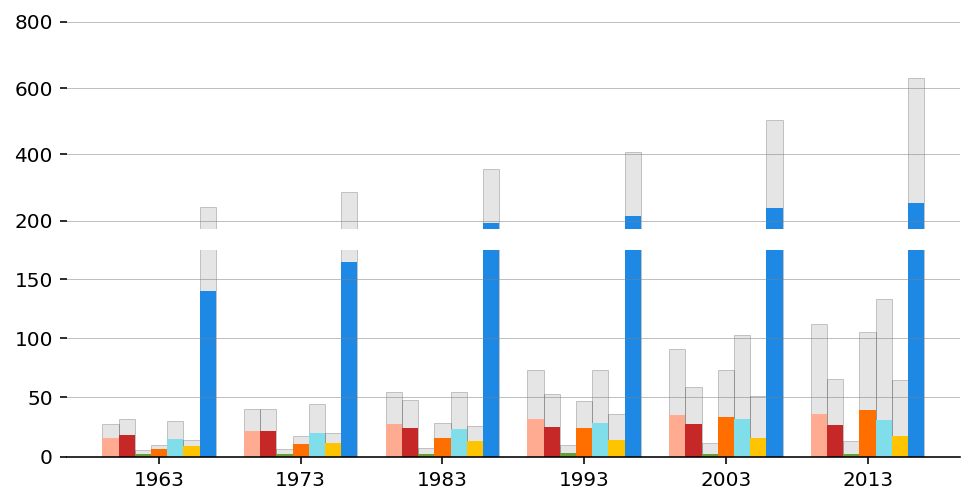

In [49]:
areaInWorld(df_area_=df_area.copy(), df_total_=df_world)
areaInWorld(df_area_=df_OECD.copy(), df_total_=df_world)

In [50]:
percent_world = pd.DataFrame()
percent_OECD = pd.DataFrame()
percent_area = pd.DataFrame()

percent_world['Year'] = X_ticks
percent_OECD['Year'] = X_ticks
percent_area['Year'] = X_ticks

percent_world.set_index('Year', inplace=True)
percent_OECD.set_index('Year', inplace=True)
percent_area.set_index('Year', inplace=True)

for i in items:
    percent_world[i] = np.array(df_world[i]/df_world[i])*100
    percent_OECD[i] = np.array(df_OECD[i]/df_world[i])*100
    percent_area[i] = np.array(df_area[i]/df_world[i])*100

print('World: ')
display(percent_world.head())
print('OECD: ')
display(percent_OECD.head())
print(f'{A}: ')
display(percent_area.head())

World: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
Year,,,,,,,
1963,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1973,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1983,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1993,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2003,100.0,100.0,100.0,100.0,100.0,100.0,100.0


OECD: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
Year,,,,,,,
1963,58.0834,57.4517,41.8461,65.6184,48.8345,64.1392,58.1787
1973,53.0547,55.2486,39.8771,63.6010,44.2852,58.0587,57.3859
1983,50.1946,50.9456,31.7670,55.0519,42.8551,49.2876,54.0859
1993,43.2723,47.7916,27.6364,52.2055,39.1412,38.4351,52.3448
2003,38.9185,46.4343,20.4595,45.0646,31.1465,31.0287,46.8797


China, mainland: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
Year,,,,,,,
1963,11.7736,0.3391,2.0097,6.9745,9.7803,9.3882,0.6679
1973,17.6070,0.5181,4.3485,5.5736,8.4651,9.1238,0.6077
1983,23.7044,0.6755,7.2982,5.0963,9.5332,11.2496,0.8890
1993,36.1571,3.7722,14.4365,12.2332,23.6184,29.5514,1.6200
2003,42.3934,9.1599,27.3917,17.1018,31.8362,40.9484,4.0540


In [64]:
def areaInWorldPercent(
    df_area_,
    df_total_,
    colors=CLs,
):

    fig_size = (8,4)

    title = ""
    fig = plt.figure(figsize = fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size)

    df_total_.plot.bar(color='gray', width=0.8, edgecolor='black', linewidth=0.5, alpha=0.2, ax=plt.gca())
    df_area_.plot.bar(color=colors, width=0.8, ax=plt.gca())

    ax=plt.gca()
    ax.legend_.remove()
    ax.xaxis.label.set_visible(False)
    ax.set_xticklabels(X_ticks, rotation=0, ha='center')
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

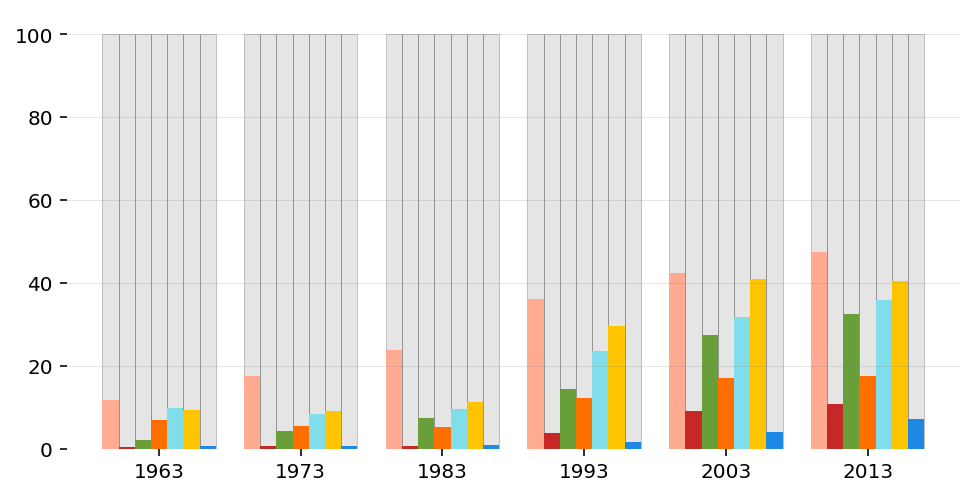

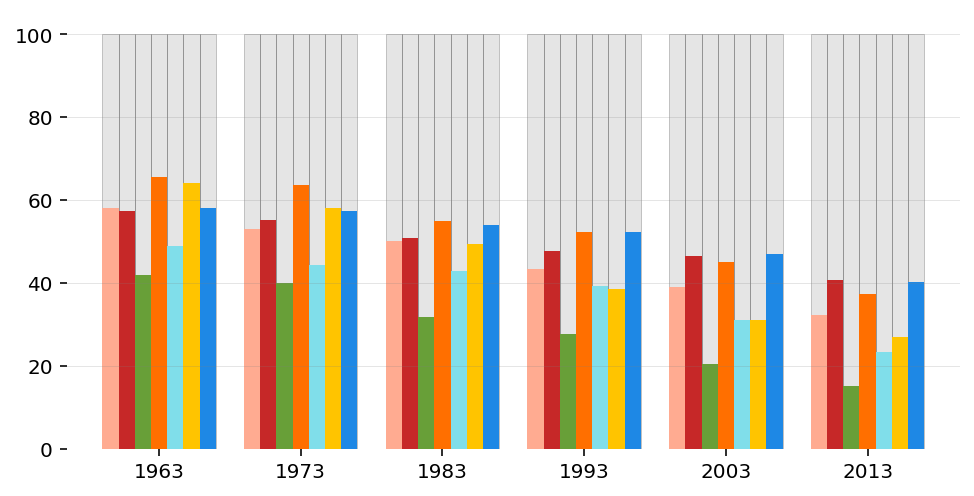

In [65]:
areaInWorldPercent(df_area_=percent_area.copy(), df_total_=percent_world)
areaInWorldPercent(df_area_=percent_OECD.copy(), df_total_=percent_world)

In [59]:
def plotPieCompare(
    df_area_,
    df_total_,
    element=E,
    area_=A,
    total_='World',
    years=[1963, 2013],
    colors=CLs,
    fig_size = (12,6),
):
    
    title = "Proportions of Different {} in {} and the Proportions {} takes".format(element, total_, area_)

    # plot all items in the world...

    fig = plt.figure(figsize = fig_size,dpi=300)
    fig.tight_layout()                          
    plt.subplots_adjust(wspace =0.3, hspace =0.2)
    plt.suptitle(title, fontsize=TIT_size)

    df_compare = {}
    fig_no=0
    for y in years:
        fig_no+=1

        df_compare[y] = pd.concat([df_area_.loc[y].transpose(), df_total_.loc[y].transpose()], axis=1)
        df_compare[y].columns = [area_, total_]
        df_compare[y]['Others'] = df_compare[y][total_]-df_compare[y][area_]
        print(y, area_)
        display(df_compare[y])

        df = df_compare[y].copy()

        ax = fig.add_subplot(1,2, fig_no)
        plt.title(y, fontsize=TIT_size)

        size = 0.5
        outer_radius = 2
        inner_colors = [GF_brand_gray, Gray1]

        outer_explode = np.zeros(len(items))
        inner_explode = np.zeros(len(items*2))

# #         Explode Items
#         for n in range(len(items)):
#             if items[n] in ITEMs_main:
#                 outer_explode[n] = 0.15
#                 inner_explode[2*n] = 0.15

        area_pct = ['{}{}'.format(int(df.loc[i][area_]/df.loc[i][total_]*100),'%') for i in df.index.values]
        inner_labels = []
        for i in area_pct:
            inner_labels.append(i)
            inner_labels.append('')

        shadow = False
        startangle = 0
        plt.pie(df[total_].values, 
                autopct='%1.0f%%',
                pctdistance=1.1,
#                 explode=list(outer_explode),
                radius=outer_radius, 
                colors=colors,
                center = (0,0),
                textprops = {'fontsize':LEG_size}, 
                wedgeprops=dict(width=size),
                shadow=shadow,
                startangle=startangle,
                )
        plt.pie(df[[area_,'Others']].values.flatten(), 
                labels=inner_labels,
                labeldistance = 0.85,
#                 explode=list(inner_explode),
                radius=outer_radius-size, 
                colors=inner_colors,
                center = (0,0),
                textprops = {'fontsize':LEG_size}, 
                wedgeprops=dict(width=size),
                shadow=shadow,
                startangle=startangle,
               )
        plt.axis('equal')          # equal 使得为正圆

    ax=plt.gca()
    ax.legend(labels=list(df.index.values)+[area_,'Other'],frameon=False,fontsize=LEG_size, 
              loc='lower center',bbox_to_anchor=(-0.1,-0.1),borderaxespad = 0.)

    #     path = './results/FAO_LivestockFish_FoodSupplyQuantity/img/Fig_5_'  + title[:title.find('\/')] + '.png'
    #     bbox = matplotlib.transforms.Bbox([[-1, -1], list(map(lambda x:x+2, list(fig_size)))])
    #     fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
    #     print('Img saved as: ' + path)

1963 China, mainland


,"China, mainland",World,Others
Pigmeat,3.2688,27.7641,24.4953
Bovine Meat,0.1070,31.5583,31.4513
Mutton & Goat Meat,0.1200,5.9711,5.8511
Poultry Meat,0.6695,9.5998,8.9302
"Fish, Seafood",2.9424,30.0850,27.1426
Eggs,1.3486,14.3650,13.0164
Milk - Excluding Butter,1.6081,240.7931,239.1849


2013 China, mainland


,"China, mainland",World,Others
Pigmeat,53.2470,112.1043,58.8572
Bovine Meat,7.0895,65.2180,58.1285
Mutton & Goat Meat,4.3365,13.3871,9.0506
Poultry Meat,18.2836,104.8740,86.5904
"Fish, Seafood",47.7536,132.8287,85.0751
Eggs,25.9991,64.3317,38.3326
Milk - Excluding Butter,45.2522,629.7453,584.4931


1963 OECD


,OECD,World,Others
Pigmeat,16.1263,27.7641,11.6378
Bovine Meat,18.1308,31.5583,13.4275
Mutton & Goat Meat,2.4987,5.9711,3.4724
Poultry Meat,6.2992,9.5998,3.3005
"Fish, Seafood",14.6919,30.0850,15.3932
Eggs,9.2136,14.3650,5.1514
Milk - Excluding Butter,140.0903,240.7931,100.7028


2013 OECD


,OECD,World,Others
Pigmeat,36.1397,112.1043,75.9646
Bovine Meat,26.4861,65.2180,38.7320
Mutton & Goat Meat,2.0086,13.3871,11.3785
Poultry Meat,39.1835,104.8740,65.6905
"Fish, Seafood",30.8936,132.8287,101.9352
Eggs,17.3672,64.3317,46.9645
Milk - Excluding Butter,253.5350,629.7453,376.2103


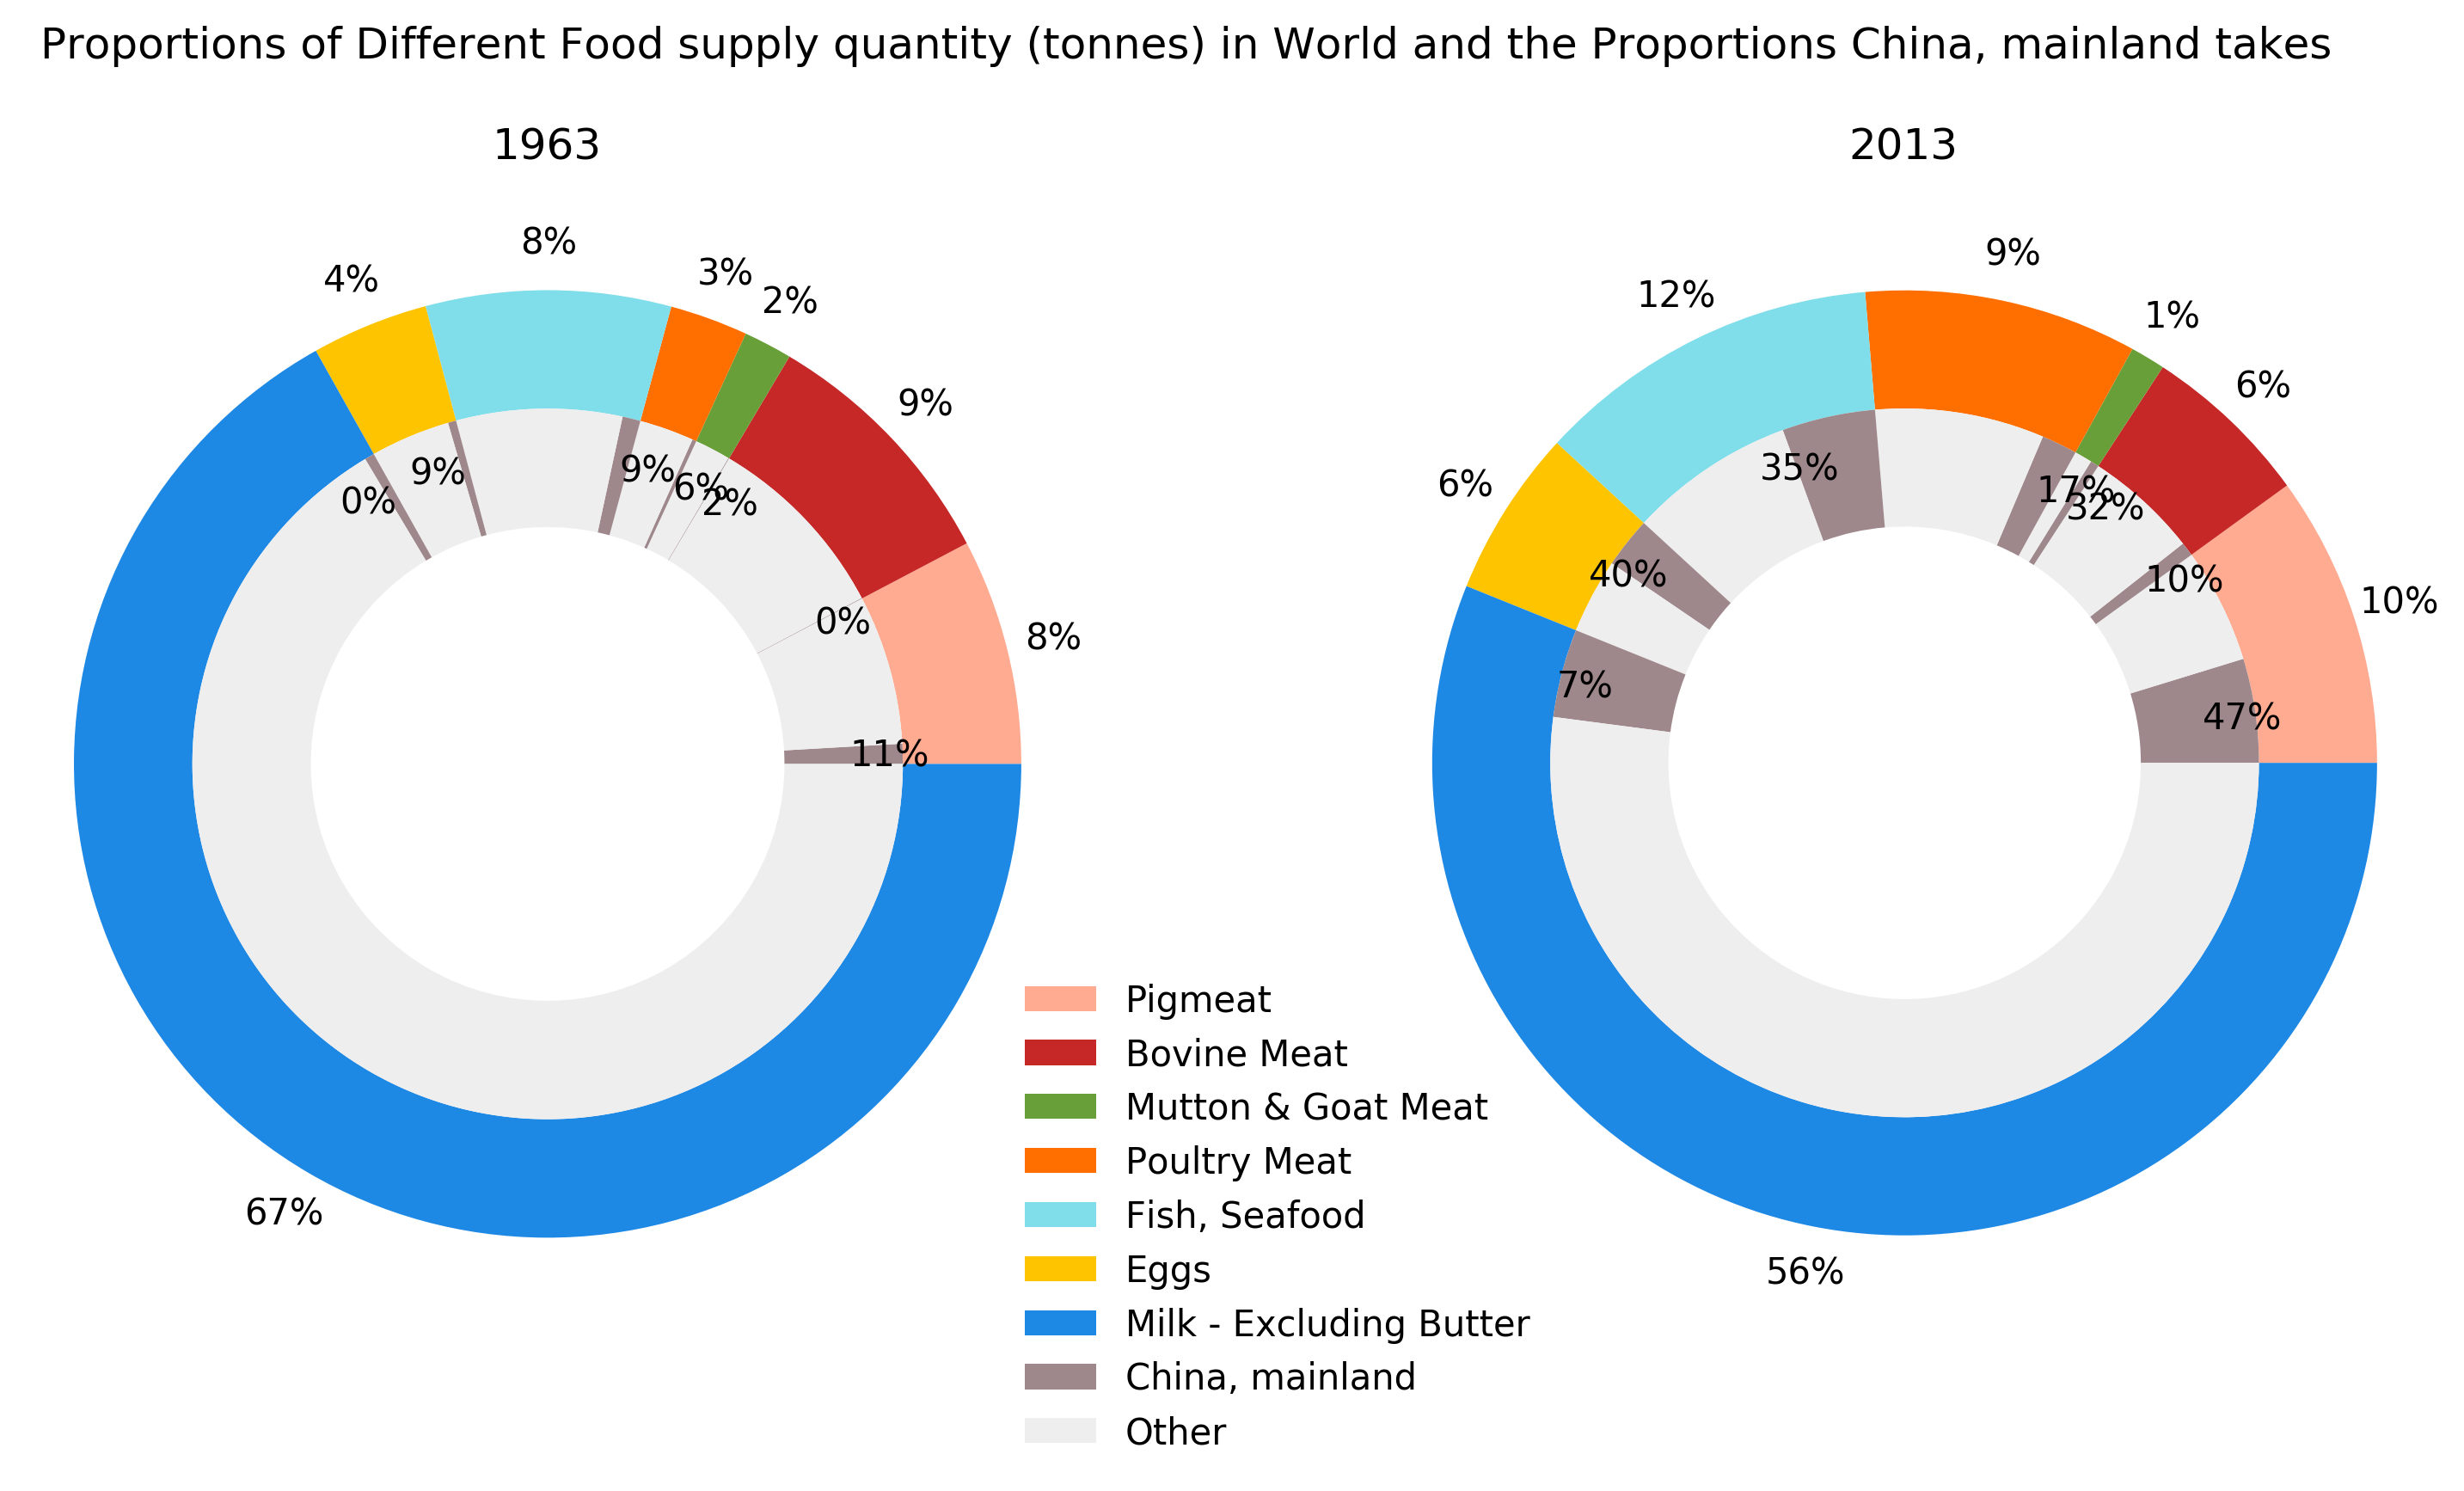

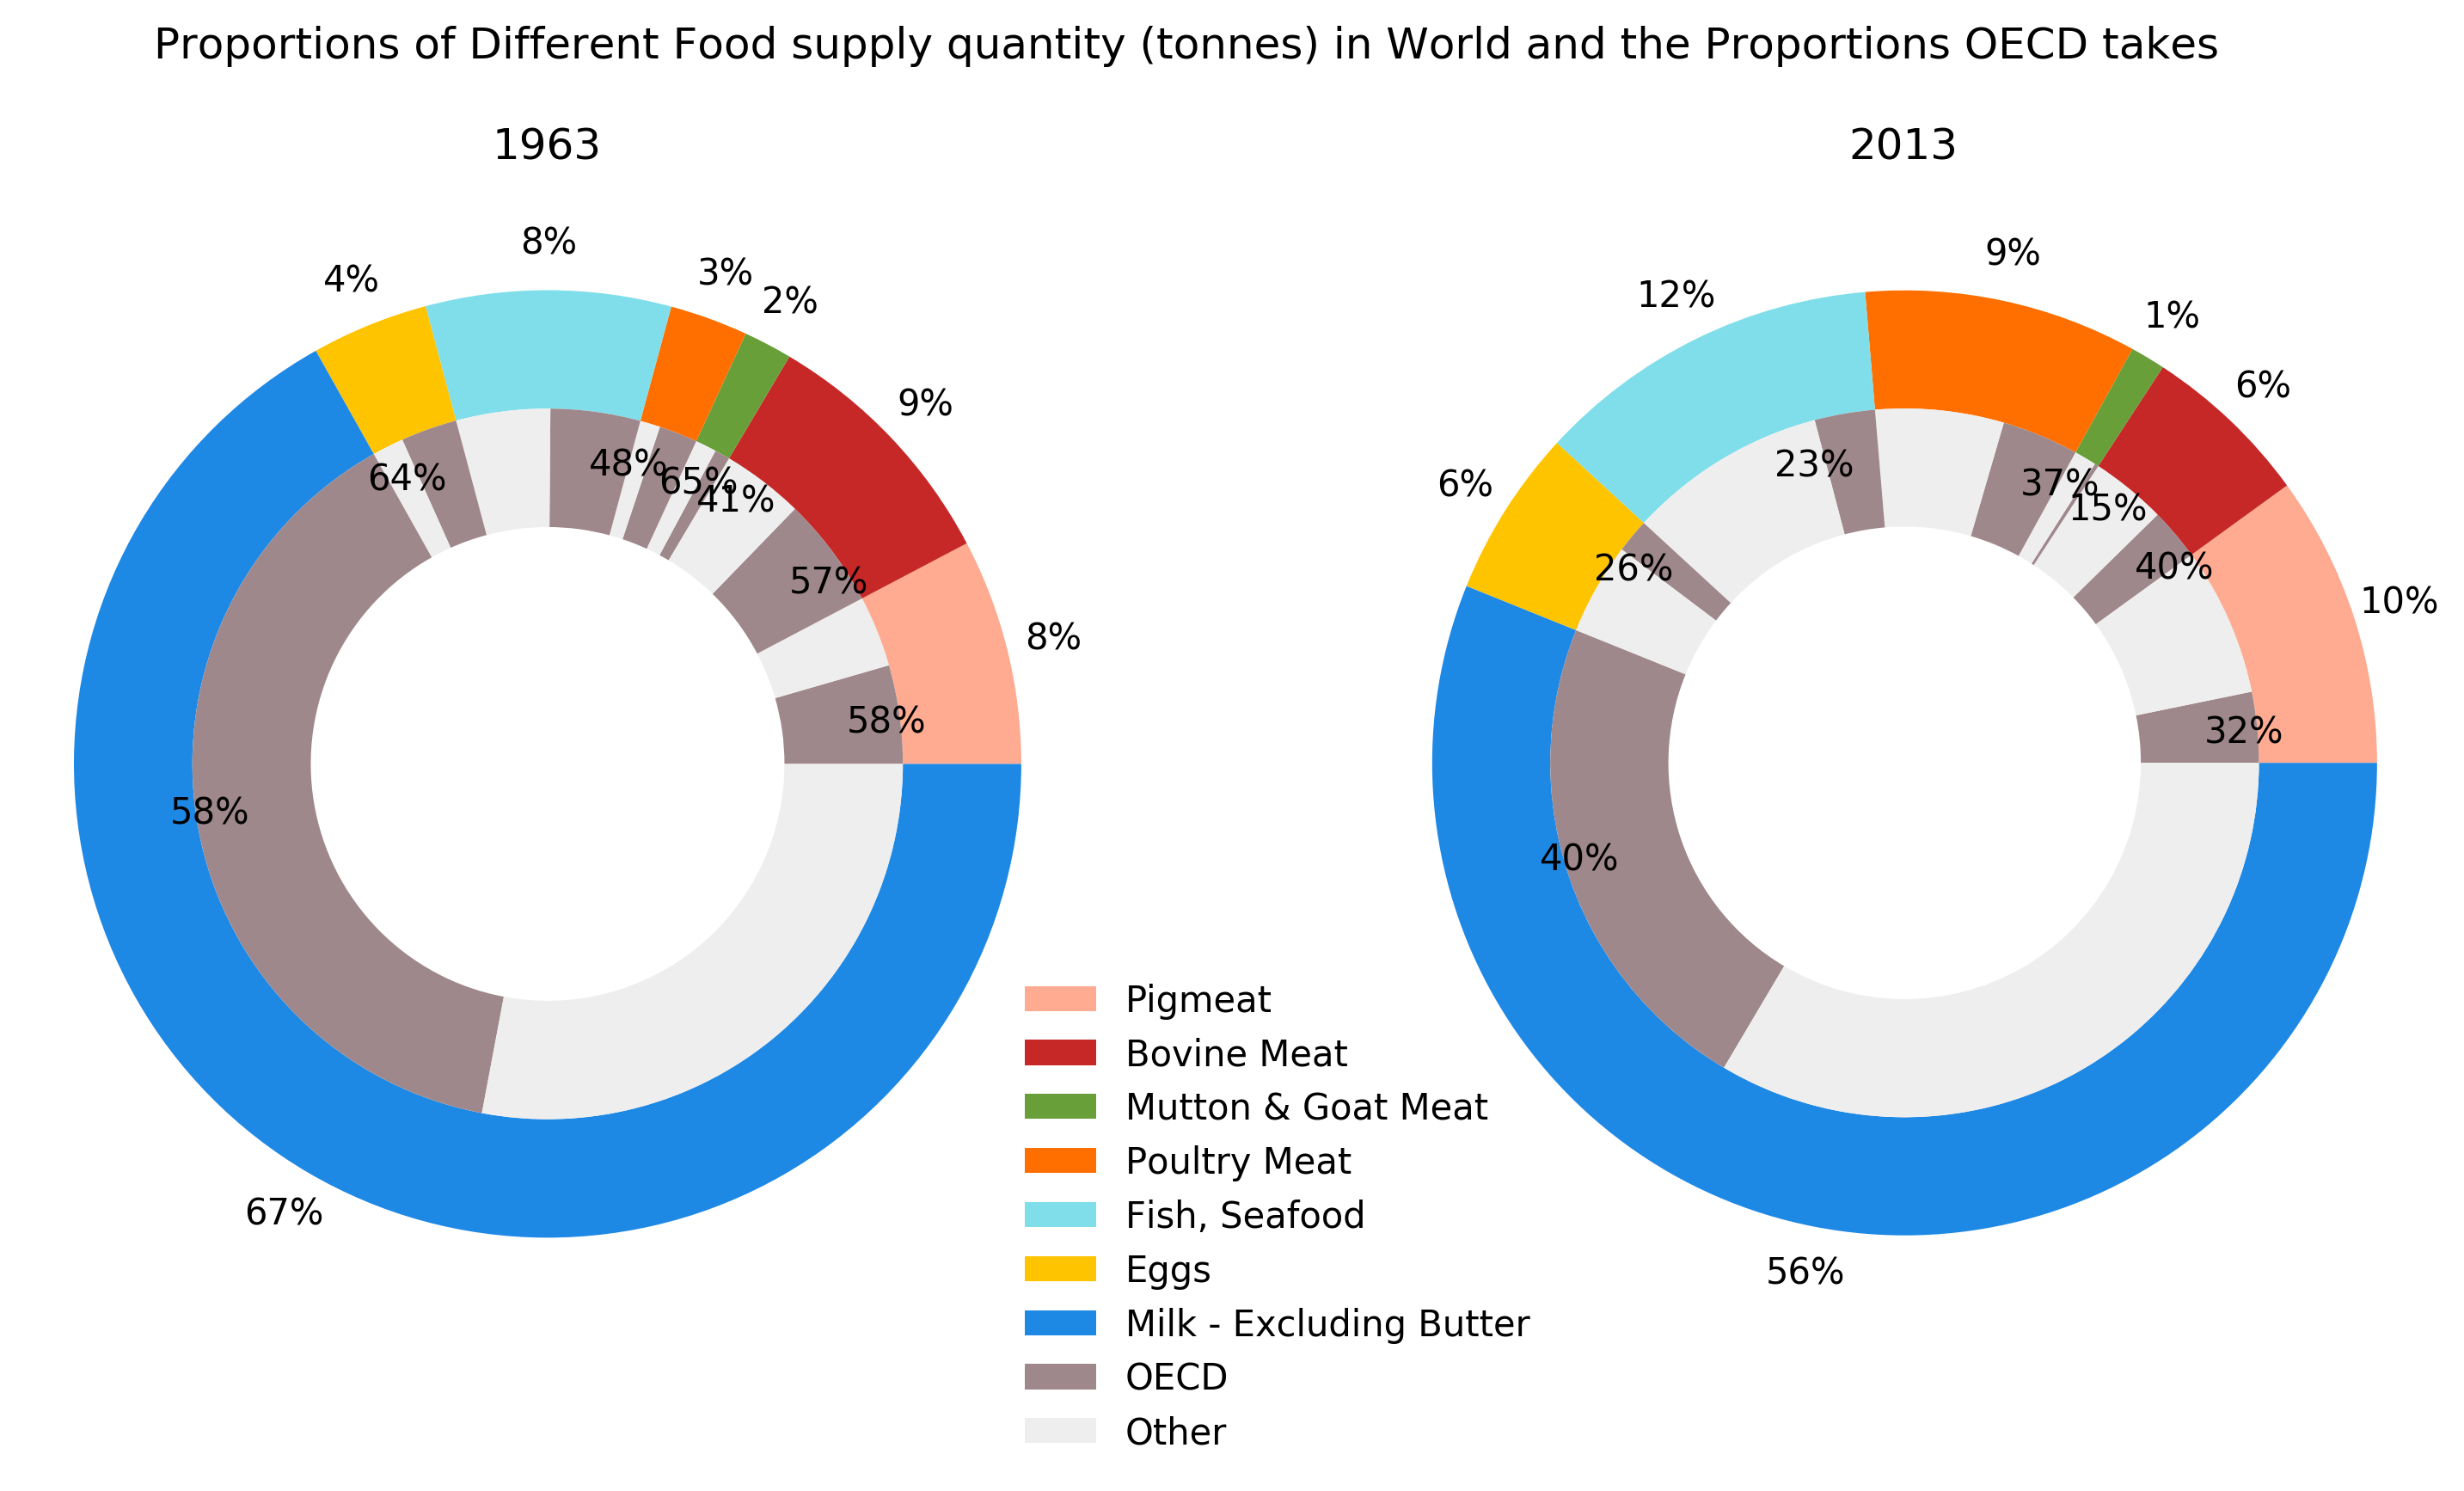

In [60]:
# China
# 设置主要贡献方面
# ITEMs_main = ['Pigmeat', 'Fish, Seafood', 'Eggs']

plotPieCompare(
    df_area_=df_area.copy(),
    df_total_=df_world.copy(),
    element=E,
    area_=A,
    total_='World',
    years=[1963, 2013],
    fig_size = (12,6),
)

# OECD
# 设置主要贡献方面
# ITEMs_main = ['Milk - Excluding Butter', 'Bovine Meat', 'Poultry Meat']

plotPieCompare(
    df_area_=df_OECD.copy(),
    df_total_=df_world.copy(),
    element=E,
    area_='OECD',
    total_='World',
    years=[1963, 2013],
    fig_size = (12,6),
)

#### Compare with Top 5

In [66]:
def compareToTopAreas(
    area,
    element,
    items_group='',
    items=[],
    toUnit='',
    changeUnit=1,
): 
    items = getItems(element=element, items_group=items_group, items=items)

    dfs = PVs_AreaYear[element]
    
    years = X_ticks
    
    if toUnit=='': Y_label = element
    else: 
        if '(' in element: Y_label = element[:element.find('(')] + '({})'.format(toUnit)
        else: Y_label = element + ' ({})'.format(toUnit)
    title = '{}: China, mainland Vs. Top 5 in the World'.format(element)

    # === Bar Plot ===
    for i, c in zip(items, colors):
        fig_size=(8,4)
        fig=plt.figure(figsize=fig_size, dpi=DPI)
        
        df = dfs[i][dfs[i].index.isin(LIST_countries)].copy()
        df = df * changeUnit
        df = df.dropna()
        
        df_area = df[df.index==area][years]
        df_top = df.sort_values([years[-1]],ascending=False)[years].head()
        
        display(df_top)
                    
        if area in df_top.index:
            df_top.plot.bar(color=c, width=0.8, edgecolor='black', linewidth=0.5, ax=plt.gca(), )
#             n=1
#             for y in df_top.columns:
#                 width=0.2
#                 plt.bar(x=n+n*width, height=df_top[y], color=c, width=width, alpha=0+n*0.15)
#                 n+=1
                    
            ax=plt.gca()
            
            for p in ax.patches[0:5]:
                p.set_hatch(hatch='..')
            for p in ax.patches[5:10]:
                p.set_hatch(hatch='//')
            for p in ax.patches[10:15]:
                p.set_hatch(hatch='---')
            for p in ax.patches[15:20]:
                p.set_hatch(hatch='xx')
            for p in ax.patches[20:25]:
                p.set_hatch(hatch='O')
            for p in ax.patches[25:30]:
                p.set_hatch(hatch='+++')
            
            ax.legend(fontsize=LEG_size,frameon=False,
                     loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
            ax.xaxis.label.set_visible(False)
            ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
            ax.set_ylim(0,)
            ax.spines['bottom'].set_visible(True)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
        else: 

            df_top.plot.bar(ax=plt.gca())

            ax=plt.gca()
            ax.legend(fontsize=LEG_size,frameon=False,
                     loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
            ax.xaxis.label.set_visible(False)
            ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
            ax.set_ylim(0,)
            ax.spines['bottom'].set_visible(True)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)

        
#     path = './results/FAO_LivestockFish_CommodityBalance/img/Fig_3_'+title+'.png'
#     bbox = matplotlib.transforms.Bbox([[-1, -1], list(map(lambda x:x+2, list(fig_size)))])
#     fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
#     print('Img saved as: ' + path)

,1963,1973,1983,1993,2003,2013
Area,,,,,,
China,3.5793,7.7364,13.8557,27.5153,39.9715,54.6894
"China, mainland",3.2688,7.1100,12.9687,26.3643,38.6324,53.2470
United States of America,5.6952,5.9225,7.0214,7.8685,8.8220,8.8471
Germany,2.7709,3.8826,4.7838,4.4012,4.4801,4.2864
Viet Nam,0.2600,0.2800,0.5099,0.8583,1.7857,3.2086


,1963,1973,1983,1993,2003,2013
Area,,,,,,
United States of America,8.5065,10.6996,11.4782,11.0163,12.3286,11.5983
Brazil,1.3317,2.0170,2.8045,4.3941,6.0593,7.8633
China,0.1417,0.2670,0.4297,2.1575,5.5679,7.4029
"China, mainland",0.1070,0.2065,0.3241,2.0006,5.3763,7.0895
Argentina,1.8737,1.6126,1.9746,2.2002,2.1022,2.2996


,1963,1973,1983,1993,2003,2013
Area,,,,,,
China,0.1213,0.2816,0.5499,1.3909,3.1006,4.3743
"China, mainland",0.1200,0.2795,0.5424,1.3712,3.0679,4.3365
India,0.3828,0.3810,0.5056,0.6252,0.6849,0.7252
Nigeria,0.0147,0.0345,0.1095,0.1812,0.3768,0.4719
Pakistan,0.1135,0.1760,0.3190,0.5948,0.5027,0.4484


,1963,1973,1983,1993,2003,2013
Area,,,,,,
China,0.7494,1.1457,1.9337,6.5758,13.6112,19.4489
"China, mainland",0.6695,0.9613,1.4504,5.7215,12.5562,18.2836
United States of America,3.2357,4.6554,6.8179,11.3041,14.5409,16.0061
Brazil,0.1660,0.5246,1.3231,2.7038,5.8916,9.0162
Mexico,0.1556,0.2723,0.5234,1.2608,2.6451,3.6850


,1963,1973,1983,1993,2003,2013
Area,,,,,,
China,3.3972,4.5612,6.1314,18.5509,33.8226,49.1138
"China, mainland",2.9424,3.7799,5.2362,17.3666,32.5987,47.7536
Indonesia,0.9241,1.2138,2.0675,3.1152,4.5786,7.0393
United States of America,2.5404,3.3134,4.1374,5.9937,7.0166,6.8834
India,0.9869,1.7060,2.2552,3.7561,5.2019,6.3104


,1963,1973,1983,1993,2003,2013
Area,,,,,,
China,1.4024,1.9250,3.1672,10.9979,21.5395,26.4171
"China, mainland",1.3486,1.8193,2.9510,10.6957,21.1417,25.9991
United States of America,3.4239,3.5204,3.5752,3.5243,4.3034,4.6673
India,0.1606,0.3490,0.6198,1.1345,1.8647,3.2306
Japan,0.9810,1.7611,1.9844,2.5000,2.4488,2.4346


,1963,1973,1983,1993,2003,2013
Area,,,,,,
India,17.1503,20.0983,33.6883,50.0936,68.0842,105.8072
United States of America,50.2601,53.1383,58.8024,67.0166,76.4217,81.5127
China,1.7382,2.1151,3.9615,7.9228,21.7256,47.0092
"China, mainland",1.6081,1.7449,3.1632,6.5804,20.4400,45.2522
Pakistan,5.3853,6.7069,8.6003,14.4969,23.6694,33.3564


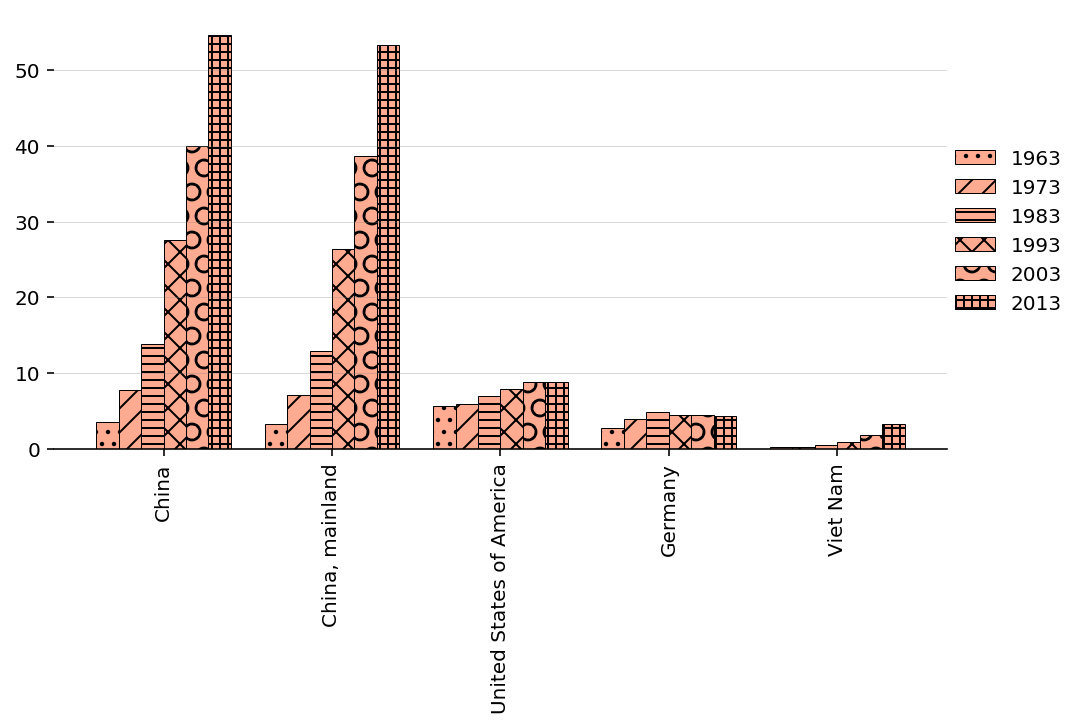

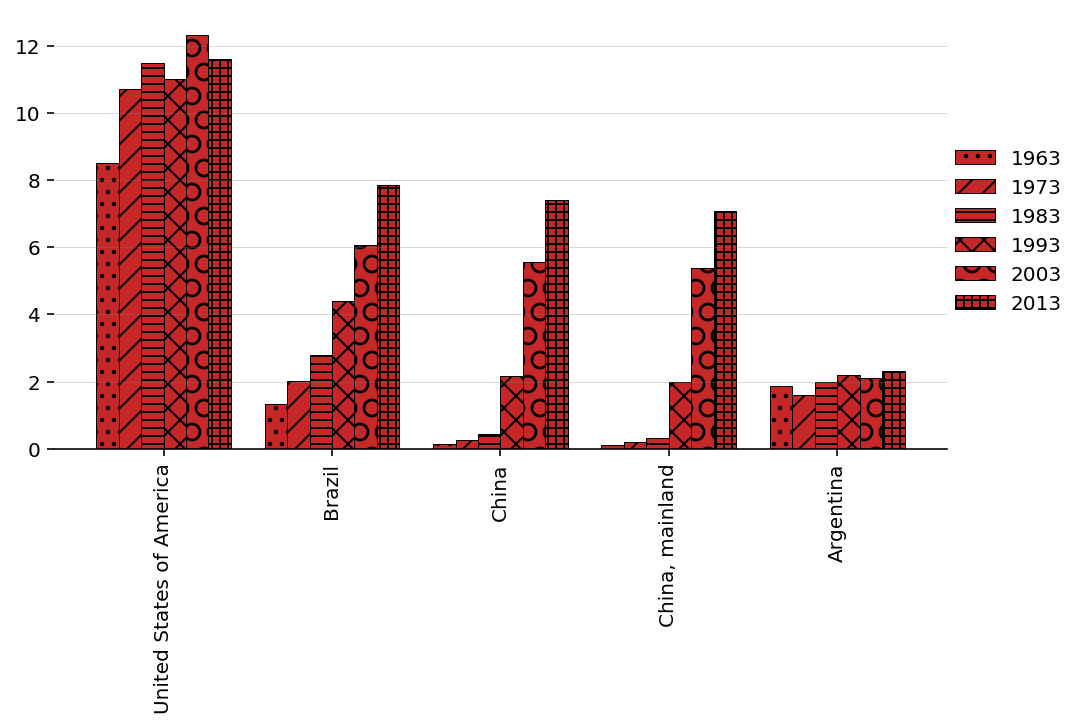

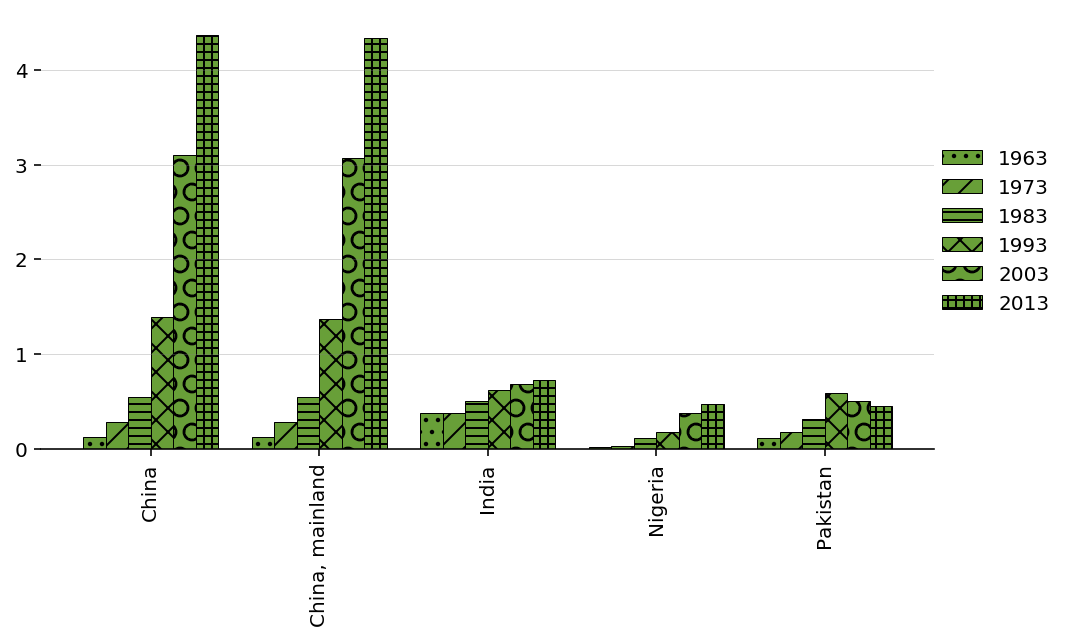

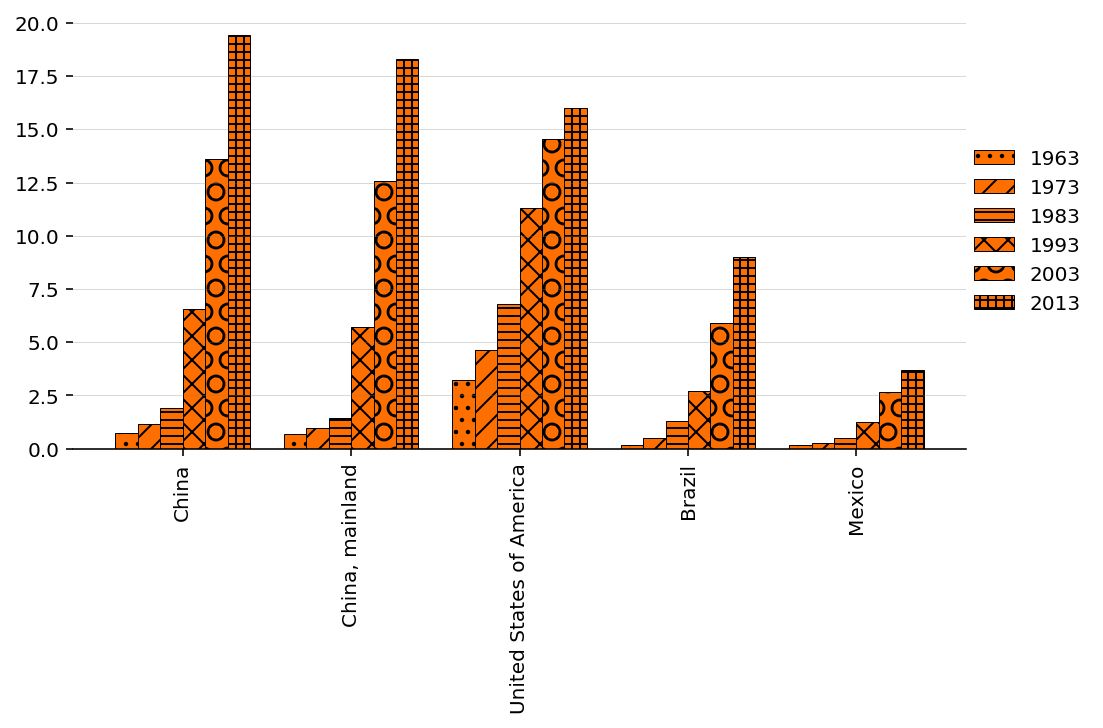

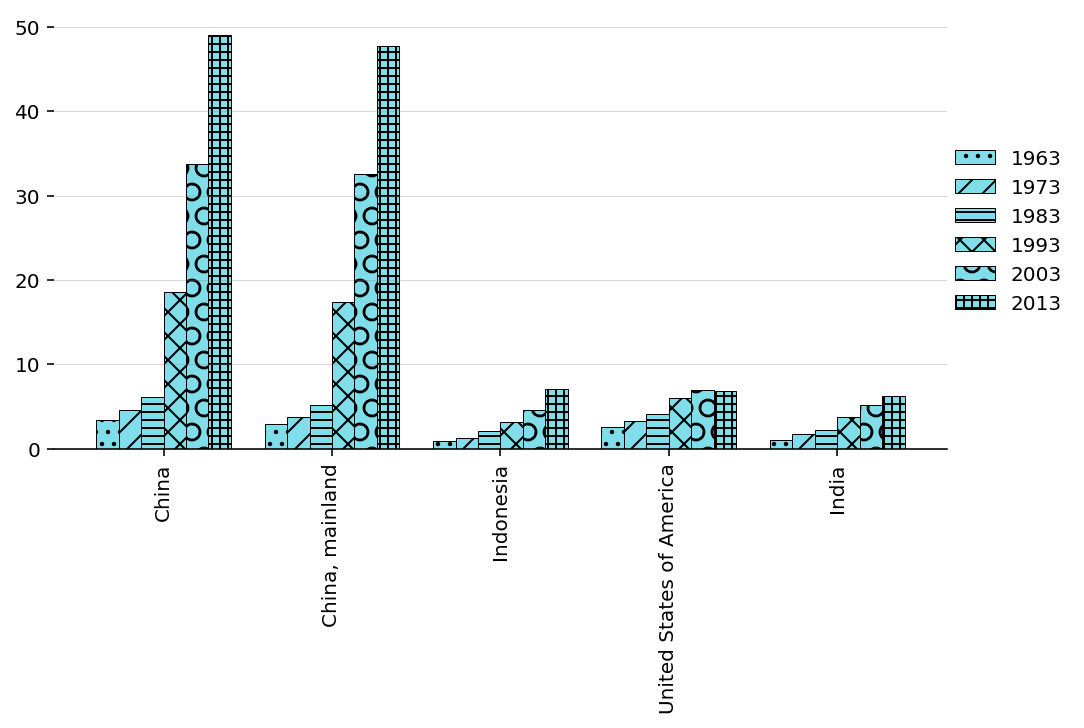

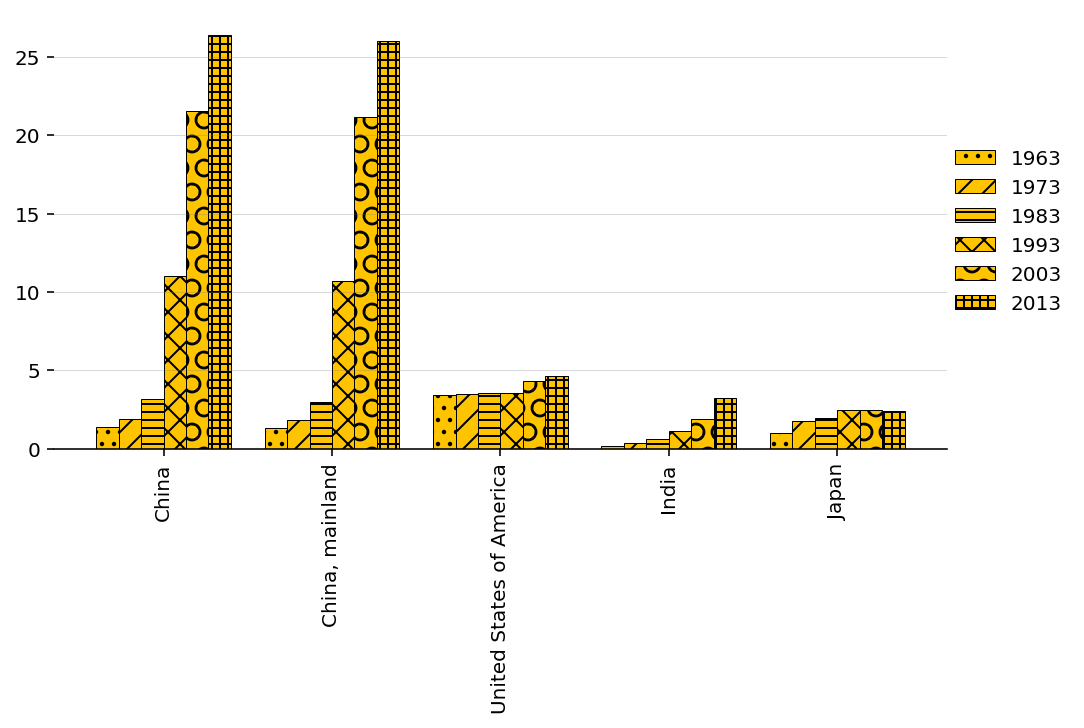

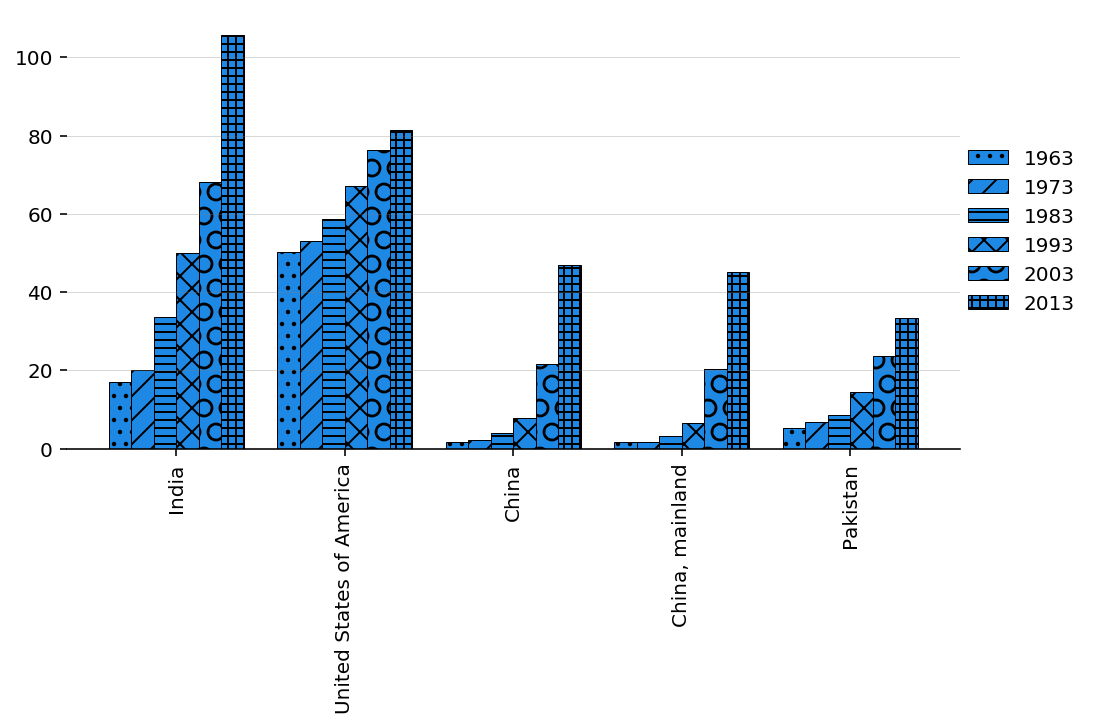

In [67]:
items=ITEMs.copy()

compareToTopAreas(A, E, items=items, toUnit='Million Tonnes', changeUnit=1/1000000)

### Other Regions Trends

World


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,27.7641,31.5583,5.9711,9.5998,30.0850,14.3650,240.7931,360.1363
1973,40.3817,39.8593,6.4276,17.2473,44.6521,19.9400,287.1111,455.6192
1983,54.7101,47.9856,7.4320,28.4599,54.9256,26.2317,355.8169,575.5617
1993,72.9159,53.0358,9.4981,46.7701,73.5300,36.1935,406.1924,698.1357
2003,91.1283,58.6942,11.2000,73.4201,102.3951,51.6302,504.1957,892.6637


Northern America


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,6.1951,9.2326,0.4198,3.5198,2.8384,3.6990,54.8946,80.7994
1973,6.5846,11.6631,0.2824,5.1108,3.7226,3.8176,58.4558,89.6369
1983,7.8259,12.5173,0.1967,7.3773,4.6460,3.8875,64.1162,100.5669
1993,8.7044,11.9510,0.1948,12.1363,6.6669,3.8214,72.9120,116.3868
2003,9.6854,13.4237,0.1904,15.6883,7.8105,4.6565,82.6295,134.0843


Western Europe


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,5.0127,3.7432,0.1660,1.1170,2.1407,1.8396,32.4109,46.4300
1973,6.9564,4.1901,0.2371,1.7616,2.5755,2.4285,36.7359,54.8851
1983,8.5146,4.3604,0.3356,2.0678,2.8737,2.6518,43.9777,64.7817
1993,8.6873,3.8735,0.3893,2.7894,3.4211,2.3237,45.3032,66.7876
2003,8.4553,3.3225,0.3392,3.2620,3.9838,2.4812,49.9216,71.7654


Australia & New Zealand


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,0.1557,0.6951,0.5732,0.0579,0.1448,0.1676,3.0936,4.8880
1973,0.2503,0.7987,0.5813,0.1769,0.2262,0.2040,4.1053,6.3427
1983,0.2762,0.8666,0.4054,0.3429,0.2825,0.2280,4.3287,6.7303
1993,0.3769,0.8795,0.4765,0.5297,0.4270,0.1799,4.8128,7.6822
2003,0.4937,1.0106,0.3641,0.8350,0.5993,0.1390,4.5711,8.0127


South-Eastern Asia


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,0.8649,0.6263,0.0467,0.3779,3.1635,0.4919,1.4596,7.0308
1973,1.1732,0.8327,0.0624,0.7215,5.0215,0.6939,2.2813,10.7864
1983,1.7441,0.9695,0.1199,1.4259,6.9077,1.1352,3.8377,16.1401
1993,3.3215,1.3558,0.1615,2.8497,9.4720,1.6432,5.0007,23.8043
2003,5.1320,1.5137,0.2167,4.3830,13.9556,2.3876,7.7089,35.2974


Japan


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,0.2799,0.1870,0.0503,0.1779,4.9350,0.9810,3.3091,9.9203
1973,1.0894,0.3990,0.1315,0.6955,7.0742,1.7611,5.7101,16.8610
1983,1.5721,0.6678,0.0811,1.3143,7.9580,1.9844,8.3669,21.9446
1993,1.8997,1.2524,0.0556,1.7139,8.3788,2.5000,10.0795,25.8800
2003,2.4203,1.2153,0.0222,2.0143,8.2998,2.4488,10.0167,26.4373


Republic of Korea


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,0.0578,0.0310,0.0009,0.0171,0.4148,0.0478,0.1024,0.6718
1973,0.0855,0.0477,0.0047,0.0537,1.1530,0.1389,0.1005,1.5840
1983,0.3689,0.1690,0.0062,0.1223,1.7581,0.2781,0.5096,3.2122
1993,0.7637,0.3477,0.0115,0.3937,2.2075,0.4063,0.9668,5.0972
2003,1.2912,0.6430,0.0055,0.5230,2.4534,0.4975,1.2383,6.6519


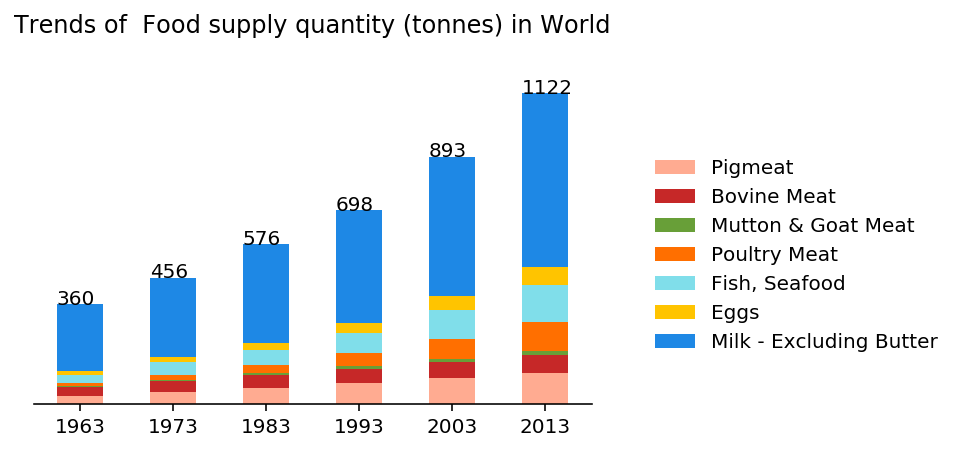

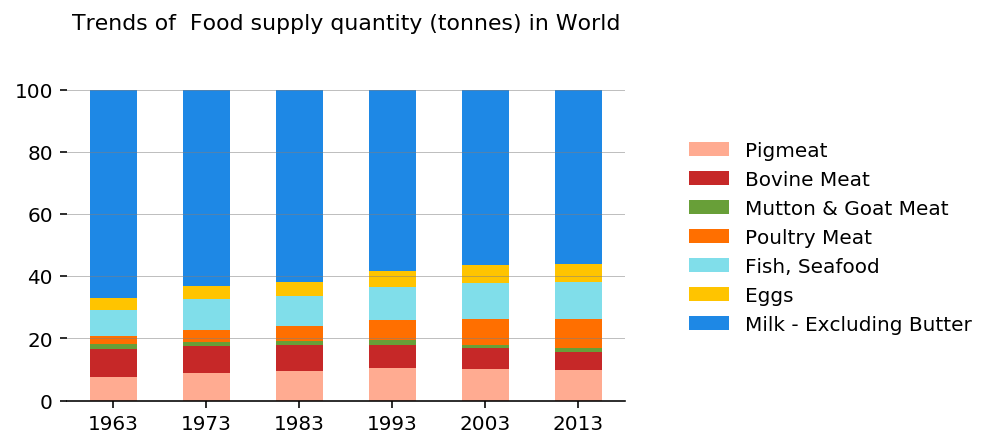

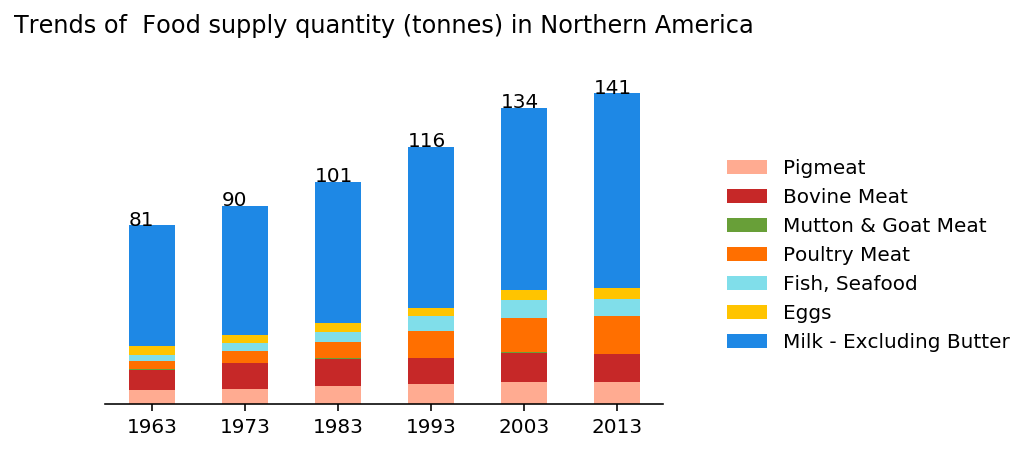

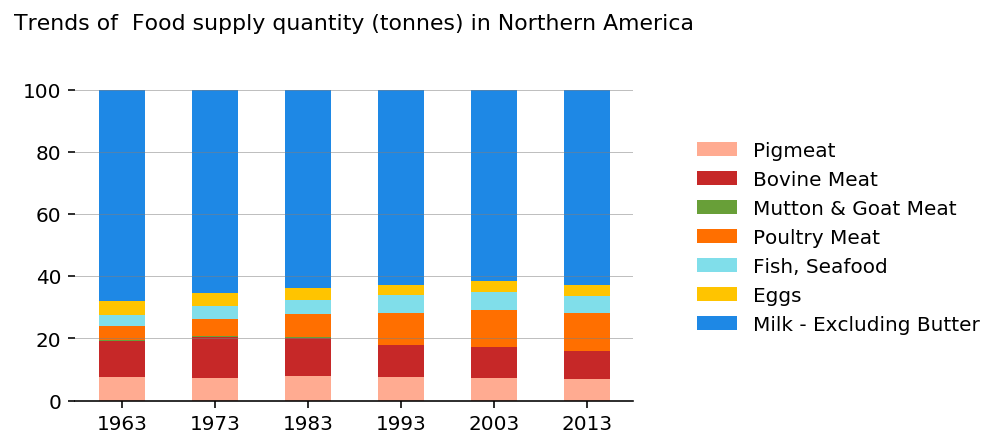

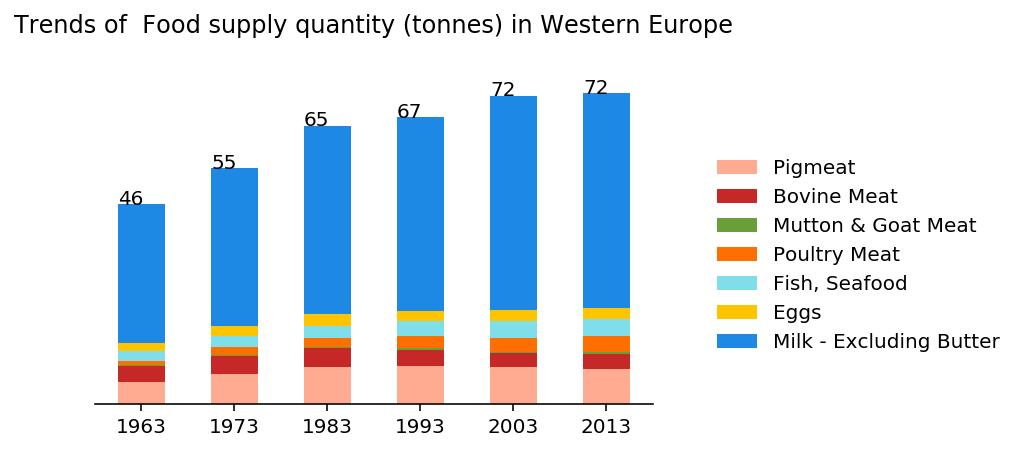

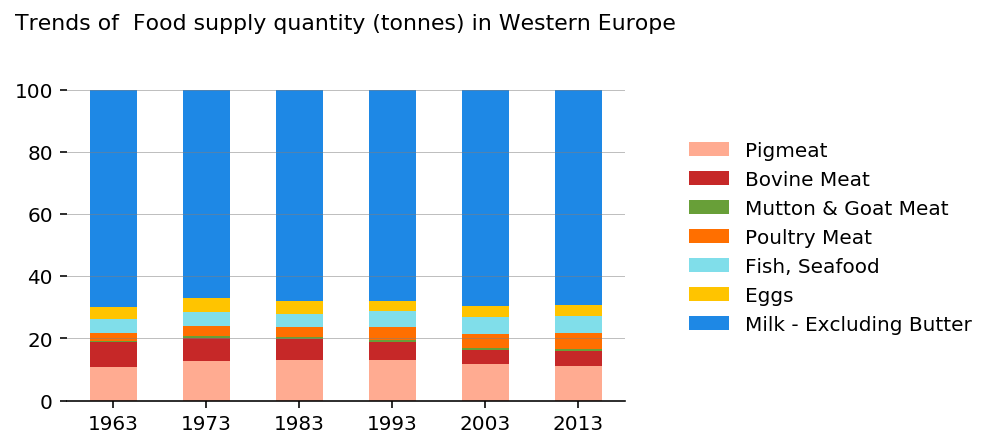

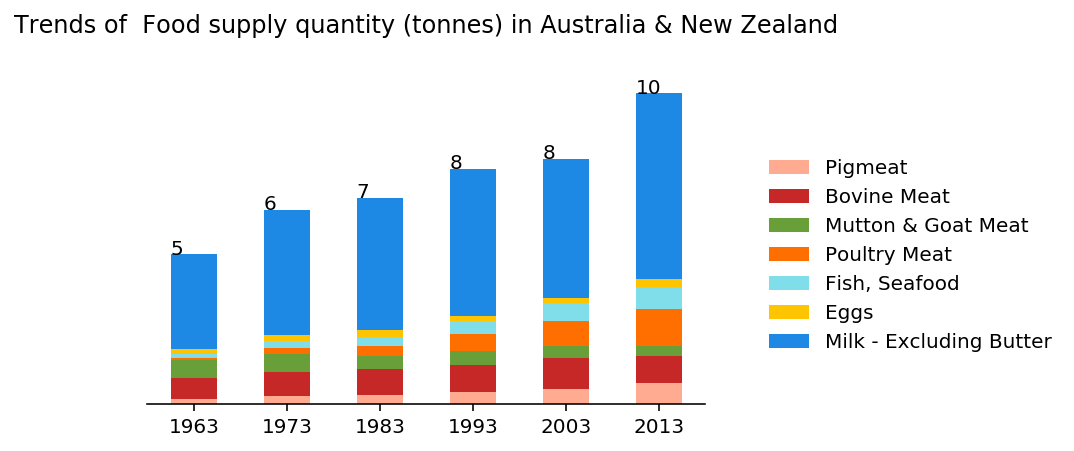

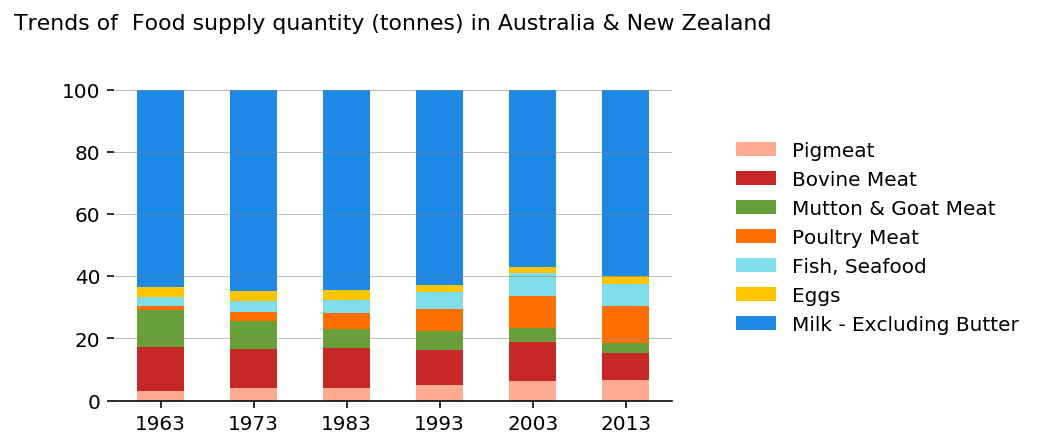

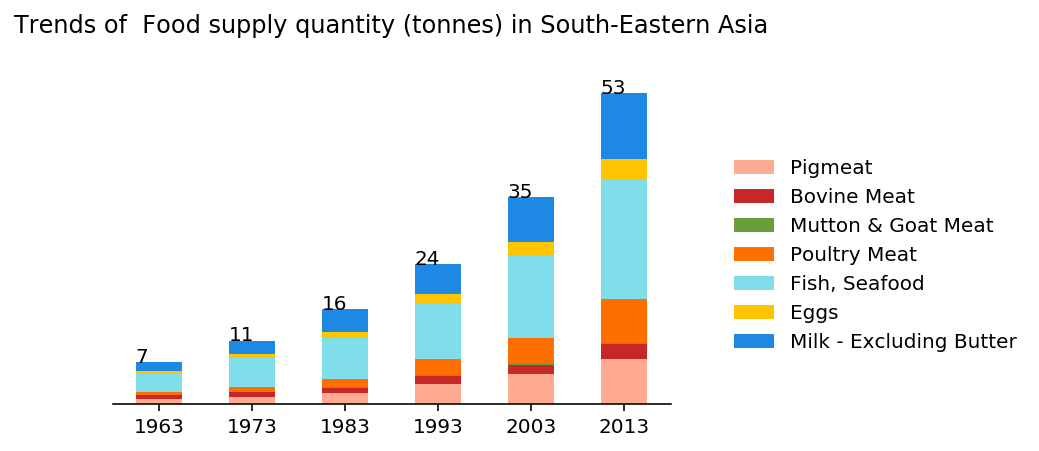

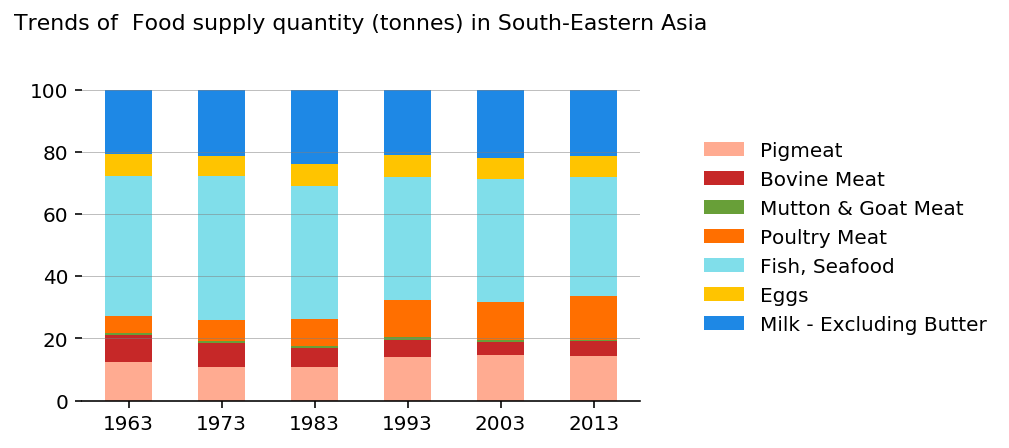

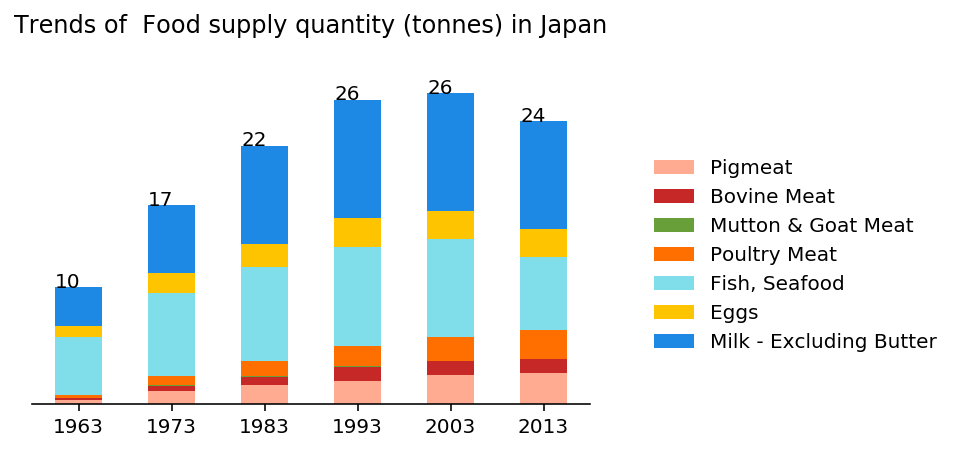

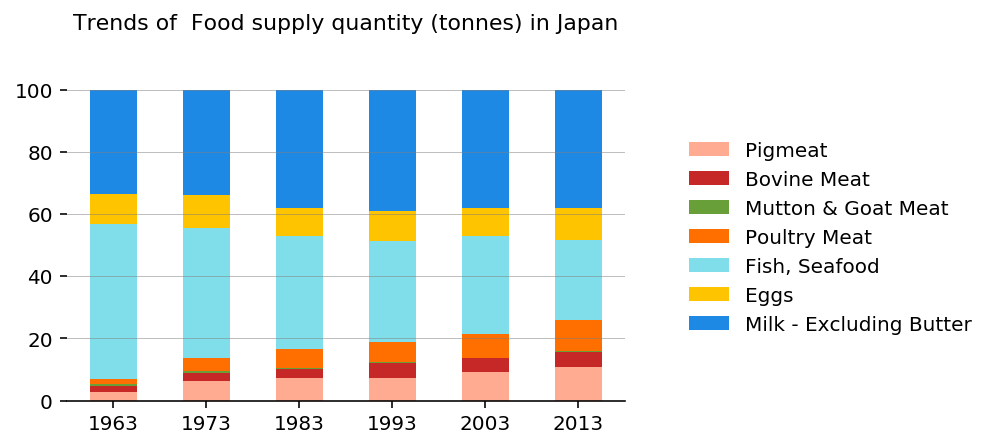

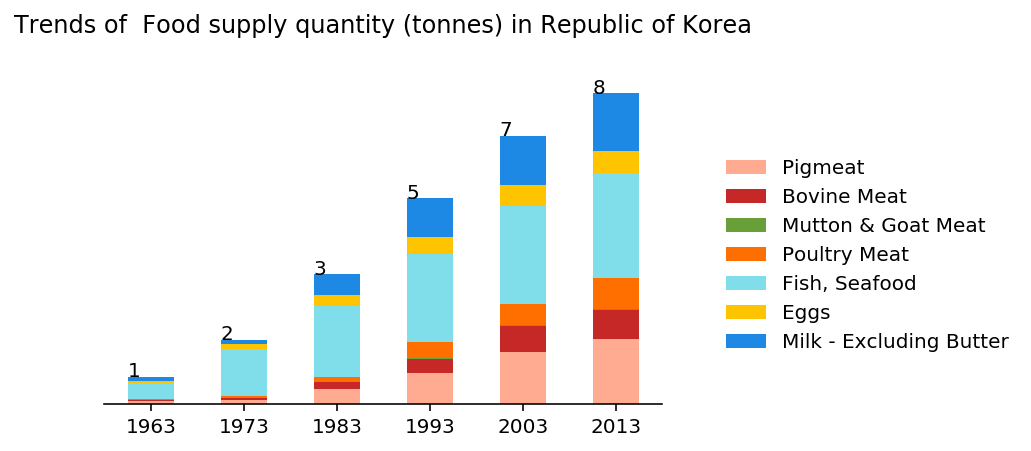

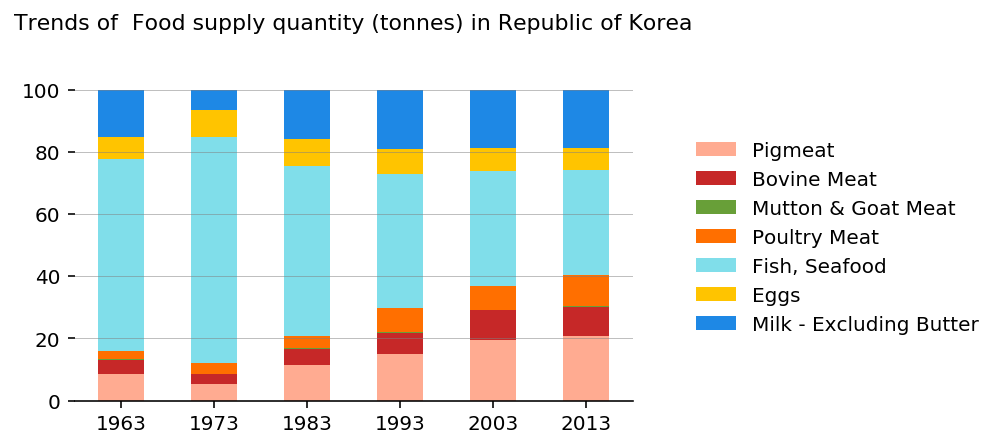

In [68]:
areas = [
    'World', 'Northern America', 'Western Europe', 'Australia & New Zealand',
    'South-Eastern Asia', 'Japan', 'Republic of Korea',
]
for a in areas:
    print(a)
    plotTrendsBar(a, E, toUnit='Million Tonnes', changeUnit = 1/1000000)